In [1]:
# Cell 1:imports

import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap

torch.__version__, models.__version__ if hasattr(models, "__version__") else "tv"


2025-08-17 20:38:06.290992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755463086.509252      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755463086.572343      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.6.0+cu124', 'tv')

In [2]:
#Cell 2: Device & Paths

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


In [3]:
#Cell 3: Hyperparameters & Seeding

SEED = 42
BATCH_SIZE_SSL = 64           # for MoCo pretraining
BATCH_SIZE_SUP = 64           # for supervised eval/test
EPOCHS_SSL = 2000             # MoCo pretraining epochs
EPOCHS_LINEAR = 2000        # linear eval epochs

FEATURE_DIM = 512             # ResNet-18 penultimate feature size
PROJ_DIM = 128                # projection dim for MoCo
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

# MoCo-specific
MOMENTUM = 0.999              # momentum for key encoder
QUEUE_SIZE = 1024             # dictionary size
TEMPERATURE = 0.2             # contrastive temperature

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
#Cell 4: Small Utils

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


In [5]:
# Cell 5: Transforms

# Two random augmentations for MoCo (query & key)
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k

# MoCo augmentations (SimCLR-style are fine for MoCo too)
ssl_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# Supervised (linear eval/test) transform
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])


In [6]:
# Cell 6: Datasets & 20/80 Split + Loaders

# Full supervised dataset (for splits & labels)
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 20% train, 80% test
n_total = len(full_dataset_supervised)
n_train = int(0.2 * n_total)
n_test = n_total - n_train

train_sup, test_sup = random_split(
    full_dataset_supervised, [n_train, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# SSL dataset: same images but produces (q,k) pairs
ssl_dataset = ImageFolder(root=DATA_DIR, transform=TwoCropsTransform(ssl_transform))
ssl_train_subset = Subset(ssl_dataset, train_sup.indices)

# DataLoaders
ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True,
                              num_workers=2, drop_last=True)

train_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_sup,  batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

# For visualizations (t-SNE/UMAP) over train portion
vis_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | Train: {len(train_sup)} | Test: {len(test_sup)}")


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | Train: 638 | Test: 2554


In [7]:
# Cell 7: MoCo Definition (ResNet-18 Backbones)

class MoCo(nn.Module):
    """
    Minimal MoCo v1-style implementation:
    - encoder_q: online (query) encoder
    - encoder_k: momentum (key) encoder
    - queue: negative dictionary
    """
    def __init__(self, base_encoder, feature_dim=128, K=1024, m=0.999, T=0.2):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T

        # Build encoders: output = feature_dim
        self.encoder_q = base_encoder(num_classes=feature_dim)
        self.encoder_k = base_encoder(num_classes=feature_dim)

        # Initialize encoder_k to encoder_q, and set to not require grad
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update key encoder."""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Enqueue the current keys and dequeue the oldest ones."""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        # For simplicity, require queue size divisible by batch size
        if self.K % batch_size != 0:
            # If not divisible, only fill to the end
            end = min(ptr + batch_size, self.K)
            span = end - ptr
            self.queue[:, ptr:end] = keys[:span].T
            ptr = end % self.K
            self.queue_ptr[0] = ptr
            return

        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # Compute key features with momentum encoder (no grad)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # Positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Concatenate and apply temperature
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        # Labels: positives are the 0-th
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update dictionary
        self._dequeue_and_enqueue(k)

        return logits, labels

def resnet18_moco(num_classes=128):
    """ResNet-18 backbone with final fc replaced by projection to num_classes."""
    model = models.resnet18(weights=None)
    dim_mlp = model.fc.in_features
    model.fc = nn.Linear(dim_mlp, num_classes)
    return model


In [8]:
# Cell 8: Train MoCo Pretraining

moco = MoCo(base_encoder=resnet18_moco, feature_dim=PROJ_DIM,
            K=QUEUE_SIZE, m=MOMENTUM, T=TEMPERATURE).to(DEVICE)

opt_moco = torch.optim.Adam(moco.parameters(), lr=LR_SSL)
moco_loss_history = []

print("Starting MoCo pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    moco.train()
    running = 0.0
    for (im_q, im_k), _ in tqdm(ssl_train_loader, desc=f"MoCo Epoch {epoch}/{EPOCHS_SSL}"):
        im_q, im_k = im_q.to(DEVICE), im_k.to(DEVICE)
        logits, labels = moco(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        opt_moco.zero_grad()
        loss.backward()
        opt_moco.step()

        running += loss.item() * im_q.size(0)

    epoch_loss = running / len(ssl_train_loader.dataset)
    moco_loss_history.append(epoch_loss)
    print(f"MoCo Epoch {epoch}: loss={epoch_loss:.4f}")

# Save the query encoder (backbone+proj) – we will load as backbone and strip fc
torch.save(moco.encoder_q.state_dict(), os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))
print("Saved MoCo encoder to:", os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))


Starting MoCo pretraining...


MoCo Epoch 1/2000: 100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


MoCo Epoch 1: loss=4.5983


MoCo Epoch 2/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 2: loss=5.8297


MoCo Epoch 3/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 3: loss=5.9500


MoCo Epoch 4/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 4: loss=5.9231


MoCo Epoch 5/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 5: loss=5.8817


MoCo Epoch 6/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 6: loss=5.8471


MoCo Epoch 7/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 7: loss=5.8403


MoCo Epoch 8/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 8: loss=5.8534


MoCo Epoch 9/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 9: loss=5.7609


MoCo Epoch 10/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 10: loss=5.7749


MoCo Epoch 11/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 11: loss=5.7871


MoCo Epoch 12/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 12: loss=5.7686


MoCo Epoch 13/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 13: loss=5.7165


MoCo Epoch 14/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 14: loss=5.6849


MoCo Epoch 15/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 15: loss=5.6761


MoCo Epoch 16/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 16: loss=5.6623


MoCo Epoch 17/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 17: loss=5.6530


MoCo Epoch 18/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 18: loss=5.6126


MoCo Epoch 19/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 19: loss=5.6071


MoCo Epoch 20/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 20: loss=5.6230


MoCo Epoch 21/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 21: loss=5.5554


MoCo Epoch 22/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 22: loss=5.6072


MoCo Epoch 23/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 23: loss=5.5578


MoCo Epoch 24/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 24: loss=5.5512


MoCo Epoch 25/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 25: loss=5.5138


MoCo Epoch 26/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 26: loss=5.6095


MoCo Epoch 27/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 27: loss=5.5243


MoCo Epoch 28/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 28: loss=5.4906


MoCo Epoch 29/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 29: loss=5.5201


MoCo Epoch 30/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 30: loss=5.4390


MoCo Epoch 31/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 31: loss=5.5088


MoCo Epoch 32/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 32: loss=5.4357


MoCo Epoch 33/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 33: loss=5.4472


MoCo Epoch 34/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 34: loss=5.4082


MoCo Epoch 35/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 35: loss=5.4178


MoCo Epoch 36/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 36: loss=5.3955


MoCo Epoch 37/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 37: loss=5.4310


MoCo Epoch 38/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 38: loss=5.4185


MoCo Epoch 39/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 39: loss=5.3519


MoCo Epoch 40/2000: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


MoCo Epoch 40: loss=5.4406


MoCo Epoch 41/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


MoCo Epoch 41: loss=5.3635


MoCo Epoch 42/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 42: loss=5.3825


MoCo Epoch 43/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 43: loss=5.3600


MoCo Epoch 44/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 44: loss=5.2429


MoCo Epoch 45/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 45: loss=5.3452


MoCo Epoch 46/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 46: loss=5.2523


MoCo Epoch 47/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 47: loss=5.2875


MoCo Epoch 48/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 48: loss=5.3062


MoCo Epoch 49/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 49: loss=5.2579


MoCo Epoch 50/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 50: loss=5.3013


MoCo Epoch 51/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 51: loss=5.3083


MoCo Epoch 52/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 52: loss=5.1767


MoCo Epoch 53/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 53: loss=5.2430


MoCo Epoch 54/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 54: loss=5.2191


MoCo Epoch 55/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 55: loss=5.1753


MoCo Epoch 56/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 56: loss=5.2189


MoCo Epoch 57/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 57: loss=5.1085


MoCo Epoch 58/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 58: loss=5.2342


MoCo Epoch 59/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 59: loss=5.1236


MoCo Epoch 60/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 60: loss=5.1502


MoCo Epoch 61/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 61: loss=5.1646


MoCo Epoch 62/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 62: loss=5.1263


MoCo Epoch 63/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 63: loss=5.1552


MoCo Epoch 64/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 64: loss=5.1299


MoCo Epoch 65/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 65: loss=5.0898


MoCo Epoch 66/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 66: loss=5.0815


MoCo Epoch 67/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 67: loss=5.1025


MoCo Epoch 68/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 68: loss=5.0810


MoCo Epoch 69/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 69: loss=5.0194


MoCo Epoch 70/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 70: loss=5.0503


MoCo Epoch 71/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 71: loss=5.0567


MoCo Epoch 72/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 72: loss=5.0088


MoCo Epoch 73/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 73: loss=5.0738


MoCo Epoch 74/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 74: loss=5.0557


MoCo Epoch 75/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 75: loss=4.9621


MoCo Epoch 76/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 76: loss=5.0594


MoCo Epoch 77/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 77: loss=5.0304


MoCo Epoch 78/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 78: loss=5.0233


MoCo Epoch 79/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 79: loss=4.9652


MoCo Epoch 80/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 80: loss=5.0084


MoCo Epoch 81/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 81: loss=4.9604


MoCo Epoch 82/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 82: loss=5.0442


MoCo Epoch 83/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 83: loss=5.0021


MoCo Epoch 84/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 84: loss=4.9323


MoCo Epoch 85/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 85: loss=4.9399


MoCo Epoch 86/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 86: loss=4.9514


MoCo Epoch 87/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 87: loss=4.8701


MoCo Epoch 88/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 88: loss=4.9312


MoCo Epoch 89/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 89: loss=4.9017


MoCo Epoch 90/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 90: loss=4.9515


MoCo Epoch 91/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 91: loss=4.8651


MoCo Epoch 92/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 92: loss=4.9469


MoCo Epoch 93/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 93: loss=4.8972


MoCo Epoch 94/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 94: loss=4.9033


MoCo Epoch 95/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 95: loss=4.9027


MoCo Epoch 96/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 96: loss=4.9321


MoCo Epoch 97/2000: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


MoCo Epoch 97: loss=4.8017


MoCo Epoch 98/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 98: loss=4.8542


MoCo Epoch 99/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 99: loss=4.7913


MoCo Epoch 100/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 100: loss=4.8517


MoCo Epoch 101/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 101: loss=4.8578


MoCo Epoch 102/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 102: loss=4.8219


MoCo Epoch 103/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 103: loss=4.8664


MoCo Epoch 104/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 104: loss=4.8309


MoCo Epoch 105/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 105: loss=4.8858


MoCo Epoch 106/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 106: loss=4.8280


MoCo Epoch 107/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 107: loss=4.8064


MoCo Epoch 108/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 108: loss=4.8233


MoCo Epoch 109/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 109: loss=4.7778


MoCo Epoch 110/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 110: loss=4.7793


MoCo Epoch 111/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 111: loss=4.7981


MoCo Epoch 112/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 112: loss=4.8117


MoCo Epoch 113/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 113: loss=4.7769


MoCo Epoch 114/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 114: loss=4.7660


MoCo Epoch 115/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 115: loss=4.7913


MoCo Epoch 116/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 116: loss=4.7844


MoCo Epoch 117/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 117: loss=4.7395


MoCo Epoch 118/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 118: loss=4.7362


MoCo Epoch 119/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 119: loss=4.7243


MoCo Epoch 120/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 120: loss=4.7535


MoCo Epoch 121/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 121: loss=4.7055


MoCo Epoch 122/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 122: loss=4.6957


MoCo Epoch 123/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 123: loss=4.7188


MoCo Epoch 124/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 124: loss=4.6789


MoCo Epoch 125/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 125: loss=4.6777


MoCo Epoch 126/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 126: loss=4.6525


MoCo Epoch 127/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 127: loss=4.6404


MoCo Epoch 128/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 128: loss=4.6529


MoCo Epoch 129/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 129: loss=4.6731


MoCo Epoch 130/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 130: loss=4.7422


MoCo Epoch 131/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 131: loss=4.6342


MoCo Epoch 132/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 132: loss=4.6296


MoCo Epoch 133/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 133: loss=4.6454


MoCo Epoch 134/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 134: loss=4.6342


MoCo Epoch 135/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 135: loss=4.6082


MoCo Epoch 136/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 136: loss=4.6334


MoCo Epoch 137/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 137: loss=4.6022


MoCo Epoch 138/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 138: loss=4.6354


MoCo Epoch 139/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 139: loss=4.5852


MoCo Epoch 140/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 140: loss=4.6622


MoCo Epoch 141/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 141: loss=4.5839


MoCo Epoch 142/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 142: loss=4.5737


MoCo Epoch 143/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 143: loss=4.6573


MoCo Epoch 144/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 144: loss=4.6120


MoCo Epoch 145/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 145: loss=4.6256


MoCo Epoch 146/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 146: loss=4.6030


MoCo Epoch 147/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 147: loss=4.5203


MoCo Epoch 148/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 148: loss=4.5777


MoCo Epoch 149/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 149: loss=4.6298


MoCo Epoch 150/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 150: loss=4.5899


MoCo Epoch 151/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 151: loss=4.5379


MoCo Epoch 152/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 152: loss=4.5404


MoCo Epoch 153/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 153: loss=4.4948


MoCo Epoch 154/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 154: loss=4.5495


MoCo Epoch 155/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 155: loss=4.4370


MoCo Epoch 156/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 156: loss=4.5530


MoCo Epoch 157/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 157: loss=4.5407


MoCo Epoch 158/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 158: loss=4.5053


MoCo Epoch 159/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 159: loss=4.5455


MoCo Epoch 160/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 160: loss=4.5175


MoCo Epoch 161/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 161: loss=4.4927


MoCo Epoch 162/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 162: loss=4.4661


MoCo Epoch 163/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 163: loss=4.5031


MoCo Epoch 164/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 164: loss=4.4935


MoCo Epoch 165/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 165: loss=4.5166


MoCo Epoch 166/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 166: loss=4.5062


MoCo Epoch 167/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 167: loss=4.4623


MoCo Epoch 168/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 168: loss=4.5054


MoCo Epoch 169/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 169: loss=4.5384


MoCo Epoch 170/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 170: loss=4.5088


MoCo Epoch 171/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 171: loss=4.4564


MoCo Epoch 172/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 172: loss=4.4887


MoCo Epoch 173/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 173: loss=4.4556


MoCo Epoch 174/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 174: loss=4.4632


MoCo Epoch 175/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 175: loss=4.3864


MoCo Epoch 176/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 176: loss=4.3973


MoCo Epoch 177/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 177: loss=4.4679


MoCo Epoch 178/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 178: loss=4.4119


MoCo Epoch 179/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 179: loss=4.4318


MoCo Epoch 180/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 180: loss=4.4620


MoCo Epoch 181/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 181: loss=4.4020


MoCo Epoch 182/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 182: loss=4.4399


MoCo Epoch 183/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 183: loss=4.4531


MoCo Epoch 184/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 184: loss=4.4386


MoCo Epoch 185/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 185: loss=4.4785


MoCo Epoch 186/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 186: loss=4.4176


MoCo Epoch 187/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 187: loss=4.4444


MoCo Epoch 188/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 188: loss=4.3795


MoCo Epoch 189/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 189: loss=4.3104


MoCo Epoch 190/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 190: loss=4.3890


MoCo Epoch 191/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 191: loss=4.4094


MoCo Epoch 192/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 192: loss=4.3829


MoCo Epoch 193/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 193: loss=4.3823


MoCo Epoch 194/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 194: loss=4.4640


MoCo Epoch 195/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 195: loss=4.3724


MoCo Epoch 196/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 196: loss=4.3904


MoCo Epoch 197/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 197: loss=4.3227


MoCo Epoch 198/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 198: loss=4.3760


MoCo Epoch 199/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 199: loss=4.3541


MoCo Epoch 200/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 200: loss=4.3258


MoCo Epoch 201/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 201: loss=4.3757


MoCo Epoch 202/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 202: loss=4.2784


MoCo Epoch 203/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 203: loss=4.3437


MoCo Epoch 204/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 204: loss=4.3169


MoCo Epoch 205/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 205: loss=4.3310


MoCo Epoch 206/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 206: loss=4.3695


MoCo Epoch 207/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 207: loss=4.3416


MoCo Epoch 208/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 208: loss=4.3133


MoCo Epoch 209/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 209: loss=4.3457


MoCo Epoch 210/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 210: loss=4.2938


MoCo Epoch 211/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 211: loss=4.3321


MoCo Epoch 212/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 212: loss=4.2707


MoCo Epoch 213/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 213: loss=4.3103


MoCo Epoch 214/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 214: loss=4.2422


MoCo Epoch 215/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 215: loss=4.3157


MoCo Epoch 216/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 216: loss=4.2991


MoCo Epoch 217/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 217: loss=4.2693


MoCo Epoch 218/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 218: loss=4.3034


MoCo Epoch 219/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 219: loss=4.2993


MoCo Epoch 220/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 220: loss=4.3203


MoCo Epoch 221/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 221: loss=4.4067


MoCo Epoch 222/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 222: loss=4.3004


MoCo Epoch 223/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 223: loss=4.3121


MoCo Epoch 224/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 224: loss=4.2326


MoCo Epoch 225/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 225: loss=4.2312


MoCo Epoch 226/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 226: loss=4.2000


MoCo Epoch 227/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 227: loss=4.1716


MoCo Epoch 228/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 228: loss=4.2359


MoCo Epoch 229/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 229: loss=4.2333


MoCo Epoch 230/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 230: loss=4.2802


MoCo Epoch 231/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 231: loss=4.2338


MoCo Epoch 232/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 232: loss=4.1680


MoCo Epoch 233/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 233: loss=4.2142


MoCo Epoch 234/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 234: loss=4.1812


MoCo Epoch 235/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 235: loss=4.2476


MoCo Epoch 236/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 236: loss=4.1639


MoCo Epoch 237/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 237: loss=4.2176


MoCo Epoch 238/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 238: loss=4.2097


MoCo Epoch 239/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 239: loss=4.1794


MoCo Epoch 240/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 240: loss=4.1719


MoCo Epoch 241/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 241: loss=4.2261


MoCo Epoch 242/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 242: loss=4.1639


MoCo Epoch 243/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 243: loss=4.2366


MoCo Epoch 244/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 244: loss=4.2250


MoCo Epoch 245/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 245: loss=4.2084


MoCo Epoch 246/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 246: loss=4.1861


MoCo Epoch 247/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 247: loss=4.1869


MoCo Epoch 248/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 248: loss=4.1533


MoCo Epoch 249/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 249: loss=4.1181


MoCo Epoch 250/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 250: loss=4.2144


MoCo Epoch 251/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 251: loss=4.2150


MoCo Epoch 252/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 252: loss=4.1762


MoCo Epoch 253/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 253: loss=4.1518


MoCo Epoch 254/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 254: loss=4.1062


MoCo Epoch 255/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 255: loss=4.1736


MoCo Epoch 256/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 256: loss=4.1365


MoCo Epoch 257/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 257: loss=4.1320


MoCo Epoch 258/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 258: loss=4.1107


MoCo Epoch 259/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 259: loss=4.1689


MoCo Epoch 260/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 260: loss=4.1736


MoCo Epoch 261/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 261: loss=4.1413


MoCo Epoch 262/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 262: loss=4.1169


MoCo Epoch 263/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 263: loss=4.1240


MoCo Epoch 264/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 264: loss=4.0871


MoCo Epoch 265/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 265: loss=4.0643


MoCo Epoch 266/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 266: loss=4.1487


MoCo Epoch 267/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 267: loss=4.1050


MoCo Epoch 268/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 268: loss=4.1118


MoCo Epoch 269/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 269: loss=4.1248


MoCo Epoch 270/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 270: loss=4.0608


MoCo Epoch 271/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 271: loss=4.0805


MoCo Epoch 272/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 272: loss=4.1260


MoCo Epoch 273/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 273: loss=4.0748


MoCo Epoch 274/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 274: loss=4.0427


MoCo Epoch 275/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 275: loss=4.0590


MoCo Epoch 276/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 276: loss=4.0668


MoCo Epoch 277/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 277: loss=4.1505


MoCo Epoch 278/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 278: loss=4.1301


MoCo Epoch 279/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 279: loss=4.0254


MoCo Epoch 280/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 280: loss=4.0902


MoCo Epoch 281/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 281: loss=4.1150


MoCo Epoch 282/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 282: loss=4.1316


MoCo Epoch 283/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 283: loss=4.0728


MoCo Epoch 284/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 284: loss=4.0784


MoCo Epoch 285/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 285: loss=4.0603


MoCo Epoch 286/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 286: loss=4.1099


MoCo Epoch 287/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 287: loss=4.0721


MoCo Epoch 288/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 288: loss=4.0364


MoCo Epoch 289/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 289: loss=4.0514


MoCo Epoch 290/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 290: loss=4.0548


MoCo Epoch 291/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 291: loss=4.0734


MoCo Epoch 292/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 292: loss=4.0211


MoCo Epoch 293/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 293: loss=4.0239


MoCo Epoch 294/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 294: loss=4.0799


MoCo Epoch 295/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 295: loss=4.0253


MoCo Epoch 296/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 296: loss=3.9687


MoCo Epoch 297/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 297: loss=4.0748


MoCo Epoch 298/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 298: loss=3.9946


MoCo Epoch 299/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 299: loss=4.1299


MoCo Epoch 300/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 300: loss=3.9855


MoCo Epoch 301/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 301: loss=4.0143


MoCo Epoch 302/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 302: loss=4.0392


MoCo Epoch 303/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 303: loss=3.9531


MoCo Epoch 304/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 304: loss=3.9819


MoCo Epoch 305/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 305: loss=4.0205


MoCo Epoch 306/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 306: loss=4.0038


MoCo Epoch 307/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 307: loss=3.9984


MoCo Epoch 308/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 308: loss=4.0247


MoCo Epoch 309/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 309: loss=3.9511


MoCo Epoch 310/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 310: loss=3.9442


MoCo Epoch 311/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 311: loss=3.9326


MoCo Epoch 312/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 312: loss=3.9959


MoCo Epoch 313/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 313: loss=3.9983


MoCo Epoch 314/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 314: loss=3.9638


MoCo Epoch 315/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 315: loss=3.9890


MoCo Epoch 316/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 316: loss=3.9596


MoCo Epoch 317/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 317: loss=3.9820


MoCo Epoch 318/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 318: loss=3.9639


MoCo Epoch 319/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 319: loss=3.8990


MoCo Epoch 320/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 320: loss=3.9007


MoCo Epoch 321/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 321: loss=3.9479


MoCo Epoch 322/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 322: loss=3.9342


MoCo Epoch 323/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 323: loss=3.8816


MoCo Epoch 324/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 324: loss=3.8960


MoCo Epoch 325/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 325: loss=3.9340


MoCo Epoch 326/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 326: loss=3.9046


MoCo Epoch 327/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 327: loss=3.8781


MoCo Epoch 328/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 328: loss=3.9378


MoCo Epoch 329/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 329: loss=3.9118


MoCo Epoch 330/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 330: loss=3.9527


MoCo Epoch 331/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 331: loss=3.9630


MoCo Epoch 332/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 332: loss=3.9229


MoCo Epoch 333/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 333: loss=3.9028


MoCo Epoch 334/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 334: loss=3.9452


MoCo Epoch 335/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 335: loss=3.9713


MoCo Epoch 336/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 336: loss=3.8724


MoCo Epoch 337/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 337: loss=3.8937


MoCo Epoch 338/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 338: loss=3.8972


MoCo Epoch 339/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 339: loss=3.9186


MoCo Epoch 340/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 340: loss=3.8742


MoCo Epoch 341/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 341: loss=3.8788


MoCo Epoch 342/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 342: loss=3.8948


MoCo Epoch 343/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 343: loss=3.8902


MoCo Epoch 344/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 344: loss=3.8793


MoCo Epoch 345/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 345: loss=3.8524


MoCo Epoch 346/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 346: loss=3.8892


MoCo Epoch 347/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 347: loss=3.9190


MoCo Epoch 348/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 348: loss=3.8947


MoCo Epoch 349/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 349: loss=3.8714


MoCo Epoch 350/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 350: loss=3.8852


MoCo Epoch 351/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 351: loss=3.8441


MoCo Epoch 352/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 352: loss=3.8997


MoCo Epoch 353/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 353: loss=3.9017


MoCo Epoch 354/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 354: loss=3.8440


MoCo Epoch 355/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 355: loss=3.9069


MoCo Epoch 356/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 356: loss=3.8608


MoCo Epoch 357/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 357: loss=3.9142


MoCo Epoch 358/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 358: loss=3.8243


MoCo Epoch 359/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 359: loss=3.8330


MoCo Epoch 360/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 360: loss=3.8298


MoCo Epoch 361/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 361: loss=3.8560


MoCo Epoch 362/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 362: loss=3.8752


MoCo Epoch 363/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 363: loss=3.8194


MoCo Epoch 364/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 364: loss=3.8119


MoCo Epoch 365/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 365: loss=3.8250


MoCo Epoch 366/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 366: loss=3.8628


MoCo Epoch 367/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 367: loss=3.8339


MoCo Epoch 368/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 368: loss=3.8108


MoCo Epoch 369/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 369: loss=3.7469


MoCo Epoch 370/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 370: loss=3.8154


MoCo Epoch 371/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 371: loss=3.8057


MoCo Epoch 372/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 372: loss=3.8504


MoCo Epoch 373/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 373: loss=3.8036


MoCo Epoch 374/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 374: loss=3.8378


MoCo Epoch 375/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 375: loss=3.7992


MoCo Epoch 376/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 376: loss=3.7654


MoCo Epoch 377/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 377: loss=3.8280


MoCo Epoch 378/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 378: loss=3.7985


MoCo Epoch 379/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 379: loss=3.8460


MoCo Epoch 380/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 380: loss=3.7582


MoCo Epoch 381/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 381: loss=3.7828


MoCo Epoch 382/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 382: loss=3.8162


MoCo Epoch 383/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 383: loss=3.8236


MoCo Epoch 384/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 384: loss=3.8082


MoCo Epoch 385/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 385: loss=3.8036


MoCo Epoch 386/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 386: loss=3.7978


MoCo Epoch 387/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 387: loss=3.8214


MoCo Epoch 388/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 388: loss=3.8272


MoCo Epoch 389/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 389: loss=3.7791


MoCo Epoch 390/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 390: loss=3.7335


MoCo Epoch 391/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 391: loss=3.8341


MoCo Epoch 392/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 392: loss=3.7926


MoCo Epoch 393/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 393: loss=3.7468


MoCo Epoch 394/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 394: loss=3.7968


MoCo Epoch 395/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 395: loss=3.7448


MoCo Epoch 396/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 396: loss=3.7610


MoCo Epoch 397/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 397: loss=3.7538


MoCo Epoch 398/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 398: loss=3.7476


MoCo Epoch 399/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 399: loss=3.8205


MoCo Epoch 400/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 400: loss=3.7658


MoCo Epoch 401/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 401: loss=3.7712


MoCo Epoch 402/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 402: loss=3.8033


MoCo Epoch 403/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 403: loss=3.7476


MoCo Epoch 404/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 404: loss=3.7454


MoCo Epoch 405/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 405: loss=3.6874


MoCo Epoch 406/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 406: loss=3.7066


MoCo Epoch 407/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 407: loss=3.7518


MoCo Epoch 408/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 408: loss=3.7219


MoCo Epoch 409/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 409: loss=3.7273


MoCo Epoch 410/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 410: loss=3.7346


MoCo Epoch 411/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 411: loss=3.7302


MoCo Epoch 412/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 412: loss=3.7475


MoCo Epoch 413/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 413: loss=3.7046


MoCo Epoch 414/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 414: loss=3.7578


MoCo Epoch 415/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 415: loss=3.7110


MoCo Epoch 416/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 416: loss=3.7066


MoCo Epoch 417/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 417: loss=3.7154


MoCo Epoch 418/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 418: loss=3.6983


MoCo Epoch 419/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 419: loss=3.7509


MoCo Epoch 420/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 420: loss=3.6924


MoCo Epoch 421/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 421: loss=3.7648


MoCo Epoch 422/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 422: loss=3.7275


MoCo Epoch 423/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 423: loss=3.7187


MoCo Epoch 424/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 424: loss=3.7389


MoCo Epoch 425/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 425: loss=3.7289


MoCo Epoch 426/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 426: loss=3.6762


MoCo Epoch 427/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 427: loss=3.6849


MoCo Epoch 428/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 428: loss=3.6891


MoCo Epoch 429/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 429: loss=3.6563


MoCo Epoch 430/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 430: loss=3.7725


MoCo Epoch 431/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 431: loss=3.6785


MoCo Epoch 432/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 432: loss=3.6692


MoCo Epoch 433/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 433: loss=3.6925


MoCo Epoch 434/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 434: loss=3.6707


MoCo Epoch 435/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 435: loss=3.6304


MoCo Epoch 436/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 436: loss=3.6891


MoCo Epoch 437/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 437: loss=3.6508


MoCo Epoch 438/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 438: loss=3.5895


MoCo Epoch 439/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 439: loss=3.6456


MoCo Epoch 440/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 440: loss=3.7070


MoCo Epoch 441/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 441: loss=3.7041


MoCo Epoch 442/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 442: loss=3.7013


MoCo Epoch 443/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 443: loss=3.6507


MoCo Epoch 444/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 444: loss=3.6913


MoCo Epoch 445/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 445: loss=3.6569


MoCo Epoch 446/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 446: loss=3.6769


MoCo Epoch 447/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 447: loss=3.5880


MoCo Epoch 448/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 448: loss=3.6601


MoCo Epoch 449/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 449: loss=3.6523


MoCo Epoch 450/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 450: loss=3.6369


MoCo Epoch 451/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 451: loss=3.6829


MoCo Epoch 452/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 452: loss=3.6869


MoCo Epoch 453/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 453: loss=3.6525


MoCo Epoch 454/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 454: loss=3.6490


MoCo Epoch 455/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 455: loss=3.6404


MoCo Epoch 456/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 456: loss=3.6430


MoCo Epoch 457/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 457: loss=3.6745


MoCo Epoch 458/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 458: loss=3.6441


MoCo Epoch 459/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 459: loss=3.6561


MoCo Epoch 460/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 460: loss=3.5669


MoCo Epoch 461/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 461: loss=3.6324


MoCo Epoch 462/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 462: loss=3.5904


MoCo Epoch 463/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 463: loss=3.6375


MoCo Epoch 464/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 464: loss=3.5902


MoCo Epoch 465/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 465: loss=3.6629


MoCo Epoch 466/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 466: loss=3.6163


MoCo Epoch 467/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 467: loss=3.6219


MoCo Epoch 468/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 468: loss=3.6053


MoCo Epoch 469/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 469: loss=3.5987


MoCo Epoch 470/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 470: loss=3.6058


MoCo Epoch 471/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 471: loss=3.6373


MoCo Epoch 472/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 472: loss=3.6073


MoCo Epoch 473/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 473: loss=3.6164


MoCo Epoch 474/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 474: loss=3.6277


MoCo Epoch 475/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 475: loss=3.6016


MoCo Epoch 476/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 476: loss=3.6021


MoCo Epoch 477/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 477: loss=3.5708


MoCo Epoch 478/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 478: loss=3.6280


MoCo Epoch 479/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 479: loss=3.5615


MoCo Epoch 480/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 480: loss=3.5785


MoCo Epoch 481/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 481: loss=3.5822


MoCo Epoch 482/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 482: loss=3.5604


MoCo Epoch 483/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 483: loss=3.5549


MoCo Epoch 484/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 484: loss=3.5796


MoCo Epoch 485/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 485: loss=3.6117


MoCo Epoch 486/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 486: loss=3.5706


MoCo Epoch 487/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 487: loss=3.5826


MoCo Epoch 488/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 488: loss=3.6030


MoCo Epoch 489/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 489: loss=3.5816


MoCo Epoch 490/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 490: loss=3.5529


MoCo Epoch 491/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 491: loss=3.5384


MoCo Epoch 492/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 492: loss=3.5431


MoCo Epoch 493/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 493: loss=3.5665


MoCo Epoch 494/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 494: loss=3.6244


MoCo Epoch 495/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 495: loss=3.5960


MoCo Epoch 496/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 496: loss=3.5592


MoCo Epoch 497/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 497: loss=3.5583


MoCo Epoch 498/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 498: loss=3.5440


MoCo Epoch 499/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 499: loss=3.5513


MoCo Epoch 500/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 500: loss=3.5666


MoCo Epoch 501/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 501: loss=3.5241


MoCo Epoch 502/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 502: loss=3.4824


MoCo Epoch 503/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 503: loss=3.5632


MoCo Epoch 504/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 504: loss=3.5129


MoCo Epoch 505/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 505: loss=3.5108


MoCo Epoch 506/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 506: loss=3.5504


MoCo Epoch 507/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 507: loss=3.5249


MoCo Epoch 508/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 508: loss=3.5463


MoCo Epoch 509/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 509: loss=3.5085


MoCo Epoch 510/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 510: loss=3.5010


MoCo Epoch 511/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 511: loss=3.4959


MoCo Epoch 512/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 512: loss=3.5862


MoCo Epoch 513/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 513: loss=3.5180


MoCo Epoch 514/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 514: loss=3.5571


MoCo Epoch 515/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 515: loss=3.4925


MoCo Epoch 516/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 516: loss=3.5258


MoCo Epoch 517/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 517: loss=3.5142


MoCo Epoch 518/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 518: loss=3.5014


MoCo Epoch 519/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 519: loss=3.5679


MoCo Epoch 520/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 520: loss=3.5005


MoCo Epoch 521/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 521: loss=3.5338


MoCo Epoch 522/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 522: loss=3.5151


MoCo Epoch 523/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 523: loss=3.5335


MoCo Epoch 524/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 524: loss=3.5272


MoCo Epoch 525/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 525: loss=3.5215


MoCo Epoch 526/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 526: loss=3.5097


MoCo Epoch 527/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 527: loss=3.5079


MoCo Epoch 528/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 528: loss=3.4960


MoCo Epoch 529/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 529: loss=3.4727


MoCo Epoch 530/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 530: loss=3.4900


MoCo Epoch 531/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 531: loss=3.4636


MoCo Epoch 532/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 532: loss=3.5003


MoCo Epoch 533/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 533: loss=3.5134


MoCo Epoch 534/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 534: loss=3.5116


MoCo Epoch 535/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 535: loss=3.4707


MoCo Epoch 536/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 536: loss=3.4780


MoCo Epoch 537/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 537: loss=3.4714


MoCo Epoch 538/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 538: loss=3.4900


MoCo Epoch 539/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 539: loss=3.5010


MoCo Epoch 540/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 540: loss=3.5034


MoCo Epoch 541/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 541: loss=3.4767


MoCo Epoch 542/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 542: loss=3.4566


MoCo Epoch 543/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 543: loss=3.4812


MoCo Epoch 544/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 544: loss=3.5152


MoCo Epoch 545/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 545: loss=3.4664


MoCo Epoch 546/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 546: loss=3.4220


MoCo Epoch 547/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 547: loss=3.5139


MoCo Epoch 548/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 548: loss=3.4729


MoCo Epoch 549/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 549: loss=3.4431


MoCo Epoch 550/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 550: loss=3.4989


MoCo Epoch 551/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 551: loss=3.4796


MoCo Epoch 552/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 552: loss=3.4758


MoCo Epoch 553/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 553: loss=3.3923


MoCo Epoch 554/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 554: loss=3.4222


MoCo Epoch 555/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 555: loss=3.4682


MoCo Epoch 556/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 556: loss=3.4545


MoCo Epoch 557/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 557: loss=3.4423


MoCo Epoch 558/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 558: loss=3.4441


MoCo Epoch 559/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 559: loss=3.4058


MoCo Epoch 560/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 560: loss=3.4747


MoCo Epoch 561/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 561: loss=3.4822


MoCo Epoch 562/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 562: loss=3.4309


MoCo Epoch 563/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 563: loss=3.4134


MoCo Epoch 564/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 564: loss=3.4360


MoCo Epoch 565/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 565: loss=3.4501


MoCo Epoch 566/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 566: loss=3.4405


MoCo Epoch 567/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 567: loss=3.4421


MoCo Epoch 568/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 568: loss=3.3993


MoCo Epoch 569/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 569: loss=3.4510


MoCo Epoch 570/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 570: loss=3.4242


MoCo Epoch 571/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 571: loss=3.4240


MoCo Epoch 572/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 572: loss=3.4313


MoCo Epoch 573/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 573: loss=3.4792


MoCo Epoch 574/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 574: loss=3.4174


MoCo Epoch 575/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 575: loss=3.4436


MoCo Epoch 576/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 576: loss=3.4332


MoCo Epoch 577/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 577: loss=3.4320


MoCo Epoch 578/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 578: loss=3.3821


MoCo Epoch 579/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 579: loss=3.4030


MoCo Epoch 580/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 580: loss=3.4175


MoCo Epoch 581/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 581: loss=3.4357


MoCo Epoch 582/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 582: loss=3.4238


MoCo Epoch 583/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 583: loss=3.3982


MoCo Epoch 584/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 584: loss=3.3910


MoCo Epoch 585/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 585: loss=3.4232


MoCo Epoch 586/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 586: loss=3.3881


MoCo Epoch 587/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 587: loss=3.4089


MoCo Epoch 588/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 588: loss=3.3891


MoCo Epoch 589/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 589: loss=3.4051


MoCo Epoch 590/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 590: loss=3.4171


MoCo Epoch 591/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 591: loss=3.4104


MoCo Epoch 592/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 592: loss=3.4312


MoCo Epoch 593/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 593: loss=3.4086


MoCo Epoch 594/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 594: loss=3.4086


MoCo Epoch 595/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 595: loss=3.3923


MoCo Epoch 596/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 596: loss=3.4030


MoCo Epoch 597/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 597: loss=3.3740


MoCo Epoch 598/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 598: loss=3.4045


MoCo Epoch 599/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 599: loss=3.4066


MoCo Epoch 600/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 600: loss=3.4011


MoCo Epoch 601/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 601: loss=3.4338


MoCo Epoch 602/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 602: loss=3.3858


MoCo Epoch 603/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 603: loss=3.4063


MoCo Epoch 604/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 604: loss=3.3975


MoCo Epoch 605/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 605: loss=3.4017


MoCo Epoch 606/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 606: loss=3.3441


MoCo Epoch 607/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 607: loss=3.3815


MoCo Epoch 608/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 608: loss=3.3689


MoCo Epoch 609/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 609: loss=3.3939


MoCo Epoch 610/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 610: loss=3.3638


MoCo Epoch 611/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 611: loss=3.3568


MoCo Epoch 612/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 612: loss=3.3458


MoCo Epoch 613/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 613: loss=3.4128


MoCo Epoch 614/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 614: loss=3.3748


MoCo Epoch 615/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 615: loss=3.3827


MoCo Epoch 616/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 616: loss=3.4043


MoCo Epoch 617/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 617: loss=3.3633


MoCo Epoch 618/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 618: loss=3.3662


MoCo Epoch 619/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 619: loss=3.3741


MoCo Epoch 620/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 620: loss=3.3630


MoCo Epoch 621/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 621: loss=3.3574


MoCo Epoch 622/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 622: loss=3.3663


MoCo Epoch 623/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 623: loss=3.3555


MoCo Epoch 624/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 624: loss=3.3744


MoCo Epoch 625/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 625: loss=3.3689


MoCo Epoch 626/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 626: loss=3.3400


MoCo Epoch 627/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 627: loss=3.3523


MoCo Epoch 628/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 628: loss=3.3885


MoCo Epoch 629/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 629: loss=3.4032


MoCo Epoch 630/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 630: loss=3.3277


MoCo Epoch 631/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 631: loss=3.3920


MoCo Epoch 632/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 632: loss=3.3624


MoCo Epoch 633/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 633: loss=3.3667


MoCo Epoch 634/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 634: loss=3.3634


MoCo Epoch 635/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 635: loss=3.3363


MoCo Epoch 636/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 636: loss=3.3632


MoCo Epoch 637/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 637: loss=3.3514


MoCo Epoch 638/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 638: loss=3.3584


MoCo Epoch 639/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 639: loss=3.3550


MoCo Epoch 640/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 640: loss=3.3658


MoCo Epoch 641/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 641: loss=3.3343


MoCo Epoch 642/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 642: loss=3.3624


MoCo Epoch 643/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 643: loss=3.3395


MoCo Epoch 644/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 644: loss=3.3234


MoCo Epoch 645/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 645: loss=3.3676


MoCo Epoch 646/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 646: loss=3.3722


MoCo Epoch 647/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 647: loss=3.2999


MoCo Epoch 648/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 648: loss=3.2849


MoCo Epoch 649/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 649: loss=3.3405


MoCo Epoch 650/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 650: loss=3.3339


MoCo Epoch 651/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 651: loss=3.3848


MoCo Epoch 652/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 652: loss=3.3306


MoCo Epoch 653/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 653: loss=3.3255


MoCo Epoch 654/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 654: loss=3.3143


MoCo Epoch 655/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 655: loss=3.3300


MoCo Epoch 656/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 656: loss=3.3114


MoCo Epoch 657/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 657: loss=3.3119


MoCo Epoch 658/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 658: loss=3.3347


MoCo Epoch 659/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 659: loss=3.2771


MoCo Epoch 660/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 660: loss=3.3023


MoCo Epoch 661/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 661: loss=3.3188


MoCo Epoch 662/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 662: loss=3.3265


MoCo Epoch 663/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 663: loss=3.3327


MoCo Epoch 664/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 664: loss=3.3315


MoCo Epoch 665/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 665: loss=3.3024


MoCo Epoch 666/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 666: loss=3.3106


MoCo Epoch 667/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 667: loss=3.2895


MoCo Epoch 668/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 668: loss=3.3072


MoCo Epoch 669/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 669: loss=3.3049


MoCo Epoch 670/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 670: loss=3.3049


MoCo Epoch 671/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 671: loss=3.2944


MoCo Epoch 672/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 672: loss=3.2955


MoCo Epoch 673/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 673: loss=3.2925


MoCo Epoch 674/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 674: loss=3.2754


MoCo Epoch 675/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 675: loss=3.2860


MoCo Epoch 676/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 676: loss=3.2930


MoCo Epoch 677/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 677: loss=3.2912


MoCo Epoch 678/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 678: loss=3.2853


MoCo Epoch 679/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 679: loss=3.3004


MoCo Epoch 680/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 680: loss=3.2524


MoCo Epoch 681/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 681: loss=3.2911


MoCo Epoch 682/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 682: loss=3.2427


MoCo Epoch 683/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 683: loss=3.2918


MoCo Epoch 684/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 684: loss=3.2661


MoCo Epoch 685/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 685: loss=3.2808


MoCo Epoch 686/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 686: loss=3.2618


MoCo Epoch 687/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 687: loss=3.2558


MoCo Epoch 688/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 688: loss=3.2858


MoCo Epoch 689/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 689: loss=3.2680


MoCo Epoch 690/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 690: loss=3.2850


MoCo Epoch 691/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 691: loss=3.2579


MoCo Epoch 692/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 692: loss=3.2764


MoCo Epoch 693/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 693: loss=3.2738


MoCo Epoch 694/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 694: loss=3.2812


MoCo Epoch 695/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 695: loss=3.2482


MoCo Epoch 696/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 696: loss=3.2956


MoCo Epoch 697/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 697: loss=3.2261


MoCo Epoch 698/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 698: loss=3.3028


MoCo Epoch 699/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 699: loss=3.2635


MoCo Epoch 700/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 700: loss=3.2854


MoCo Epoch 701/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 701: loss=3.2429


MoCo Epoch 702/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 702: loss=3.2506


MoCo Epoch 703/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 703: loss=3.2422


MoCo Epoch 704/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 704: loss=3.2493


MoCo Epoch 705/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 705: loss=3.2574


MoCo Epoch 706/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 706: loss=3.2981


MoCo Epoch 707/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 707: loss=3.2317


MoCo Epoch 708/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 708: loss=3.2314


MoCo Epoch 709/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 709: loss=3.2526


MoCo Epoch 710/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 710: loss=3.2888


MoCo Epoch 711/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 711: loss=3.2800


MoCo Epoch 712/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 712: loss=3.2596


MoCo Epoch 713/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 713: loss=3.2603


MoCo Epoch 714/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 714: loss=3.2295


MoCo Epoch 715/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 715: loss=3.2912


MoCo Epoch 716/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 716: loss=3.2457


MoCo Epoch 717/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 717: loss=3.2198


MoCo Epoch 718/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 718: loss=3.2137


MoCo Epoch 719/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 719: loss=3.2381


MoCo Epoch 720/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 720: loss=3.2598


MoCo Epoch 721/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 721: loss=3.2024


MoCo Epoch 722/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 722: loss=3.2115


MoCo Epoch 723/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 723: loss=3.2150


MoCo Epoch 724/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 724: loss=3.2108


MoCo Epoch 725/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 725: loss=3.2217


MoCo Epoch 726/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 726: loss=3.2394


MoCo Epoch 727/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 727: loss=3.2769


MoCo Epoch 728/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 728: loss=3.2643


MoCo Epoch 729/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 729: loss=3.2233


MoCo Epoch 730/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 730: loss=3.2623


MoCo Epoch 731/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 731: loss=3.2319


MoCo Epoch 732/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 732: loss=3.2464


MoCo Epoch 733/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 733: loss=3.2695


MoCo Epoch 734/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 734: loss=3.2094


MoCo Epoch 735/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 735: loss=3.1923


MoCo Epoch 736/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 736: loss=3.2406


MoCo Epoch 737/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 737: loss=3.2532


MoCo Epoch 738/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 738: loss=3.2317


MoCo Epoch 739/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 739: loss=3.2053


MoCo Epoch 740/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 740: loss=3.2209


MoCo Epoch 741/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 741: loss=3.2279


MoCo Epoch 742/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 742: loss=3.2174


MoCo Epoch 743/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 743: loss=3.2197


MoCo Epoch 744/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 744: loss=3.2297


MoCo Epoch 745/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 745: loss=3.2100


MoCo Epoch 746/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 746: loss=3.2155


MoCo Epoch 747/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 747: loss=3.2066


MoCo Epoch 748/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 748: loss=3.1974


MoCo Epoch 749/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 749: loss=3.1912


MoCo Epoch 750/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 750: loss=3.2039


MoCo Epoch 751/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 751: loss=3.2021


MoCo Epoch 752/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 752: loss=3.2172


MoCo Epoch 753/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 753: loss=3.1834


MoCo Epoch 754/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 754: loss=3.2129


MoCo Epoch 755/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 755: loss=3.1963


MoCo Epoch 756/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 756: loss=3.1909


MoCo Epoch 757/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 757: loss=3.2005


MoCo Epoch 758/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 758: loss=3.1542


MoCo Epoch 759/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 759: loss=3.1875


MoCo Epoch 760/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 760: loss=3.2022


MoCo Epoch 761/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 761: loss=3.2110


MoCo Epoch 762/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 762: loss=3.2157


MoCo Epoch 763/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 763: loss=3.2246


MoCo Epoch 764/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 764: loss=3.1586


MoCo Epoch 765/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 765: loss=3.1835


MoCo Epoch 766/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 766: loss=3.2239


MoCo Epoch 767/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 767: loss=3.1827


MoCo Epoch 768/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 768: loss=3.2018


MoCo Epoch 769/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 769: loss=3.1843


MoCo Epoch 770/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 770: loss=3.2031


MoCo Epoch 771/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 771: loss=3.2022


MoCo Epoch 772/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 772: loss=3.1778


MoCo Epoch 773/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 773: loss=3.1655


MoCo Epoch 774/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 774: loss=3.1763


MoCo Epoch 775/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 775: loss=3.1710


MoCo Epoch 776/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 776: loss=3.1642


MoCo Epoch 777/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 777: loss=3.1766


MoCo Epoch 778/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 778: loss=3.1995


MoCo Epoch 779/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 779: loss=3.1609


MoCo Epoch 780/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 780: loss=3.1912


MoCo Epoch 781/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 781: loss=3.1677


MoCo Epoch 782/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 782: loss=3.1724


MoCo Epoch 783/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 783: loss=3.1589


MoCo Epoch 784/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 784: loss=3.1688


MoCo Epoch 785/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 785: loss=3.1686


MoCo Epoch 786/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 786: loss=3.1617


MoCo Epoch 787/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 787: loss=3.1689


MoCo Epoch 788/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 788: loss=3.1429


MoCo Epoch 789/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 789: loss=3.1869


MoCo Epoch 790/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 790: loss=3.1545


MoCo Epoch 791/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 791: loss=3.1575


MoCo Epoch 792/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 792: loss=3.1704


MoCo Epoch 793/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 793: loss=3.1715


MoCo Epoch 794/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 794: loss=3.1675


MoCo Epoch 795/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 795: loss=3.1527


MoCo Epoch 796/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 796: loss=3.1565


MoCo Epoch 797/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 797: loss=3.1600


MoCo Epoch 798/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 798: loss=3.1561


MoCo Epoch 799/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 799: loss=3.1686


MoCo Epoch 800/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 800: loss=3.1456


MoCo Epoch 801/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 801: loss=3.1531


MoCo Epoch 802/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 802: loss=3.1546


MoCo Epoch 803/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 803: loss=3.2079


MoCo Epoch 804/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 804: loss=3.1593


MoCo Epoch 805/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 805: loss=3.1359


MoCo Epoch 806/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 806: loss=3.1787


MoCo Epoch 807/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 807: loss=3.1639


MoCo Epoch 808/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 808: loss=3.1755


MoCo Epoch 809/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 809: loss=3.1658


MoCo Epoch 810/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 810: loss=3.1576


MoCo Epoch 811/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 811: loss=3.1434


MoCo Epoch 812/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 812: loss=3.1310


MoCo Epoch 813/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 813: loss=3.1570


MoCo Epoch 814/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 814: loss=3.1432


MoCo Epoch 815/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 815: loss=3.1300


MoCo Epoch 816/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 816: loss=3.1366


MoCo Epoch 817/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 817: loss=3.1149


MoCo Epoch 818/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 818: loss=3.1039


MoCo Epoch 819/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 819: loss=3.1498


MoCo Epoch 820/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 820: loss=3.1200


MoCo Epoch 821/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 821: loss=3.1726


MoCo Epoch 822/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 822: loss=3.1483


MoCo Epoch 823/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 823: loss=3.1321


MoCo Epoch 824/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 824: loss=3.1328


MoCo Epoch 825/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 825: loss=3.1213


MoCo Epoch 826/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 826: loss=3.1051


MoCo Epoch 827/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 827: loss=3.1144


MoCo Epoch 828/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 828: loss=3.1146


MoCo Epoch 829/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 829: loss=3.1228


MoCo Epoch 830/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 830: loss=3.1311


MoCo Epoch 831/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 831: loss=3.1060


MoCo Epoch 832/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 832: loss=3.1164


MoCo Epoch 833/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 833: loss=3.1171


MoCo Epoch 834/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 834: loss=3.1540


MoCo Epoch 835/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 835: loss=3.1277


MoCo Epoch 836/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 836: loss=3.1190


MoCo Epoch 837/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 837: loss=3.0988


MoCo Epoch 838/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 838: loss=3.1191


MoCo Epoch 839/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 839: loss=3.1359


MoCo Epoch 840/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 840: loss=3.1421


MoCo Epoch 841/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 841: loss=3.1088


MoCo Epoch 842/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 842: loss=3.1115


MoCo Epoch 843/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 843: loss=3.1212


MoCo Epoch 844/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 844: loss=3.0950


MoCo Epoch 845/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 845: loss=3.1348


MoCo Epoch 846/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 846: loss=3.1090


MoCo Epoch 847/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 847: loss=3.1083


MoCo Epoch 848/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 848: loss=3.1296


MoCo Epoch 849/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 849: loss=3.1323


MoCo Epoch 850/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 850: loss=3.1053


MoCo Epoch 851/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 851: loss=3.1006


MoCo Epoch 852/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 852: loss=3.0924


MoCo Epoch 853/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 853: loss=3.1047


MoCo Epoch 854/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 854: loss=3.1125


MoCo Epoch 855/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 855: loss=3.1025


MoCo Epoch 856/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 856: loss=3.1017


MoCo Epoch 857/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 857: loss=3.1042


MoCo Epoch 858/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 858: loss=3.1025


MoCo Epoch 859/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 859: loss=3.0918


MoCo Epoch 860/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 860: loss=3.1002


MoCo Epoch 861/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 861: loss=3.0813


MoCo Epoch 862/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 862: loss=3.1249


MoCo Epoch 863/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 863: loss=3.1155


MoCo Epoch 864/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 864: loss=3.0847


MoCo Epoch 865/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 865: loss=3.0882


MoCo Epoch 866/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 866: loss=3.0754


MoCo Epoch 867/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 867: loss=3.0919


MoCo Epoch 868/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 868: loss=3.0840


MoCo Epoch 869/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 869: loss=3.0792


MoCo Epoch 870/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 870: loss=3.0583


MoCo Epoch 871/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 871: loss=3.0808


MoCo Epoch 872/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 872: loss=3.0877


MoCo Epoch 873/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 873: loss=3.1108


MoCo Epoch 874/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 874: loss=3.0598


MoCo Epoch 875/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 875: loss=3.0790


MoCo Epoch 876/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 876: loss=3.0930


MoCo Epoch 877/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 877: loss=3.0925


MoCo Epoch 878/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 878: loss=3.0690


MoCo Epoch 879/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 879: loss=3.0782


MoCo Epoch 880/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 880: loss=3.0916


MoCo Epoch 881/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 881: loss=3.0885


MoCo Epoch 882/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 882: loss=3.0768


MoCo Epoch 883/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 883: loss=3.0743


MoCo Epoch 884/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 884: loss=3.0741


MoCo Epoch 885/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 885: loss=3.1002


MoCo Epoch 886/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 886: loss=3.0997


MoCo Epoch 887/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 887: loss=3.0704


MoCo Epoch 888/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 888: loss=3.0743


MoCo Epoch 889/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 889: loss=3.0797


MoCo Epoch 890/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 890: loss=3.0382


MoCo Epoch 891/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 891: loss=3.0477


MoCo Epoch 892/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 892: loss=3.0426


MoCo Epoch 893/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 893: loss=3.1160


MoCo Epoch 894/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 894: loss=3.0602


MoCo Epoch 895/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 895: loss=3.0600


MoCo Epoch 896/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 896: loss=3.0402


MoCo Epoch 897/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 897: loss=3.0423


MoCo Epoch 898/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 898: loss=3.0781


MoCo Epoch 899/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 899: loss=3.0655


MoCo Epoch 900/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 900: loss=3.1082


MoCo Epoch 901/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 901: loss=3.0619


MoCo Epoch 902/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 902: loss=3.1017


MoCo Epoch 903/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 903: loss=3.0495


MoCo Epoch 904/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 904: loss=3.0557


MoCo Epoch 905/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 905: loss=3.0659


MoCo Epoch 906/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 906: loss=3.0507


MoCo Epoch 907/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 907: loss=3.0619


MoCo Epoch 908/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 908: loss=3.0671


MoCo Epoch 909/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 909: loss=3.0338


MoCo Epoch 910/2000: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


MoCo Epoch 910: loss=3.0626


MoCo Epoch 911/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 911: loss=3.0613


MoCo Epoch 912/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 912: loss=3.0569


MoCo Epoch 913/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 913: loss=3.0419


MoCo Epoch 914/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 914: loss=3.0764


MoCo Epoch 915/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 915: loss=3.0181


MoCo Epoch 916/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 916: loss=3.0475


MoCo Epoch 917/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 917: loss=3.0368


MoCo Epoch 918/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 918: loss=3.0497


MoCo Epoch 919/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 919: loss=3.0502


MoCo Epoch 920/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 920: loss=3.0386


MoCo Epoch 921/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 921: loss=3.0278


MoCo Epoch 922/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 922: loss=3.0365


MoCo Epoch 923/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 923: loss=3.0631


MoCo Epoch 924/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 924: loss=3.0392


MoCo Epoch 925/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 925: loss=3.0326


MoCo Epoch 926/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 926: loss=3.0383


MoCo Epoch 927/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 927: loss=3.0145


MoCo Epoch 928/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 928: loss=3.0124


MoCo Epoch 929/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 929: loss=3.0599


MoCo Epoch 930/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 930: loss=3.0657


MoCo Epoch 931/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 931: loss=3.0293


MoCo Epoch 932/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 932: loss=3.0402


MoCo Epoch 933/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 933: loss=3.0414


MoCo Epoch 934/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 934: loss=3.0542


MoCo Epoch 935/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 935: loss=2.9990


MoCo Epoch 936/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 936: loss=3.0397


MoCo Epoch 937/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 937: loss=3.0265


MoCo Epoch 938/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 938: loss=2.9997


MoCo Epoch 939/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 939: loss=3.0255


MoCo Epoch 940/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 940: loss=3.0406


MoCo Epoch 941/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 941: loss=3.0119


MoCo Epoch 942/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 942: loss=3.0237


MoCo Epoch 943/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 943: loss=3.0427


MoCo Epoch 944/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 944: loss=3.0687


MoCo Epoch 945/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 945: loss=3.0202


MoCo Epoch 946/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 946: loss=3.0352


MoCo Epoch 947/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 947: loss=3.0308


MoCo Epoch 948/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 948: loss=3.0535


MoCo Epoch 949/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 949: loss=3.0202


MoCo Epoch 950/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 950: loss=3.0048


MoCo Epoch 951/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 951: loss=3.0351


MoCo Epoch 952/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 952: loss=3.0190


MoCo Epoch 953/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 953: loss=3.0007


MoCo Epoch 954/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 954: loss=3.0099


MoCo Epoch 955/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 955: loss=3.0329


MoCo Epoch 956/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 956: loss=3.0077


MoCo Epoch 957/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 957: loss=3.0229


MoCo Epoch 958/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 958: loss=3.0087


MoCo Epoch 959/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 959: loss=3.0245


MoCo Epoch 960/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 960: loss=3.0137


MoCo Epoch 961/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 961: loss=2.9811


MoCo Epoch 962/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 962: loss=2.9911


MoCo Epoch 963/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 963: loss=3.0032


MoCo Epoch 964/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 964: loss=2.9848


MoCo Epoch 965/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 965: loss=3.0251


MoCo Epoch 966/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 966: loss=2.9944


MoCo Epoch 967/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 967: loss=2.9981


MoCo Epoch 968/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 968: loss=3.0210


MoCo Epoch 969/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 969: loss=3.0157


MoCo Epoch 970/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 970: loss=3.0029


MoCo Epoch 971/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 971: loss=2.9864


MoCo Epoch 972/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 972: loss=2.9867


MoCo Epoch 973/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 973: loss=2.9940


MoCo Epoch 974/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 974: loss=2.9930


MoCo Epoch 975/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 975: loss=2.9978


MoCo Epoch 976/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 976: loss=3.0240


MoCo Epoch 977/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 977: loss=2.9909


MoCo Epoch 978/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 978: loss=3.0008


MoCo Epoch 979/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 979: loss=2.9891


MoCo Epoch 980/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 980: loss=2.9927


MoCo Epoch 981/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 981: loss=2.9815


MoCo Epoch 982/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 982: loss=2.9860


MoCo Epoch 983/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 983: loss=2.9702


MoCo Epoch 984/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 984: loss=2.9915


MoCo Epoch 985/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 985: loss=3.0309


MoCo Epoch 986/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 986: loss=2.9857


MoCo Epoch 987/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 987: loss=2.9936


MoCo Epoch 988/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 988: loss=3.0062


MoCo Epoch 989/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 989: loss=2.9926


MoCo Epoch 990/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 990: loss=3.0063


MoCo Epoch 991/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 991: loss=2.9896


MoCo Epoch 992/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 992: loss=3.0129


MoCo Epoch 993/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 993: loss=2.9697


MoCo Epoch 994/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 994: loss=2.9790


MoCo Epoch 995/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 995: loss=2.9792


MoCo Epoch 996/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 996: loss=2.9820


MoCo Epoch 997/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 997: loss=2.9853


MoCo Epoch 998/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 998: loss=2.9720


MoCo Epoch 999/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 999: loss=2.9913


MoCo Epoch 1000/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1000: loss=2.9596


MoCo Epoch 1001/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1001: loss=2.9929


MoCo Epoch 1002/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1002: loss=2.9851


MoCo Epoch 1003/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1003: loss=2.9717


MoCo Epoch 1004/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1004: loss=2.9722


MoCo Epoch 1005/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1005: loss=2.9470


MoCo Epoch 1006/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1006: loss=2.9741


MoCo Epoch 1007/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1007: loss=2.9518


MoCo Epoch 1008/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1008: loss=2.9759


MoCo Epoch 1009/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1009: loss=2.9495


MoCo Epoch 1010/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1010: loss=2.9787


MoCo Epoch 1011/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1011: loss=2.9825


MoCo Epoch 1012/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1012: loss=2.9572


MoCo Epoch 1013/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1013: loss=2.9801


MoCo Epoch 1014/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1014: loss=2.9943


MoCo Epoch 1015/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1015: loss=2.9880


MoCo Epoch 1016/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1016: loss=2.9595


MoCo Epoch 1017/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1017: loss=2.9716


MoCo Epoch 1018/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1018: loss=2.9383


MoCo Epoch 1019/2000: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


MoCo Epoch 1019: loss=2.9662


MoCo Epoch 1020/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1020: loss=2.9962


MoCo Epoch 1021/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1021: loss=2.9621


MoCo Epoch 1022/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1022: loss=2.9561


MoCo Epoch 1023/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1023: loss=2.9472


MoCo Epoch 1024/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1024: loss=2.9744


MoCo Epoch 1025/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1025: loss=2.9536


MoCo Epoch 1026/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1026: loss=2.9648


MoCo Epoch 1027/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1027: loss=2.9612


MoCo Epoch 1028/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1028: loss=2.9375


MoCo Epoch 1029/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1029: loss=2.9790


MoCo Epoch 1030/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1030: loss=2.9912


MoCo Epoch 1031/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1031: loss=2.9552


MoCo Epoch 1032/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1032: loss=2.9610


MoCo Epoch 1033/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1033: loss=2.9586


MoCo Epoch 1034/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1034: loss=2.9663


MoCo Epoch 1035/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1035: loss=2.9528


MoCo Epoch 1036/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1036: loss=2.9449


MoCo Epoch 1037/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1037: loss=2.9511


MoCo Epoch 1038/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1038: loss=2.9525


MoCo Epoch 1039/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1039: loss=2.9190


MoCo Epoch 1040/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1040: loss=2.9309


MoCo Epoch 1041/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1041: loss=2.9351


MoCo Epoch 1042/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1042: loss=2.9409


MoCo Epoch 1043/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1043: loss=2.9477


MoCo Epoch 1044/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1044: loss=2.9364


MoCo Epoch 1045/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1045: loss=2.9400


MoCo Epoch 1046/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1046: loss=2.9581


MoCo Epoch 1047/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1047: loss=2.9453


MoCo Epoch 1048/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1048: loss=2.9472


MoCo Epoch 1049/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1049: loss=2.9459


MoCo Epoch 1050/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1050: loss=2.9605


MoCo Epoch 1051/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1051: loss=2.9372


MoCo Epoch 1052/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1052: loss=2.9275


MoCo Epoch 1053/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1053: loss=2.9152


MoCo Epoch 1054/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1054: loss=2.9245


MoCo Epoch 1055/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1055: loss=2.9351


MoCo Epoch 1056/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1056: loss=2.9232


MoCo Epoch 1057/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1057: loss=2.9248


MoCo Epoch 1058/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1058: loss=2.9370


MoCo Epoch 1059/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1059: loss=2.9255


MoCo Epoch 1060/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1060: loss=2.9557


MoCo Epoch 1061/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1061: loss=2.9517


MoCo Epoch 1062/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1062: loss=2.9470


MoCo Epoch 1063/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1063: loss=2.9385


MoCo Epoch 1064/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1064: loss=2.9293


MoCo Epoch 1065/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1065: loss=2.9283


MoCo Epoch 1066/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1066: loss=2.9368


MoCo Epoch 1067/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1067: loss=2.9127


MoCo Epoch 1068/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1068: loss=2.9296


MoCo Epoch 1069/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1069: loss=2.9208


MoCo Epoch 1070/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1070: loss=2.9317


MoCo Epoch 1071/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1071: loss=2.9240


MoCo Epoch 1072/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1072: loss=2.9172


MoCo Epoch 1073/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1073: loss=2.9196


MoCo Epoch 1074/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1074: loss=2.9557


MoCo Epoch 1075/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1075: loss=2.9328


MoCo Epoch 1076/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1076: loss=2.9421


MoCo Epoch 1077/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1077: loss=2.9095


MoCo Epoch 1078/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1078: loss=2.8964


MoCo Epoch 1079/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1079: loss=2.9391


MoCo Epoch 1080/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1080: loss=2.9305


MoCo Epoch 1081/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1081: loss=2.9316


MoCo Epoch 1082/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1082: loss=2.9032


MoCo Epoch 1083/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1083: loss=2.9335


MoCo Epoch 1084/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1084: loss=2.8860


MoCo Epoch 1085/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1085: loss=2.8948


MoCo Epoch 1086/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1086: loss=2.9127


MoCo Epoch 1087/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1087: loss=2.9155


MoCo Epoch 1088/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1088: loss=2.9216


MoCo Epoch 1089/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1089: loss=2.9250


MoCo Epoch 1090/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1090: loss=2.9081


MoCo Epoch 1091/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1091: loss=2.9379


MoCo Epoch 1092/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1092: loss=2.9533


MoCo Epoch 1093/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1093: loss=2.9243


MoCo Epoch 1094/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1094: loss=2.8900


MoCo Epoch 1095/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1095: loss=2.9103


MoCo Epoch 1096/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1096: loss=2.9268


MoCo Epoch 1097/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1097: loss=2.9280


MoCo Epoch 1098/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1098: loss=2.9510


MoCo Epoch 1099/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1099: loss=2.9073


MoCo Epoch 1100/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1100: loss=2.9204


MoCo Epoch 1101/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1101: loss=2.9186


MoCo Epoch 1102/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1102: loss=2.9163


MoCo Epoch 1103/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1103: loss=2.8978


MoCo Epoch 1104/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1104: loss=2.8870


MoCo Epoch 1105/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1105: loss=2.9141


MoCo Epoch 1106/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1106: loss=2.9176


MoCo Epoch 1107/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1107: loss=2.9134


MoCo Epoch 1108/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1108: loss=2.9325


MoCo Epoch 1109/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1109: loss=2.9083


MoCo Epoch 1110/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1110: loss=2.9123


MoCo Epoch 1111/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1111: loss=2.9457


MoCo Epoch 1112/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1112: loss=2.9114


MoCo Epoch 1113/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1113: loss=2.8885


MoCo Epoch 1114/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1114: loss=2.8951


MoCo Epoch 1115/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1115: loss=2.9079


MoCo Epoch 1116/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1116: loss=2.9080


MoCo Epoch 1117/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1117: loss=2.9126


MoCo Epoch 1118/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1118: loss=2.8964


MoCo Epoch 1119/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1119: loss=2.8868


MoCo Epoch 1120/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1120: loss=2.8930


MoCo Epoch 1121/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1121: loss=2.9060


MoCo Epoch 1122/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1122: loss=2.9258


MoCo Epoch 1123/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1123: loss=2.8721


MoCo Epoch 1124/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1124: loss=2.9015


MoCo Epoch 1125/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1125: loss=2.8971


MoCo Epoch 1126/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1126: loss=2.9125


MoCo Epoch 1127/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1127: loss=2.9071


MoCo Epoch 1128/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1128: loss=2.8974


MoCo Epoch 1129/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1129: loss=2.8934


MoCo Epoch 1130/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1130: loss=2.8977


MoCo Epoch 1131/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1131: loss=2.8790


MoCo Epoch 1132/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1132: loss=2.8798


MoCo Epoch 1133/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1133: loss=2.8864


MoCo Epoch 1134/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1134: loss=2.9077


MoCo Epoch 1135/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1135: loss=2.8997


MoCo Epoch 1136/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1136: loss=2.8756


MoCo Epoch 1137/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1137: loss=2.8843


MoCo Epoch 1138/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1138: loss=2.8700


MoCo Epoch 1139/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1139: loss=2.8934


MoCo Epoch 1140/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1140: loss=2.8778


MoCo Epoch 1141/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1141: loss=2.9077


MoCo Epoch 1142/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1142: loss=2.9000


MoCo Epoch 1143/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1143: loss=2.8941


MoCo Epoch 1144/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1144: loss=2.8822


MoCo Epoch 1145/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1145: loss=2.8710


MoCo Epoch 1146/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1146: loss=2.8880


MoCo Epoch 1147/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1147: loss=2.8894


MoCo Epoch 1148/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1148: loss=2.8689


MoCo Epoch 1149/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1149: loss=2.8986


MoCo Epoch 1150/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1150: loss=2.8648


MoCo Epoch 1151/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1151: loss=2.8752


MoCo Epoch 1152/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1152: loss=2.8837


MoCo Epoch 1153/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1153: loss=2.8513


MoCo Epoch 1154/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1154: loss=2.8874


MoCo Epoch 1155/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1155: loss=2.8742


MoCo Epoch 1156/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1156: loss=2.8511


MoCo Epoch 1157/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1157: loss=2.8591


MoCo Epoch 1158/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1158: loss=2.8739


MoCo Epoch 1159/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1159: loss=2.8690


MoCo Epoch 1160/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1160: loss=2.8631


MoCo Epoch 1161/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1161: loss=2.8426


MoCo Epoch 1162/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1162: loss=2.8558


MoCo Epoch 1163/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1163: loss=2.8627


MoCo Epoch 1164/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1164: loss=2.8808


MoCo Epoch 1165/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1165: loss=2.8719


MoCo Epoch 1166/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1166: loss=2.8735


MoCo Epoch 1167/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1167: loss=2.8757


MoCo Epoch 1168/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1168: loss=2.8710


MoCo Epoch 1169/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1169: loss=2.8626


MoCo Epoch 1170/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1170: loss=2.8570


MoCo Epoch 1171/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1171: loss=2.8794


MoCo Epoch 1172/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1172: loss=2.8600


MoCo Epoch 1173/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1173: loss=2.8549


MoCo Epoch 1174/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1174: loss=2.8500


MoCo Epoch 1175/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1175: loss=2.8484


MoCo Epoch 1176/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1176: loss=2.8668


MoCo Epoch 1177/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1177: loss=2.8758


MoCo Epoch 1178/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1178: loss=2.8681


MoCo Epoch 1179/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1179: loss=2.8755


MoCo Epoch 1180/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1180: loss=2.8575


MoCo Epoch 1181/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1181: loss=2.8598


MoCo Epoch 1182/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1182: loss=2.8709


MoCo Epoch 1183/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1183: loss=2.8536


MoCo Epoch 1184/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1184: loss=2.8520


MoCo Epoch 1185/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1185: loss=2.8659


MoCo Epoch 1186/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1186: loss=2.8776


MoCo Epoch 1187/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1187: loss=2.8720


MoCo Epoch 1188/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1188: loss=2.8486


MoCo Epoch 1189/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1189: loss=2.8473


MoCo Epoch 1190/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1190: loss=2.8703


MoCo Epoch 1191/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1191: loss=2.8480


MoCo Epoch 1192/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1192: loss=2.8556


MoCo Epoch 1193/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1193: loss=2.8460


MoCo Epoch 1194/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1194: loss=2.8471


MoCo Epoch 1195/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1195: loss=2.8352


MoCo Epoch 1196/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1196: loss=2.8519


MoCo Epoch 1197/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1197: loss=2.8617


MoCo Epoch 1198/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1198: loss=2.8408


MoCo Epoch 1199/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


MoCo Epoch 1199: loss=2.8354


MoCo Epoch 1200/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1200: loss=2.8558


MoCo Epoch 1201/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1201: loss=2.8461


MoCo Epoch 1202/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1202: loss=2.8282


MoCo Epoch 1203/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1203: loss=2.8662


MoCo Epoch 1204/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1204: loss=2.8388


MoCo Epoch 1205/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1205: loss=2.8273


MoCo Epoch 1206/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1206: loss=2.8250


MoCo Epoch 1207/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1207: loss=2.8505


MoCo Epoch 1208/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1208: loss=2.8171


MoCo Epoch 1209/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1209: loss=2.8324


MoCo Epoch 1210/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 1210: loss=2.8465


MoCo Epoch 1211/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1211: loss=2.8522


MoCo Epoch 1212/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1212: loss=2.8610


MoCo Epoch 1213/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1213: loss=2.8271


MoCo Epoch 1214/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1214: loss=2.8562


MoCo Epoch 1215/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1215: loss=2.8567


MoCo Epoch 1216/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1216: loss=2.8473


MoCo Epoch 1217/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1217: loss=2.8434


MoCo Epoch 1218/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1218: loss=2.8256


MoCo Epoch 1219/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1219: loss=2.8370


MoCo Epoch 1220/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1220: loss=2.8363


MoCo Epoch 1221/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1221: loss=2.8461


MoCo Epoch 1222/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1222: loss=2.8398


MoCo Epoch 1223/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1223: loss=2.8035


MoCo Epoch 1224/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1224: loss=2.8341


MoCo Epoch 1225/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1225: loss=2.8545


MoCo Epoch 1226/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1226: loss=2.8366


MoCo Epoch 1227/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1227: loss=2.8384


MoCo Epoch 1228/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1228: loss=2.8258


MoCo Epoch 1229/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1229: loss=2.8304


MoCo Epoch 1230/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1230: loss=2.8346


MoCo Epoch 1231/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1231: loss=2.8383


MoCo Epoch 1232/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1232: loss=2.8355


MoCo Epoch 1233/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1233: loss=2.8381


MoCo Epoch 1234/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1234: loss=2.8337


MoCo Epoch 1235/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1235: loss=2.8431


MoCo Epoch 1236/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1236: loss=2.8344


MoCo Epoch 1237/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1237: loss=2.8388


MoCo Epoch 1238/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1238: loss=2.8208


MoCo Epoch 1239/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1239: loss=2.8164


MoCo Epoch 1240/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1240: loss=2.8276


MoCo Epoch 1241/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1241: loss=2.8270


MoCo Epoch 1242/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1242: loss=2.8154


MoCo Epoch 1243/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1243: loss=2.8062


MoCo Epoch 1244/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1244: loss=2.8070


MoCo Epoch 1245/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1245: loss=2.8331


MoCo Epoch 1246/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1246: loss=2.8158


MoCo Epoch 1247/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1247: loss=2.8133


MoCo Epoch 1248/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1248: loss=2.8331


MoCo Epoch 1249/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1249: loss=2.8104


MoCo Epoch 1250/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1250: loss=2.8361


MoCo Epoch 1251/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1251: loss=2.8162


MoCo Epoch 1252/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1252: loss=2.8121


MoCo Epoch 1253/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1253: loss=2.8082


MoCo Epoch 1254/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1254: loss=2.8153


MoCo Epoch 1255/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1255: loss=2.8072


MoCo Epoch 1256/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1256: loss=2.8256


MoCo Epoch 1257/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1257: loss=2.8034


MoCo Epoch 1258/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1258: loss=2.8333


MoCo Epoch 1259/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1259: loss=2.8364


MoCo Epoch 1260/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1260: loss=2.8161


MoCo Epoch 1261/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1261: loss=2.8059


MoCo Epoch 1262/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1262: loss=2.7962


MoCo Epoch 1263/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1263: loss=2.8044


MoCo Epoch 1264/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1264: loss=2.8092


MoCo Epoch 1265/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1265: loss=2.8080


MoCo Epoch 1266/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1266: loss=2.8057


MoCo Epoch 1267/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1267: loss=2.8165


MoCo Epoch 1268/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1268: loss=2.8283


MoCo Epoch 1269/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1269: loss=2.8207


MoCo Epoch 1270/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1270: loss=2.7962


MoCo Epoch 1271/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1271: loss=2.7850


MoCo Epoch 1272/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1272: loss=2.8316


MoCo Epoch 1273/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1273: loss=2.7977


MoCo Epoch 1274/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1274: loss=2.8094


MoCo Epoch 1275/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1275: loss=2.8228


MoCo Epoch 1276/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1276: loss=2.7959


MoCo Epoch 1277/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1277: loss=2.8126


MoCo Epoch 1278/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1278: loss=2.7893


MoCo Epoch 1279/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1279: loss=2.8010


MoCo Epoch 1280/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1280: loss=2.8014


MoCo Epoch 1281/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1281: loss=2.8129


MoCo Epoch 1282/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1282: loss=2.8119


MoCo Epoch 1283/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1283: loss=2.8002


MoCo Epoch 1284/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1284: loss=2.8047


MoCo Epoch 1285/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1285: loss=2.7990


MoCo Epoch 1286/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1286: loss=2.8059


MoCo Epoch 1287/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1287: loss=2.8021


MoCo Epoch 1288/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1288: loss=2.8098


MoCo Epoch 1289/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1289: loss=2.7869


MoCo Epoch 1290/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1290: loss=2.7806


MoCo Epoch 1291/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1291: loss=2.8119


MoCo Epoch 1292/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1292: loss=2.7937


MoCo Epoch 1293/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1293: loss=2.7805


MoCo Epoch 1294/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1294: loss=2.7990


MoCo Epoch 1295/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1295: loss=2.7833


MoCo Epoch 1296/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1296: loss=2.8006


MoCo Epoch 1297/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1297: loss=2.7833


MoCo Epoch 1298/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1298: loss=2.8209


MoCo Epoch 1299/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1299: loss=2.7959


MoCo Epoch 1300/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1300: loss=2.7972


MoCo Epoch 1301/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1301: loss=2.7924


MoCo Epoch 1302/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1302: loss=2.7949


MoCo Epoch 1303/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1303: loss=2.8073


MoCo Epoch 1304/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1304: loss=2.7710


MoCo Epoch 1305/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1305: loss=2.7965


MoCo Epoch 1306/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1306: loss=2.8074


MoCo Epoch 1307/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1307: loss=2.7782


MoCo Epoch 1308/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1308: loss=2.7869


MoCo Epoch 1309/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1309: loss=2.7877


MoCo Epoch 1310/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1310: loss=2.7892


MoCo Epoch 1311/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1311: loss=2.7830


MoCo Epoch 1312/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1312: loss=2.7681


MoCo Epoch 1313/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1313: loss=2.7736


MoCo Epoch 1314/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1314: loss=2.7692


MoCo Epoch 1315/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1315: loss=2.7730


MoCo Epoch 1316/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1316: loss=2.7841


MoCo Epoch 1317/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1317: loss=2.7995


MoCo Epoch 1318/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1318: loss=2.7897


MoCo Epoch 1319/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1319: loss=2.7783


MoCo Epoch 1320/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1320: loss=2.7752


MoCo Epoch 1321/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1321: loss=2.7877


MoCo Epoch 1322/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1322: loss=2.7895


MoCo Epoch 1323/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1323: loss=2.7954


MoCo Epoch 1324/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1324: loss=2.7869


MoCo Epoch 1325/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1325: loss=2.7622


MoCo Epoch 1326/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1326: loss=2.7734


MoCo Epoch 1327/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1327: loss=2.7712


MoCo Epoch 1328/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1328: loss=2.7784


MoCo Epoch 1329/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1329: loss=2.7987


MoCo Epoch 1330/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1330: loss=2.7706


MoCo Epoch 1331/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1331: loss=2.7819


MoCo Epoch 1332/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1332: loss=2.7773


MoCo Epoch 1333/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1333: loss=2.8019


MoCo Epoch 1334/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1334: loss=2.7720


MoCo Epoch 1335/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1335: loss=2.7665


MoCo Epoch 1336/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1336: loss=2.7850


MoCo Epoch 1337/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1337: loss=2.7653


MoCo Epoch 1338/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1338: loss=2.7780


MoCo Epoch 1339/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1339: loss=2.7981


MoCo Epoch 1340/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1340: loss=2.7724


MoCo Epoch 1341/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1341: loss=2.7866


MoCo Epoch 1342/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1342: loss=2.7677


MoCo Epoch 1343/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1343: loss=2.7709


MoCo Epoch 1344/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1344: loss=2.7670


MoCo Epoch 1345/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1345: loss=2.7575


MoCo Epoch 1346/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1346: loss=2.7785


MoCo Epoch 1347/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1347: loss=2.7716


MoCo Epoch 1348/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1348: loss=2.7757


MoCo Epoch 1349/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1349: loss=2.7813


MoCo Epoch 1350/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1350: loss=2.7728


MoCo Epoch 1351/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1351: loss=2.7608


MoCo Epoch 1352/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1352: loss=2.7707


MoCo Epoch 1353/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1353: loss=2.7517


MoCo Epoch 1354/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1354: loss=2.7548


MoCo Epoch 1355/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1355: loss=2.7637


MoCo Epoch 1356/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1356: loss=2.7559


MoCo Epoch 1357/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1357: loss=2.7717


MoCo Epoch 1358/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1358: loss=2.7662


MoCo Epoch 1359/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1359: loss=2.7621


MoCo Epoch 1360/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1360: loss=2.7501


MoCo Epoch 1361/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1361: loss=2.7617


MoCo Epoch 1362/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1362: loss=2.7599


MoCo Epoch 1363/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1363: loss=2.7486


MoCo Epoch 1364/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1364: loss=2.7600


MoCo Epoch 1365/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1365: loss=2.7656


MoCo Epoch 1366/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1366: loss=2.7912


MoCo Epoch 1367/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1367: loss=2.7539


MoCo Epoch 1368/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1368: loss=2.7595


MoCo Epoch 1369/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1369: loss=2.7575


MoCo Epoch 1370/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1370: loss=2.7476


MoCo Epoch 1371/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1371: loss=2.7460


MoCo Epoch 1372/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1372: loss=2.7538


MoCo Epoch 1373/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1373: loss=2.7431


MoCo Epoch 1374/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1374: loss=2.7388


MoCo Epoch 1375/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1375: loss=2.7389


MoCo Epoch 1376/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1376: loss=2.7592


MoCo Epoch 1377/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1377: loss=2.7515


MoCo Epoch 1378/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1378: loss=2.7547


MoCo Epoch 1379/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1379: loss=2.7444


MoCo Epoch 1380/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1380: loss=2.7388


MoCo Epoch 1381/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1381: loss=2.7516


MoCo Epoch 1382/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1382: loss=2.7531


MoCo Epoch 1383/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1383: loss=2.7316


MoCo Epoch 1384/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1384: loss=2.7560


MoCo Epoch 1385/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1385: loss=2.7489


MoCo Epoch 1386/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1386: loss=2.7527


MoCo Epoch 1387/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1387: loss=2.7435


MoCo Epoch 1388/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1388: loss=2.7666


MoCo Epoch 1389/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1389: loss=2.7411


MoCo Epoch 1390/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1390: loss=2.7652


MoCo Epoch 1391/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1391: loss=2.7420


MoCo Epoch 1392/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1392: loss=2.7593


MoCo Epoch 1393/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1393: loss=2.7536


MoCo Epoch 1394/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1394: loss=2.7597


MoCo Epoch 1395/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1395: loss=2.7540


MoCo Epoch 1396/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1396: loss=2.7390


MoCo Epoch 1397/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1397: loss=2.7386


MoCo Epoch 1398/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1398: loss=2.7578


MoCo Epoch 1399/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1399: loss=2.7389


MoCo Epoch 1400/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1400: loss=2.7524


MoCo Epoch 1401/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1401: loss=2.7216


MoCo Epoch 1402/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1402: loss=2.7398


MoCo Epoch 1403/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1403: loss=2.7584


MoCo Epoch 1404/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1404: loss=2.7325


MoCo Epoch 1405/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1405: loss=2.7386


MoCo Epoch 1406/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1406: loss=2.7345


MoCo Epoch 1407/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1407: loss=2.7383


MoCo Epoch 1408/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1408: loss=2.7355


MoCo Epoch 1409/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1409: loss=2.7470


MoCo Epoch 1410/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1410: loss=2.7243


MoCo Epoch 1411/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1411: loss=2.7238


MoCo Epoch 1412/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1412: loss=2.7155


MoCo Epoch 1413/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1413: loss=2.7233


MoCo Epoch 1414/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1414: loss=2.7471


MoCo Epoch 1415/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1415: loss=2.7320


MoCo Epoch 1416/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1416: loss=2.7501


MoCo Epoch 1417/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1417: loss=2.7370


MoCo Epoch 1418/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1418: loss=2.7238


MoCo Epoch 1419/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1419: loss=2.7255


MoCo Epoch 1420/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1420: loss=2.7396


MoCo Epoch 1421/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1421: loss=2.7262


MoCo Epoch 1422/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1422: loss=2.7238


MoCo Epoch 1423/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1423: loss=2.7337


MoCo Epoch 1424/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1424: loss=2.7293


MoCo Epoch 1425/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1425: loss=2.7155


MoCo Epoch 1426/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1426: loss=2.7252


MoCo Epoch 1427/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1427: loss=2.7266


MoCo Epoch 1428/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1428: loss=2.7340


MoCo Epoch 1429/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1429: loss=2.7341


MoCo Epoch 1430/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1430: loss=2.7302


MoCo Epoch 1431/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1431: loss=2.7212


MoCo Epoch 1432/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1432: loss=2.7142


MoCo Epoch 1433/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1433: loss=2.7344


MoCo Epoch 1434/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1434: loss=2.7102


MoCo Epoch 1435/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1435: loss=2.7195


MoCo Epoch 1436/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1436: loss=2.7168


MoCo Epoch 1437/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1437: loss=2.7109


MoCo Epoch 1438/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1438: loss=2.7313


MoCo Epoch 1439/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1439: loss=2.7216


MoCo Epoch 1440/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1440: loss=2.7107


MoCo Epoch 1441/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1441: loss=2.7248


MoCo Epoch 1442/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1442: loss=2.7249


MoCo Epoch 1443/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1443: loss=2.7303


MoCo Epoch 1444/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1444: loss=2.7462


MoCo Epoch 1445/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1445: loss=2.7348


MoCo Epoch 1446/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1446: loss=2.7201


MoCo Epoch 1447/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1447: loss=2.7234


MoCo Epoch 1448/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1448: loss=2.7263


MoCo Epoch 1449/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1449: loss=2.7356


MoCo Epoch 1450/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1450: loss=2.7340


MoCo Epoch 1451/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1451: loss=2.7118


MoCo Epoch 1452/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1452: loss=2.7303


MoCo Epoch 1453/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1453: loss=2.7188


MoCo Epoch 1454/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1454: loss=2.7411


MoCo Epoch 1455/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1455: loss=2.7305


MoCo Epoch 1456/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1456: loss=2.7277


MoCo Epoch 1457/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1457: loss=2.7312


MoCo Epoch 1458/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1458: loss=2.7063


MoCo Epoch 1459/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1459: loss=2.7139


MoCo Epoch 1460/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1460: loss=2.7069


MoCo Epoch 1461/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1461: loss=2.7357


MoCo Epoch 1462/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1462: loss=2.7404


MoCo Epoch 1463/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1463: loss=2.7214


MoCo Epoch 1464/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1464: loss=2.7330


MoCo Epoch 1465/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1465: loss=2.7200


MoCo Epoch 1466/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1466: loss=2.7090


MoCo Epoch 1467/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1467: loss=2.7228


MoCo Epoch 1468/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1468: loss=2.6984


MoCo Epoch 1469/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1469: loss=2.7271


MoCo Epoch 1470/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1470: loss=2.7205


MoCo Epoch 1471/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1471: loss=2.7105


MoCo Epoch 1472/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1472: loss=2.7067


MoCo Epoch 1473/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1473: loss=2.7155


MoCo Epoch 1474/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1474: loss=2.7126


MoCo Epoch 1475/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1475: loss=2.7095


MoCo Epoch 1476/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1476: loss=2.7119


MoCo Epoch 1477/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1477: loss=2.7192


MoCo Epoch 1478/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1478: loss=2.7115


MoCo Epoch 1479/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1479: loss=2.7140


MoCo Epoch 1480/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1480: loss=2.6963


MoCo Epoch 1481/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1481: loss=2.7038


MoCo Epoch 1482/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1482: loss=2.7070


MoCo Epoch 1483/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1483: loss=2.7045


MoCo Epoch 1484/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1484: loss=2.7117


MoCo Epoch 1485/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1485: loss=2.7079


MoCo Epoch 1486/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1486: loss=2.7083


MoCo Epoch 1487/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1487: loss=2.6905


MoCo Epoch 1488/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1488: loss=2.6969


MoCo Epoch 1489/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1489: loss=2.7021


MoCo Epoch 1490/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1490: loss=2.6982


MoCo Epoch 1491/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1491: loss=2.6900


MoCo Epoch 1492/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1492: loss=2.6810


MoCo Epoch 1493/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1493: loss=2.7354


MoCo Epoch 1494/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1494: loss=2.6960


MoCo Epoch 1495/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1495: loss=2.6981


MoCo Epoch 1496/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1496: loss=2.6986


MoCo Epoch 1497/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1497: loss=2.6871


MoCo Epoch 1498/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1498: loss=2.7079


MoCo Epoch 1499/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1499: loss=2.6978


MoCo Epoch 1500/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1500: loss=2.7016


MoCo Epoch 1501/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1501: loss=2.6844


MoCo Epoch 1502/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1502: loss=2.7205


MoCo Epoch 1503/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1503: loss=2.6820


MoCo Epoch 1504/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1504: loss=2.7096


MoCo Epoch 1505/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1505: loss=2.6973


MoCo Epoch 1506/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1506: loss=2.6956


MoCo Epoch 1507/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1507: loss=2.6949


MoCo Epoch 1508/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1508: loss=2.6877


MoCo Epoch 1509/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1509: loss=2.7008


MoCo Epoch 1510/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1510: loss=2.6886


MoCo Epoch 1511/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1511: loss=2.6798


MoCo Epoch 1512/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1512: loss=2.6814


MoCo Epoch 1513/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1513: loss=2.6916


MoCo Epoch 1514/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1514: loss=2.6814


MoCo Epoch 1515/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1515: loss=2.6891


MoCo Epoch 1516/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1516: loss=2.6942


MoCo Epoch 1517/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1517: loss=2.7145


MoCo Epoch 1518/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1518: loss=2.6990


MoCo Epoch 1519/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1519: loss=2.7059


MoCo Epoch 1520/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1520: loss=2.6906


MoCo Epoch 1521/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1521: loss=2.6994


MoCo Epoch 1522/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1522: loss=2.7103


MoCo Epoch 1523/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1523: loss=2.6849


MoCo Epoch 1524/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1524: loss=2.6917


MoCo Epoch 1525/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1525: loss=2.6975


MoCo Epoch 1526/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1526: loss=2.6797


MoCo Epoch 1527/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1527: loss=2.7016


MoCo Epoch 1528/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1528: loss=2.6826


MoCo Epoch 1529/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1529: loss=2.6870


MoCo Epoch 1530/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1530: loss=2.6892


MoCo Epoch 1531/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1531: loss=2.6839


MoCo Epoch 1532/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1532: loss=2.7009


MoCo Epoch 1533/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1533: loss=2.6833


MoCo Epoch 1534/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1534: loss=2.6854


MoCo Epoch 1535/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1535: loss=2.6844


MoCo Epoch 1536/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1536: loss=2.6754


MoCo Epoch 1537/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1537: loss=2.6974


MoCo Epoch 1538/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1538: loss=2.6749


MoCo Epoch 1539/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1539: loss=2.6818


MoCo Epoch 1540/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1540: loss=2.6827


MoCo Epoch 1541/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1541: loss=2.6977


MoCo Epoch 1542/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1542: loss=2.6761


MoCo Epoch 1543/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1543: loss=2.6868


MoCo Epoch 1544/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1544: loss=2.6779


MoCo Epoch 1545/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1545: loss=2.6662


MoCo Epoch 1546/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1546: loss=2.6560


MoCo Epoch 1547/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1547: loss=2.6628


MoCo Epoch 1548/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1548: loss=2.6672


MoCo Epoch 1549/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1549: loss=2.6730


MoCo Epoch 1550/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1550: loss=2.6616


MoCo Epoch 1551/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1551: loss=2.6700


MoCo Epoch 1552/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1552: loss=2.6882


MoCo Epoch 1553/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1553: loss=2.6834


MoCo Epoch 1554/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1554: loss=2.6756


MoCo Epoch 1555/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1555: loss=2.6809


MoCo Epoch 1556/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1556: loss=2.6801


MoCo Epoch 1557/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1557: loss=2.6682


MoCo Epoch 1558/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1558: loss=2.6709


MoCo Epoch 1559/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1559: loss=2.6825


MoCo Epoch 1560/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1560: loss=2.6771


MoCo Epoch 1561/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1561: loss=2.6825


MoCo Epoch 1562/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1562: loss=2.6800


MoCo Epoch 1563/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1563: loss=2.6776


MoCo Epoch 1564/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1564: loss=2.6685


MoCo Epoch 1565/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1565: loss=2.6804


MoCo Epoch 1566/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1566: loss=2.6747


MoCo Epoch 1567/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1567: loss=2.6747


MoCo Epoch 1568/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1568: loss=2.6714


MoCo Epoch 1569/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1569: loss=2.6502


MoCo Epoch 1570/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1570: loss=2.6656


MoCo Epoch 1571/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1571: loss=2.6451


MoCo Epoch 1572/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1572: loss=2.6624


MoCo Epoch 1573/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1573: loss=2.6648


MoCo Epoch 1574/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1574: loss=2.6856


MoCo Epoch 1575/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1575: loss=2.6595


MoCo Epoch 1576/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1576: loss=2.6431


MoCo Epoch 1577/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1577: loss=2.6505


MoCo Epoch 1578/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1578: loss=2.6665


MoCo Epoch 1579/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1579: loss=2.6582


MoCo Epoch 1580/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1580: loss=2.6615


MoCo Epoch 1581/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1581: loss=2.6755


MoCo Epoch 1582/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1582: loss=2.6532


MoCo Epoch 1583/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1583: loss=2.6787


MoCo Epoch 1584/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1584: loss=2.6762


MoCo Epoch 1585/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1585: loss=2.6760


MoCo Epoch 1586/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1586: loss=2.6575


MoCo Epoch 1587/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1587: loss=2.6496


MoCo Epoch 1588/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1588: loss=2.6560


MoCo Epoch 1589/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1589: loss=2.6459


MoCo Epoch 1590/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1590: loss=2.6763


MoCo Epoch 1591/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1591: loss=2.6535


MoCo Epoch 1592/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1592: loss=2.6726


MoCo Epoch 1593/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1593: loss=2.6633


MoCo Epoch 1594/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1594: loss=2.6702


MoCo Epoch 1595/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1595: loss=2.6626


MoCo Epoch 1596/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1596: loss=2.6774


MoCo Epoch 1597/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1597: loss=2.6829


MoCo Epoch 1598/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1598: loss=2.6650


MoCo Epoch 1599/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1599: loss=2.6649


MoCo Epoch 1600/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1600: loss=2.6558


MoCo Epoch 1601/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1601: loss=2.6722


MoCo Epoch 1602/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1602: loss=2.6681


MoCo Epoch 1603/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1603: loss=2.6574


MoCo Epoch 1604/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1604: loss=2.6636


MoCo Epoch 1605/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1605: loss=2.6679


MoCo Epoch 1606/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1606: loss=2.6595


MoCo Epoch 1607/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1607: loss=2.6781


MoCo Epoch 1608/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1608: loss=2.6540


MoCo Epoch 1609/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1609: loss=2.6472


MoCo Epoch 1610/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1610: loss=2.6503


MoCo Epoch 1611/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1611: loss=2.6401


MoCo Epoch 1612/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1612: loss=2.6490


MoCo Epoch 1613/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1613: loss=2.6454


MoCo Epoch 1614/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1614: loss=2.6449


MoCo Epoch 1615/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1615: loss=2.6591


MoCo Epoch 1616/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1616: loss=2.6499


MoCo Epoch 1617/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1617: loss=2.6690


MoCo Epoch 1618/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1618: loss=2.6532


MoCo Epoch 1619/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1619: loss=2.6436


MoCo Epoch 1620/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1620: loss=2.6450


MoCo Epoch 1621/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1621: loss=2.6358


MoCo Epoch 1622/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1622: loss=2.6438


MoCo Epoch 1623/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1623: loss=2.6347


MoCo Epoch 1624/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1624: loss=2.6372


MoCo Epoch 1625/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1625: loss=2.6313


MoCo Epoch 1626/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1626: loss=2.6327


MoCo Epoch 1627/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1627: loss=2.6378


MoCo Epoch 1628/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1628: loss=2.6436


MoCo Epoch 1629/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1629: loss=2.6567


MoCo Epoch 1630/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1630: loss=2.6368


MoCo Epoch 1631/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1631: loss=2.6674


MoCo Epoch 1632/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1632: loss=2.6338


MoCo Epoch 1633/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1633: loss=2.6531


MoCo Epoch 1634/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1634: loss=2.6612


MoCo Epoch 1635/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1635: loss=2.6379


MoCo Epoch 1636/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1636: loss=2.6564


MoCo Epoch 1637/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1637: loss=2.6545


MoCo Epoch 1638/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1638: loss=2.6529


MoCo Epoch 1639/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1639: loss=2.6515


MoCo Epoch 1640/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1640: loss=2.6592


MoCo Epoch 1641/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1641: loss=2.6427


MoCo Epoch 1642/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1642: loss=2.6576


MoCo Epoch 1643/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1643: loss=2.6429


MoCo Epoch 1644/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1644: loss=2.6431


MoCo Epoch 1645/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1645: loss=2.6385


MoCo Epoch 1646/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1646: loss=2.6486


MoCo Epoch 1647/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1647: loss=2.6232


MoCo Epoch 1648/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1648: loss=2.6568


MoCo Epoch 1649/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1649: loss=2.6515


MoCo Epoch 1650/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1650: loss=2.6454


MoCo Epoch 1651/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1651: loss=2.6434


MoCo Epoch 1652/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1652: loss=2.6447


MoCo Epoch 1653/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1653: loss=2.6479


MoCo Epoch 1654/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1654: loss=2.6453


MoCo Epoch 1655/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1655: loss=2.6364


MoCo Epoch 1656/2000: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


MoCo Epoch 1656: loss=2.6510


MoCo Epoch 1657/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1657: loss=2.6481


MoCo Epoch 1658/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1658: loss=2.6460


MoCo Epoch 1659/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1659: loss=2.6606


MoCo Epoch 1660/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1660: loss=2.6217


MoCo Epoch 1661/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1661: loss=2.6322


MoCo Epoch 1662/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1662: loss=2.6137


MoCo Epoch 1663/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1663: loss=2.6292


MoCo Epoch 1664/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1664: loss=2.6282


MoCo Epoch 1665/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1665: loss=2.6379


MoCo Epoch 1666/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1666: loss=2.6180


MoCo Epoch 1667/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1667: loss=2.6350


MoCo Epoch 1668/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1668: loss=2.6380


MoCo Epoch 1669/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1669: loss=2.6289


MoCo Epoch 1670/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1670: loss=2.6320


MoCo Epoch 1671/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1671: loss=2.6456


MoCo Epoch 1672/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1672: loss=2.6357


MoCo Epoch 1673/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1673: loss=2.6396


MoCo Epoch 1674/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1674: loss=2.6377


MoCo Epoch 1675/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1675: loss=2.6410


MoCo Epoch 1676/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1676: loss=2.6315


MoCo Epoch 1677/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1677: loss=2.6403


MoCo Epoch 1678/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1678: loss=2.6209


MoCo Epoch 1679/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1679: loss=2.6214


MoCo Epoch 1680/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1680: loss=2.6297


MoCo Epoch 1681/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1681: loss=2.6441


MoCo Epoch 1682/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1682: loss=2.6349


MoCo Epoch 1683/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1683: loss=2.6255


MoCo Epoch 1684/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1684: loss=2.6030


MoCo Epoch 1685/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1685: loss=2.6422


MoCo Epoch 1686/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1686: loss=2.6402


MoCo Epoch 1687/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1687: loss=2.6398


MoCo Epoch 1688/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1688: loss=2.6287


MoCo Epoch 1689/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1689: loss=2.6226


MoCo Epoch 1690/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1690: loss=2.6475


MoCo Epoch 1691/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1691: loss=2.6395


MoCo Epoch 1692/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1692: loss=2.6403


MoCo Epoch 1693/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1693: loss=2.6323


MoCo Epoch 1694/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1694: loss=2.6339


MoCo Epoch 1695/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1695: loss=2.6224


MoCo Epoch 1696/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1696: loss=2.6265


MoCo Epoch 1697/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1697: loss=2.6305


MoCo Epoch 1698/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1698: loss=2.6302


MoCo Epoch 1699/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1699: loss=2.6293


MoCo Epoch 1700/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1700: loss=2.6208


MoCo Epoch 1701/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1701: loss=2.6429


MoCo Epoch 1702/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1702: loss=2.6313


MoCo Epoch 1703/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1703: loss=2.6366


MoCo Epoch 1704/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1704: loss=2.6139


MoCo Epoch 1705/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1705: loss=2.6238


MoCo Epoch 1706/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1706: loss=2.6125


MoCo Epoch 1707/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1707: loss=2.6197


MoCo Epoch 1708/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1708: loss=2.6153


MoCo Epoch 1709/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1709: loss=2.6076


MoCo Epoch 1710/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1710: loss=2.6329


MoCo Epoch 1711/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1711: loss=2.6343


MoCo Epoch 1712/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1712: loss=2.6187


MoCo Epoch 1713/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1713: loss=2.6058


MoCo Epoch 1714/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1714: loss=2.6077


MoCo Epoch 1715/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1715: loss=2.6153


MoCo Epoch 1716/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1716: loss=2.6138


MoCo Epoch 1717/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1717: loss=2.6216


MoCo Epoch 1718/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1718: loss=2.6232


MoCo Epoch 1719/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1719: loss=2.6087


MoCo Epoch 1720/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1720: loss=2.6088


MoCo Epoch 1721/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1721: loss=2.6090


MoCo Epoch 1722/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1722: loss=2.6242


MoCo Epoch 1723/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1723: loss=2.6120


MoCo Epoch 1724/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1724: loss=2.6155


MoCo Epoch 1725/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1725: loss=2.6189


MoCo Epoch 1726/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1726: loss=2.6260


MoCo Epoch 1727/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1727: loss=2.6140


MoCo Epoch 1728/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1728: loss=2.6121


MoCo Epoch 1729/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1729: loss=2.6130


MoCo Epoch 1730/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1730: loss=2.6295


MoCo Epoch 1731/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1731: loss=2.6256


MoCo Epoch 1732/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1732: loss=2.6232


MoCo Epoch 1733/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1733: loss=2.6256


MoCo Epoch 1734/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1734: loss=2.6094


MoCo Epoch 1735/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1735: loss=2.6179


MoCo Epoch 1736/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1736: loss=2.6149


MoCo Epoch 1737/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1737: loss=2.6230


MoCo Epoch 1738/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1738: loss=2.6054


MoCo Epoch 1739/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1739: loss=2.6138


MoCo Epoch 1740/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1740: loss=2.6220


MoCo Epoch 1741/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1741: loss=2.6233


MoCo Epoch 1742/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1742: loss=2.6159


MoCo Epoch 1743/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1743: loss=2.6044


MoCo Epoch 1744/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1744: loss=2.6135


MoCo Epoch 1745/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1745: loss=2.6097


MoCo Epoch 1746/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1746: loss=2.6137


MoCo Epoch 1747/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1747: loss=2.6140


MoCo Epoch 1748/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1748: loss=2.6042


MoCo Epoch 1749/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1749: loss=2.6117


MoCo Epoch 1750/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1750: loss=2.6099


MoCo Epoch 1751/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1751: loss=2.6060


MoCo Epoch 1752/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1752: loss=2.6015


MoCo Epoch 1753/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1753: loss=2.6111


MoCo Epoch 1754/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1754: loss=2.6175


MoCo Epoch 1755/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1755: loss=2.6231


MoCo Epoch 1756/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1756: loss=2.6156


MoCo Epoch 1757/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1757: loss=2.6234


MoCo Epoch 1758/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1758: loss=2.6322


MoCo Epoch 1759/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1759: loss=2.6040


MoCo Epoch 1760/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1760: loss=2.6020


MoCo Epoch 1761/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1761: loss=2.5962


MoCo Epoch 1762/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1762: loss=2.6159


MoCo Epoch 1763/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1763: loss=2.6056


MoCo Epoch 1764/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1764: loss=2.6130


MoCo Epoch 1765/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1765: loss=2.6111


MoCo Epoch 1766/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1766: loss=2.6088


MoCo Epoch 1767/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1767: loss=2.5964


MoCo Epoch 1768/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1768: loss=2.6077


MoCo Epoch 1769/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1769: loss=2.6038


MoCo Epoch 1770/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1770: loss=2.6122


MoCo Epoch 1771/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1771: loss=2.5999


MoCo Epoch 1772/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1772: loss=2.5931


MoCo Epoch 1773/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1773: loss=2.6155


MoCo Epoch 1774/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1774: loss=2.5965


MoCo Epoch 1775/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1775: loss=2.5891


MoCo Epoch 1776/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1776: loss=2.6049


MoCo Epoch 1777/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1777: loss=2.6081


MoCo Epoch 1778/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1778: loss=2.5881


MoCo Epoch 1779/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1779: loss=2.5964


MoCo Epoch 1780/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1780: loss=2.6141


MoCo Epoch 1781/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1781: loss=2.5957


MoCo Epoch 1782/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1782: loss=2.6124


MoCo Epoch 1783/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1783: loss=2.5895


MoCo Epoch 1784/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1784: loss=2.6029


MoCo Epoch 1785/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1785: loss=2.5862


MoCo Epoch 1786/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1786: loss=2.5932


MoCo Epoch 1787/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1787: loss=2.6021


MoCo Epoch 1788/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1788: loss=2.5881


MoCo Epoch 1789/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1789: loss=2.5887


MoCo Epoch 1790/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1790: loss=2.5987


MoCo Epoch 1791/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1791: loss=2.5898


MoCo Epoch 1792/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1792: loss=2.5962


MoCo Epoch 1793/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1793: loss=2.5915


MoCo Epoch 1794/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1794: loss=2.5940


MoCo Epoch 1795/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1795: loss=2.5972


MoCo Epoch 1796/2000: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


MoCo Epoch 1796: loss=2.6112


MoCo Epoch 1797/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1797: loss=2.5856


MoCo Epoch 1798/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1798: loss=2.5960


MoCo Epoch 1799/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1799: loss=2.5970


MoCo Epoch 1800/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1800: loss=2.5952


MoCo Epoch 1801/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1801: loss=2.6084


MoCo Epoch 1802/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1802: loss=2.5947


MoCo Epoch 1803/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1803: loss=2.5983


MoCo Epoch 1804/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1804: loss=2.5899


MoCo Epoch 1805/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1805: loss=2.5923


MoCo Epoch 1806/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1806: loss=2.5995


MoCo Epoch 1807/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1807: loss=2.5969


MoCo Epoch 1808/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1808: loss=2.5976


MoCo Epoch 1809/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1809: loss=2.5797


MoCo Epoch 1810/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1810: loss=2.5852


MoCo Epoch 1811/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1811: loss=2.5979


MoCo Epoch 1812/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1812: loss=2.6073


MoCo Epoch 1813/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1813: loss=2.5849


MoCo Epoch 1814/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1814: loss=2.6000


MoCo Epoch 1815/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1815: loss=2.5801


MoCo Epoch 1816/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1816: loss=2.5913


MoCo Epoch 1817/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1817: loss=2.5814


MoCo Epoch 1818/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1818: loss=2.5844


MoCo Epoch 1819/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1819: loss=2.5789


MoCo Epoch 1820/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1820: loss=2.5800


MoCo Epoch 1821/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1821: loss=2.5968


MoCo Epoch 1822/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1822: loss=2.6046


MoCo Epoch 1823/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1823: loss=2.5921


MoCo Epoch 1824/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1824: loss=2.6138


MoCo Epoch 1825/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1825: loss=2.5758


MoCo Epoch 1826/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1826: loss=2.5834


MoCo Epoch 1827/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1827: loss=2.5791


MoCo Epoch 1828/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1828: loss=2.5923


MoCo Epoch 1829/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1829: loss=2.5856


MoCo Epoch 1830/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1830: loss=2.5747


MoCo Epoch 1831/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1831: loss=2.6091


MoCo Epoch 1832/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1832: loss=2.5815


MoCo Epoch 1833/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1833: loss=2.5798


MoCo Epoch 1834/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1834: loss=2.5831


MoCo Epoch 1835/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1835: loss=2.5896


MoCo Epoch 1836/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1836: loss=2.5927


MoCo Epoch 1837/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1837: loss=2.5899


MoCo Epoch 1838/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1838: loss=2.5860


MoCo Epoch 1839/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1839: loss=2.5535


MoCo Epoch 1840/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1840: loss=2.5690


MoCo Epoch 1841/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1841: loss=2.5992


MoCo Epoch 1842/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1842: loss=2.5779


MoCo Epoch 1843/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1843: loss=2.5799


MoCo Epoch 1844/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1844: loss=2.5884


MoCo Epoch 1845/2000: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


MoCo Epoch 1845: loss=2.5769


MoCo Epoch 1846/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1846: loss=2.5779


MoCo Epoch 1847/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1847: loss=2.5857


MoCo Epoch 1848/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1848: loss=2.5791


MoCo Epoch 1849/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1849: loss=2.6075


MoCo Epoch 1850/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1850: loss=2.5774


MoCo Epoch 1851/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1851: loss=2.5937


MoCo Epoch 1852/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1852: loss=2.5809


MoCo Epoch 1853/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1853: loss=2.5752


MoCo Epoch 1854/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1854: loss=2.5906


MoCo Epoch 1855/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1855: loss=2.6028


MoCo Epoch 1856/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1856: loss=2.5731


MoCo Epoch 1857/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1857: loss=2.5764


MoCo Epoch 1858/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1858: loss=2.5671


MoCo Epoch 1859/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1859: loss=2.5826


MoCo Epoch 1860/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1860: loss=2.5740


MoCo Epoch 1861/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1861: loss=2.5592


MoCo Epoch 1862/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1862: loss=2.5659


MoCo Epoch 1863/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1863: loss=2.5784


MoCo Epoch 1864/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1864: loss=2.5719


MoCo Epoch 1865/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1865: loss=2.5732


MoCo Epoch 1866/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1866: loss=2.5775


MoCo Epoch 1867/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1867: loss=2.5726


MoCo Epoch 1868/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1868: loss=2.5739


MoCo Epoch 1869/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1869: loss=2.5744


MoCo Epoch 1870/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1870: loss=2.5754


MoCo Epoch 1871/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1871: loss=2.5747


MoCo Epoch 1872/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1872: loss=2.5821


MoCo Epoch 1873/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1873: loss=2.5942


MoCo Epoch 1874/2000: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


MoCo Epoch 1874: loss=2.5816


MoCo Epoch 1875/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1875: loss=2.5702


MoCo Epoch 1876/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1876: loss=2.5718


MoCo Epoch 1877/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1877: loss=2.5692


MoCo Epoch 1878/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1878: loss=2.5820


MoCo Epoch 1879/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1879: loss=2.5834


MoCo Epoch 1880/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1880: loss=2.5786


MoCo Epoch 1881/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1881: loss=2.5713


MoCo Epoch 1882/2000: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


MoCo Epoch 1882: loss=2.5635


MoCo Epoch 1883/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1883: loss=2.5773


MoCo Epoch 1884/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1884: loss=2.5619


MoCo Epoch 1885/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1885: loss=2.5786


MoCo Epoch 1886/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1886: loss=2.5722


MoCo Epoch 1887/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1887: loss=2.5751


MoCo Epoch 1888/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1888: loss=2.5670


MoCo Epoch 1889/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1889: loss=2.5759


MoCo Epoch 1890/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1890: loss=2.5821


MoCo Epoch 1891/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1891: loss=2.5769


MoCo Epoch 1892/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1892: loss=2.5752


MoCo Epoch 1893/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1893: loss=2.5828


MoCo Epoch 1894/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1894: loss=2.5731


MoCo Epoch 1895/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1895: loss=2.5783


MoCo Epoch 1896/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1896: loss=2.5682


MoCo Epoch 1897/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1897: loss=2.5806


MoCo Epoch 1898/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1898: loss=2.5837


MoCo Epoch 1899/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1899: loss=2.5749


MoCo Epoch 1900/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1900: loss=2.5753


MoCo Epoch 1901/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1901: loss=2.5815


MoCo Epoch 1902/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1902: loss=2.5894


MoCo Epoch 1903/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1903: loss=2.5663


MoCo Epoch 1904/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1904: loss=2.5678


MoCo Epoch 1905/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1905: loss=2.5669


MoCo Epoch 1906/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1906: loss=2.5842


MoCo Epoch 1907/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1907: loss=2.5608


MoCo Epoch 1908/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1908: loss=2.5766


MoCo Epoch 1909/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1909: loss=2.5650


MoCo Epoch 1910/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1910: loss=2.5762


MoCo Epoch 1911/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1911: loss=2.5593


MoCo Epoch 1912/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1912: loss=2.5590


MoCo Epoch 1913/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1913: loss=2.5578


MoCo Epoch 1914/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1914: loss=2.5702


MoCo Epoch 1915/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1915: loss=2.5633


MoCo Epoch 1916/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1916: loss=2.5577


MoCo Epoch 1917/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1917: loss=2.5631


MoCo Epoch 1918/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1918: loss=2.5497


MoCo Epoch 1919/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1919: loss=2.5602


MoCo Epoch 1920/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1920: loss=2.5652


MoCo Epoch 1921/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1921: loss=2.5602


MoCo Epoch 1922/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1922: loss=2.5655


MoCo Epoch 1923/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1923: loss=2.5432


MoCo Epoch 1924/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1924: loss=2.5580


MoCo Epoch 1925/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1925: loss=2.5681


MoCo Epoch 1926/2000: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


MoCo Epoch 1926: loss=2.5631


MoCo Epoch 1927/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1927: loss=2.5597


MoCo Epoch 1928/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1928: loss=2.5485


MoCo Epoch 1929/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1929: loss=2.5524


MoCo Epoch 1930/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1930: loss=2.5655


MoCo Epoch 1931/2000: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


MoCo Epoch 1931: loss=2.5553


MoCo Epoch 1932/2000: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


MoCo Epoch 1932: loss=2.5484


MoCo Epoch 1933/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1933: loss=2.5513


MoCo Epoch 1934/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1934: loss=2.5642


MoCo Epoch 1935/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1935: loss=2.5497


MoCo Epoch 1936/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1936: loss=2.5474


MoCo Epoch 1937/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1937: loss=2.5613


MoCo Epoch 1938/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1938: loss=2.5489


MoCo Epoch 1939/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1939: loss=2.5393


MoCo Epoch 1940/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1940: loss=2.5458


MoCo Epoch 1941/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1941: loss=2.5647


MoCo Epoch 1942/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1942: loss=2.5670


MoCo Epoch 1943/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1943: loss=2.5625


MoCo Epoch 1944/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1944: loss=2.5674


MoCo Epoch 1945/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1945: loss=2.5659


MoCo Epoch 1946/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1946: loss=2.5715


MoCo Epoch 1947/2000: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


MoCo Epoch 1947: loss=2.5522


MoCo Epoch 1948/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1948: loss=2.5503


MoCo Epoch 1949/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1949: loss=2.5577


MoCo Epoch 1950/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1950: loss=2.5568


MoCo Epoch 1951/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1951: loss=2.5503


MoCo Epoch 1952/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1952: loss=2.5409


MoCo Epoch 1953/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1953: loss=2.5563


MoCo Epoch 1954/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1954: loss=2.5546


MoCo Epoch 1955/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1955: loss=2.5335


MoCo Epoch 1956/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1956: loss=2.5341


MoCo Epoch 1957/2000: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


MoCo Epoch 1957: loss=2.5504


MoCo Epoch 1958/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1958: loss=2.5471


MoCo Epoch 1959/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1959: loss=2.5382


MoCo Epoch 1960/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1960: loss=2.5596


MoCo Epoch 1961/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1961: loss=2.5631


MoCo Epoch 1962/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1962: loss=2.5607


MoCo Epoch 1963/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1963: loss=2.5513


MoCo Epoch 1964/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1964: loss=2.5468


MoCo Epoch 1965/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1965: loss=2.5325


MoCo Epoch 1966/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1966: loss=2.5513


MoCo Epoch 1967/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1967: loss=2.5462


MoCo Epoch 1968/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1968: loss=2.5444


MoCo Epoch 1969/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1969: loss=2.5394


MoCo Epoch 1970/2000: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


MoCo Epoch 1970: loss=2.5354


MoCo Epoch 1971/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1971: loss=2.5538


MoCo Epoch 1972/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1972: loss=2.5459


MoCo Epoch 1973/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1973: loss=2.5502


MoCo Epoch 1974/2000: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


MoCo Epoch 1974: loss=2.5542


MoCo Epoch 1975/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1975: loss=2.5459


MoCo Epoch 1976/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1976: loss=2.5488


MoCo Epoch 1977/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1977: loss=2.5473


MoCo Epoch 1978/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1978: loss=2.5447


MoCo Epoch 1979/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1979: loss=2.5379


MoCo Epoch 1980/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1980: loss=2.5516


MoCo Epoch 1981/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


MoCo Epoch 1981: loss=2.5324


MoCo Epoch 1982/2000: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


MoCo Epoch 1982: loss=2.5410


MoCo Epoch 1983/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1983: loss=2.5388


MoCo Epoch 1984/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1984: loss=2.5341


MoCo Epoch 1985/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1985: loss=2.5282


MoCo Epoch 1986/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1986: loss=2.5423


MoCo Epoch 1987/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1987: loss=2.5335


MoCo Epoch 1988/2000: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


MoCo Epoch 1988: loss=2.5534


MoCo Epoch 1989/2000: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


MoCo Epoch 1989: loss=2.5604


MoCo Epoch 1990/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1990: loss=2.5405


MoCo Epoch 1991/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1991: loss=2.5549


MoCo Epoch 1992/2000: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


MoCo Epoch 1992: loss=2.5423


MoCo Epoch 1993/2000: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


MoCo Epoch 1993: loss=2.5371


MoCo Epoch 1994/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1994: loss=2.5442


MoCo Epoch 1995/2000: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


MoCo Epoch 1995: loss=2.5435


MoCo Epoch 1996/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1996: loss=2.5382


MoCo Epoch 1997/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1997: loss=2.5392


MoCo Epoch 1998/2000: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


MoCo Epoch 1998: loss=2.5402


MoCo Epoch 1999/2000: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


MoCo Epoch 1999: loss=2.5559


MoCo Epoch 2000/2000: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

MoCo Epoch 2000: loss=2.5484
Saved MoCo encoder to: /kaggle/working/moco_resnet18_encoder.pth


In [9]:
# Cell 9: Helper – Feature Extraction (No Grad)

@torch.no_grad()
def extract_features(loader, encoder_backbone):
    encoder_backbone.eval()
    feats_all, labels_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        feats = encoder_backbone(imgs)  # expects encoder with Identity fc
        feats_all.append(feats.cpu().numpy())
        labels_all.append(labels.numpy())
    feats_all = np.concatenate(feats_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    return feats_all, labels_all


Computing t-SNE on TRAIN features...


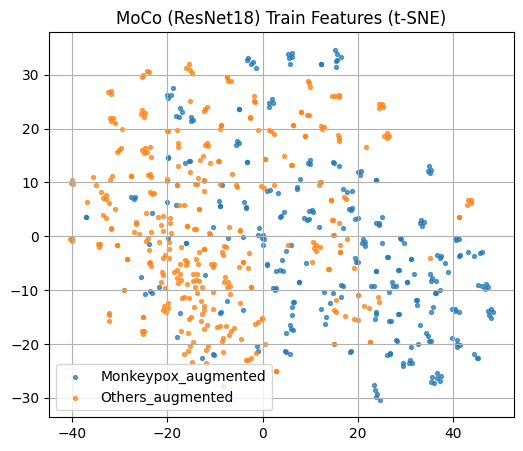

In [10]:
# Cell 10: Build a Plain ResNet-18 Encoder for Visualization + Train Feature t-SNE

# Load encoder for visualization with Identity head (no projection)
encoder_vis = models.resnet18(weights=None)
encoder_vis.fc = nn.Identity()
state = torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"), map_location=DEVICE)

# The saved weights include a projection head (fc) sized PROJ_DIM.
# We load them into a model with Identity fc; only matching layers will load.
missing, unexpected = encoder_vis.load_state_dict(state, strict=False)
# It's normal that 'fc.weight'/'fc.bias' are missing due to Identity.
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

print("Computing t-SNE on TRAIN features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (t-SNE)")
plt.grid(True)
plt.show()


Computing UMAP on TRAIN features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


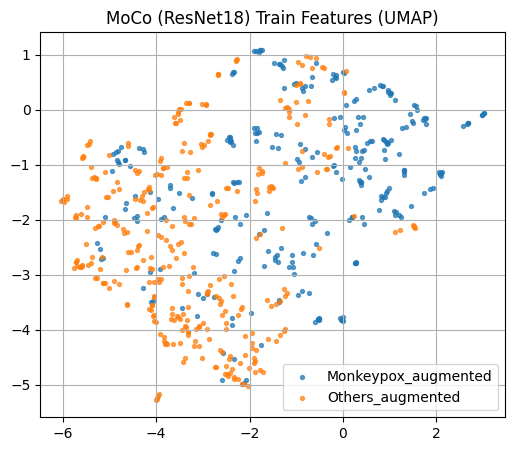

In [11]:
# Cell 11: UMAP on Train Features

print("Computing UMAP on TRAIN features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (UMAP)")
plt.grid(True)
plt.show()


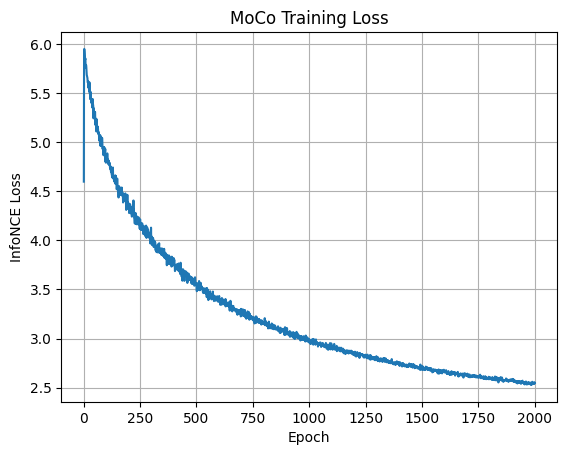

In [12]:
# Cell 12: SSL Loss Curve

plot_curve(moco_loss_history, "MoCo Training Loss", "Epoch", "InfoNCE Loss")


In [13]:
# Cell 13: Linear Evaluation (Train on 20% Train Split)

# Freeze encoder backbone (no projection) for linear eval
encoder_linear = models.resnet18(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"),
                                          map_location=DEVICE), strict=False)
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []   # (we don't have a separate val split here)
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation (training on 20% train split)...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)

        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f}")


Starting linear evaluation (training on 20% train split)...


Linear Epoch 1/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1: TrainLoss=0.6555 Acc=0.602


Linear Epoch 2/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 2: TrainLoss=0.6024 Acc=0.685


Linear Epoch 3/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 3: TrainLoss=0.5647 Acc=0.721


Linear Epoch 4/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 4: TrainLoss=0.5390 Acc=0.745


Linear Epoch 5/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 5: TrainLoss=0.5181 Acc=0.754


Linear Epoch 6/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 6: TrainLoss=0.5034 Acc=0.776


Linear Epoch 7/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 7: TrainLoss=0.4889 Acc=0.774


Linear Epoch 8/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 8: TrainLoss=0.4778 Acc=0.785


Linear Epoch 9/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 9: TrainLoss=0.4667 Acc=0.796


Linear Epoch 10/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 10: TrainLoss=0.4574 Acc=0.809


Linear Epoch 11/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 11: TrainLoss=0.4490 Acc=0.821


Linear Epoch 12/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 12: TrainLoss=0.4419 Acc=0.828


Linear Epoch 13/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 13: TrainLoss=0.4344 Acc=0.832


Linear Epoch 14/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 14: TrainLoss=0.4267 Acc=0.837


Linear Epoch 15/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 15: TrainLoss=0.4204 Acc=0.834


Linear Epoch 16/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 16: TrainLoss=0.4146 Acc=0.837


Linear Epoch 17/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 17: TrainLoss=0.4090 Acc=0.840


Linear Epoch 18/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 18: TrainLoss=0.4036 Acc=0.843


Linear Epoch 19/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 19: TrainLoss=0.3988 Acc=0.848


Linear Epoch 20/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 20: TrainLoss=0.3940 Acc=0.851


Linear Epoch 21/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 21: TrainLoss=0.3895 Acc=0.853


Linear Epoch 22/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 22: TrainLoss=0.3851 Acc=0.857


Linear Epoch 23/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 23: TrainLoss=0.3812 Acc=0.862


Linear Epoch 24/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 24: TrainLoss=0.3772 Acc=0.867


Linear Epoch 25/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 25: TrainLoss=0.3731 Acc=0.868


Linear Epoch 26/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 26: TrainLoss=0.3702 Acc=0.862


Linear Epoch 27/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 27: TrainLoss=0.3662 Acc=0.864


Linear Epoch 28/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 28: TrainLoss=0.3638 Acc=0.871


Linear Epoch 29/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 29: TrainLoss=0.3596 Acc=0.868


Linear Epoch 30/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 30: TrainLoss=0.3570 Acc=0.865


Linear Epoch 31/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 31: TrainLoss=0.3536 Acc=0.868


Linear Epoch 32/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 32: TrainLoss=0.3514 Acc=0.876


Linear Epoch 33/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 33: TrainLoss=0.3480 Acc=0.870


Linear Epoch 34/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 34: TrainLoss=0.3455 Acc=0.870


Linear Epoch 35/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 35: TrainLoss=0.3426 Acc=0.871


Linear Epoch 36/2000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Linear Epoch 36: TrainLoss=0.3401 Acc=0.875


Linear Epoch 37/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 37: TrainLoss=0.3376 Acc=0.873


Linear Epoch 38/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 38: TrainLoss=0.3348 Acc=0.875


Linear Epoch 39/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 39: TrainLoss=0.3324 Acc=0.875


Linear Epoch 40/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 40: TrainLoss=0.3302 Acc=0.876


Linear Epoch 41/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 41: TrainLoss=0.3286 Acc=0.878


Linear Epoch 42/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 42: TrainLoss=0.3263 Acc=0.878


Linear Epoch 43/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 43: TrainLoss=0.3235 Acc=0.881


Linear Epoch 44/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 44: TrainLoss=0.3214 Acc=0.882


Linear Epoch 45/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 45: TrainLoss=0.3195 Acc=0.879


Linear Epoch 46/2000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Linear Epoch 46: TrainLoss=0.3173 Acc=0.886


Linear Epoch 47/2000: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


Linear Epoch 47: TrainLoss=0.3152 Acc=0.889


Linear Epoch 48/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 48: TrainLoss=0.3138 Acc=0.889


Linear Epoch 49/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 49: TrainLoss=0.3117 Acc=0.889


Linear Epoch 50/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 50: TrainLoss=0.3095 Acc=0.890


Linear Epoch 51/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 51: TrainLoss=0.3080 Acc=0.889


Linear Epoch 52/2000: 100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


Linear Epoch 52: TrainLoss=0.3063 Acc=0.892


Linear Epoch 53/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 53: TrainLoss=0.3044 Acc=0.893


Linear Epoch 54/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 54: TrainLoss=0.3026 Acc=0.892


Linear Epoch 55/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 55: TrainLoss=0.3008 Acc=0.895


Linear Epoch 56/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 56: TrainLoss=0.2994 Acc=0.893


Linear Epoch 57/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 57: TrainLoss=0.2978 Acc=0.895


Linear Epoch 58/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 58: TrainLoss=0.2962 Acc=0.895


Linear Epoch 59/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 59: TrainLoss=0.2946 Acc=0.898


Linear Epoch 60/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 60: TrainLoss=0.2932 Acc=0.900


Linear Epoch 61/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 61: TrainLoss=0.2918 Acc=0.897


Linear Epoch 62/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 62: TrainLoss=0.2902 Acc=0.898


Linear Epoch 63/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 63: TrainLoss=0.2886 Acc=0.901


Linear Epoch 64/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 64: TrainLoss=0.2870 Acc=0.898


Linear Epoch 65/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 65: TrainLoss=0.2853 Acc=0.903


Linear Epoch 66/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 66: TrainLoss=0.2843 Acc=0.903


Linear Epoch 67/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 67: TrainLoss=0.2828 Acc=0.903


Linear Epoch 68/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 68: TrainLoss=0.2813 Acc=0.901


Linear Epoch 69/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 69: TrainLoss=0.2803 Acc=0.900


Linear Epoch 70/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 70: TrainLoss=0.2788 Acc=0.903


Linear Epoch 71/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 71: TrainLoss=0.2772 Acc=0.904


Linear Epoch 72/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 72: TrainLoss=0.2759 Acc=0.903


Linear Epoch 73/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 73: TrainLoss=0.2751 Acc=0.903


Linear Epoch 74/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 74: TrainLoss=0.2736 Acc=0.906


Linear Epoch 75/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 75: TrainLoss=0.2724 Acc=0.909


Linear Epoch 76/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 76: TrainLoss=0.2713 Acc=0.908


Linear Epoch 77/2000: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Linear Epoch 77: TrainLoss=0.2698 Acc=0.908


Linear Epoch 78/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 78: TrainLoss=0.2687 Acc=0.908


Linear Epoch 79/2000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


Linear Epoch 79: TrainLoss=0.2677 Acc=0.909


Linear Epoch 80/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 80: TrainLoss=0.2673 Acc=0.908


Linear Epoch 81/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 81: TrainLoss=0.2651 Acc=0.908


Linear Epoch 82/2000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


Linear Epoch 82: TrainLoss=0.2650 Acc=0.912


Linear Epoch 83/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 83: TrainLoss=0.2635 Acc=0.909


Linear Epoch 84/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 84: TrainLoss=0.2620 Acc=0.911


Linear Epoch 85/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 85: TrainLoss=0.2606 Acc=0.911


Linear Epoch 86/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 86: TrainLoss=0.2597 Acc=0.911


Linear Epoch 87/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 87: TrainLoss=0.2588 Acc=0.912


Linear Epoch 88/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 88: TrainLoss=0.2574 Acc=0.914


Linear Epoch 89/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 89: TrainLoss=0.2565 Acc=0.911


Linear Epoch 90/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 90: TrainLoss=0.2553 Acc=0.911


Linear Epoch 91/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 91: TrainLoss=0.2547 Acc=0.911


Linear Epoch 92/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 92: TrainLoss=0.2536 Acc=0.914


Linear Epoch 93/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 93: TrainLoss=0.2525 Acc=0.915


Linear Epoch 94/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 94: TrainLoss=0.2516 Acc=0.911


Linear Epoch 95/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 95: TrainLoss=0.2506 Acc=0.912


Linear Epoch 96/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 96: TrainLoss=0.2494 Acc=0.915


Linear Epoch 97/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 97: TrainLoss=0.2488 Acc=0.915


Linear Epoch 98/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 98: TrainLoss=0.2475 Acc=0.912


Linear Epoch 99/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 99: TrainLoss=0.2466 Acc=0.912


Linear Epoch 100/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 100: TrainLoss=0.2455 Acc=0.914


Linear Epoch 101/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 101: TrainLoss=0.2446 Acc=0.915


Linear Epoch 102/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 102: TrainLoss=0.2440 Acc=0.915


Linear Epoch 103/2000: 100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


Linear Epoch 103: TrainLoss=0.2428 Acc=0.915


Linear Epoch 104/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 104: TrainLoss=0.2419 Acc=0.915


Linear Epoch 105/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 105: TrainLoss=0.2411 Acc=0.917


Linear Epoch 106/2000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Linear Epoch 106: TrainLoss=0.2402 Acc=0.917


Linear Epoch 107/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 107: TrainLoss=0.2392 Acc=0.917


Linear Epoch 108/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 108: TrainLoss=0.2387 Acc=0.915


Linear Epoch 109/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 109: TrainLoss=0.2376 Acc=0.917


Linear Epoch 110/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 110: TrainLoss=0.2366 Acc=0.917


Linear Epoch 111/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 111: TrainLoss=0.2363 Acc=0.922


Linear Epoch 112/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 112: TrainLoss=0.2359 Acc=0.914


Linear Epoch 113/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 113: TrainLoss=0.2340 Acc=0.920


Linear Epoch 114/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 114: TrainLoss=0.2335 Acc=0.917


Linear Epoch 115/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 115: TrainLoss=0.2325 Acc=0.922


Linear Epoch 116/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 116: TrainLoss=0.2316 Acc=0.917


Linear Epoch 117/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 117: TrainLoss=0.2307 Acc=0.918


Linear Epoch 118/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 118: TrainLoss=0.2302 Acc=0.918


Linear Epoch 119/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 119: TrainLoss=0.2294 Acc=0.918


Linear Epoch 120/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 120: TrainLoss=0.2283 Acc=0.922


Linear Epoch 121/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 121: TrainLoss=0.2278 Acc=0.925


Linear Epoch 122/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 122: TrainLoss=0.2268 Acc=0.923


Linear Epoch 123/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 123: TrainLoss=0.2262 Acc=0.922


Linear Epoch 124/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 124: TrainLoss=0.2256 Acc=0.928


Linear Epoch 125/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 125: TrainLoss=0.2246 Acc=0.928


Linear Epoch 126/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 126: TrainLoss=0.2238 Acc=0.926


Linear Epoch 127/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 127: TrainLoss=0.2233 Acc=0.922


Linear Epoch 128/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 128: TrainLoss=0.2222 Acc=0.923


Linear Epoch 129/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 129: TrainLoss=0.2217 Acc=0.931


Linear Epoch 130/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 130: TrainLoss=0.2209 Acc=0.931


Linear Epoch 131/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 131: TrainLoss=0.2202 Acc=0.929


Linear Epoch 132/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 132: TrainLoss=0.2195 Acc=0.934


Linear Epoch 133/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 133: TrainLoss=0.2189 Acc=0.933


Linear Epoch 134/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 134: TrainLoss=0.2179 Acc=0.934


Linear Epoch 135/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 135: TrainLoss=0.2173 Acc=0.933


Linear Epoch 136/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 136: TrainLoss=0.2167 Acc=0.931


Linear Epoch 137/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 137: TrainLoss=0.2157 Acc=0.933


Linear Epoch 138/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 138: TrainLoss=0.2151 Acc=0.936


Linear Epoch 139/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 139: TrainLoss=0.2144 Acc=0.936


Linear Epoch 140/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 140: TrainLoss=0.2140 Acc=0.936


Linear Epoch 141/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 141: TrainLoss=0.2133 Acc=0.937


Linear Epoch 142/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 142: TrainLoss=0.2126 Acc=0.937


Linear Epoch 143/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 143: TrainLoss=0.2117 Acc=0.937


Linear Epoch 144/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 144: TrainLoss=0.2111 Acc=0.939


Linear Epoch 145/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 145: TrainLoss=0.2105 Acc=0.939


Linear Epoch 146/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 146: TrainLoss=0.2096 Acc=0.940


Linear Epoch 147/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 147: TrainLoss=0.2092 Acc=0.942


Linear Epoch 148/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 148: TrainLoss=0.2086 Acc=0.942


Linear Epoch 149/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 149: TrainLoss=0.2078 Acc=0.944


Linear Epoch 150/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 150: TrainLoss=0.2072 Acc=0.944


Linear Epoch 151/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 151: TrainLoss=0.2065 Acc=0.940


Linear Epoch 152/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 152: TrainLoss=0.2058 Acc=0.942


Linear Epoch 153/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 153: TrainLoss=0.2052 Acc=0.942


Linear Epoch 154/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 154: TrainLoss=0.2048 Acc=0.947


Linear Epoch 155/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 155: TrainLoss=0.2041 Acc=0.945


Linear Epoch 156/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 156: TrainLoss=0.2035 Acc=0.947


Linear Epoch 157/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 157: TrainLoss=0.2031 Acc=0.945


Linear Epoch 158/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 158: TrainLoss=0.2039 Acc=0.942


Linear Epoch 159/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 159: TrainLoss=0.2019 Acc=0.945


Linear Epoch 160/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 160: TrainLoss=0.2011 Acc=0.944


Linear Epoch 161/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 161: TrainLoss=0.2003 Acc=0.948


Linear Epoch 162/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 162: TrainLoss=0.1999 Acc=0.948


Linear Epoch 163/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 163: TrainLoss=0.1991 Acc=0.948


Linear Epoch 164/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 164: TrainLoss=0.1992 Acc=0.945


Linear Epoch 165/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 165: TrainLoss=0.1986 Acc=0.947


Linear Epoch 166/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 166: TrainLoss=0.1975 Acc=0.948


Linear Epoch 167/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 167: TrainLoss=0.1970 Acc=0.947


Linear Epoch 168/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 168: TrainLoss=0.1963 Acc=0.948


Linear Epoch 169/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 169: TrainLoss=0.1960 Acc=0.945


Linear Epoch 170/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 170: TrainLoss=0.1952 Acc=0.945


Linear Epoch 171/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 171: TrainLoss=0.1946 Acc=0.948


Linear Epoch 172/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 172: TrainLoss=0.1940 Acc=0.948


Linear Epoch 173/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 173: TrainLoss=0.1936 Acc=0.948


Linear Epoch 174/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 174: TrainLoss=0.1932 Acc=0.947


Linear Epoch 175/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 175: TrainLoss=0.1924 Acc=0.948


Linear Epoch 176/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 176: TrainLoss=0.1922 Acc=0.948


Linear Epoch 177/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 177: TrainLoss=0.1916 Acc=0.948


Linear Epoch 178/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 178: TrainLoss=0.1907 Acc=0.948


Linear Epoch 179/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 179: TrainLoss=0.1903 Acc=0.945


Linear Epoch 180/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 180: TrainLoss=0.1899 Acc=0.948


Linear Epoch 181/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 181: TrainLoss=0.1890 Acc=0.948


Linear Epoch 182/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 182: TrainLoss=0.1887 Acc=0.948


Linear Epoch 183/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 183: TrainLoss=0.1881 Acc=0.948


Linear Epoch 184/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 184: TrainLoss=0.1878 Acc=0.947


Linear Epoch 185/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 185: TrainLoss=0.1870 Acc=0.948


Linear Epoch 186/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 186: TrainLoss=0.1864 Acc=0.950


Linear Epoch 187/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 187: TrainLoss=0.1860 Acc=0.950


Linear Epoch 188/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 188: TrainLoss=0.1856 Acc=0.948


Linear Epoch 189/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 189: TrainLoss=0.1853 Acc=0.950


Linear Epoch 190/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 190: TrainLoss=0.1844 Acc=0.951


Linear Epoch 191/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 191: TrainLoss=0.1843 Acc=0.948


Linear Epoch 192/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 192: TrainLoss=0.1835 Acc=0.950


Linear Epoch 193/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 193: TrainLoss=0.1832 Acc=0.948


Linear Epoch 194/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 194: TrainLoss=0.1824 Acc=0.951


Linear Epoch 195/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 195: TrainLoss=0.1819 Acc=0.951


Linear Epoch 196/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 196: TrainLoss=0.1821 Acc=0.948


Linear Epoch 197/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 197: TrainLoss=0.1811 Acc=0.948


Linear Epoch 198/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 198: TrainLoss=0.1807 Acc=0.950


Linear Epoch 199/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 199: TrainLoss=0.1800 Acc=0.951


Linear Epoch 200/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 200: TrainLoss=0.1795 Acc=0.951


Linear Epoch 201/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 201: TrainLoss=0.1791 Acc=0.951


Linear Epoch 202/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 202: TrainLoss=0.1786 Acc=0.951


Linear Epoch 203/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 203: TrainLoss=0.1780 Acc=0.951


Linear Epoch 204/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 204: TrainLoss=0.1775 Acc=0.951


Linear Epoch 205/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 205: TrainLoss=0.1771 Acc=0.951


Linear Epoch 206/2000: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Linear Epoch 206: TrainLoss=0.1766 Acc=0.953


Linear Epoch 207/2000: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Linear Epoch 207: TrainLoss=0.1762 Acc=0.953


Linear Epoch 208/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 208: TrainLoss=0.1757 Acc=0.953


Linear Epoch 209/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 209: TrainLoss=0.1753 Acc=0.951


Linear Epoch 210/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 210: TrainLoss=0.1748 Acc=0.953


Linear Epoch 211/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 211: TrainLoss=0.1744 Acc=0.951


Linear Epoch 212/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 212: TrainLoss=0.1743 Acc=0.953


Linear Epoch 213/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 213: TrainLoss=0.1736 Acc=0.951


Linear Epoch 214/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 214: TrainLoss=0.1729 Acc=0.951


Linear Epoch 215/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 215: TrainLoss=0.1727 Acc=0.951


Linear Epoch 216/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 216: TrainLoss=0.1719 Acc=0.953


Linear Epoch 217/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 217: TrainLoss=0.1716 Acc=0.953


Linear Epoch 218/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 218: TrainLoss=0.1712 Acc=0.953


Linear Epoch 219/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 219: TrainLoss=0.1708 Acc=0.955


Linear Epoch 220/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 220: TrainLoss=0.1703 Acc=0.951


Linear Epoch 221/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 221: TrainLoss=0.1699 Acc=0.953


Linear Epoch 222/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 222: TrainLoss=0.1696 Acc=0.956


Linear Epoch 223/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 223: TrainLoss=0.1690 Acc=0.953


Linear Epoch 224/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 224: TrainLoss=0.1690 Acc=0.951


Linear Epoch 225/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 225: TrainLoss=0.1682 Acc=0.956


Linear Epoch 226/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 226: TrainLoss=0.1679 Acc=0.955


Linear Epoch 227/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 227: TrainLoss=0.1673 Acc=0.955


Linear Epoch 228/2000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


Linear Epoch 228: TrainLoss=0.1669 Acc=0.955


Linear Epoch 229/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 229: TrainLoss=0.1666 Acc=0.956


Linear Epoch 230/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 230: TrainLoss=0.1659 Acc=0.953


Linear Epoch 231/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 231: TrainLoss=0.1655 Acc=0.955


Linear Epoch 232/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 232: TrainLoss=0.1651 Acc=0.956


Linear Epoch 233/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 233: TrainLoss=0.1650 Acc=0.956


Linear Epoch 234/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 234: TrainLoss=0.1643 Acc=0.958


Linear Epoch 235/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 235: TrainLoss=0.1639 Acc=0.953


Linear Epoch 236/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 236: TrainLoss=0.1638 Acc=0.955


Linear Epoch 237/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 237: TrainLoss=0.1630 Acc=0.958


Linear Epoch 238/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 238: TrainLoss=0.1631 Acc=0.959


Linear Epoch 239/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 239: TrainLoss=0.1623 Acc=0.958


Linear Epoch 240/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 240: TrainLoss=0.1622 Acc=0.956


Linear Epoch 241/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 241: TrainLoss=0.1619 Acc=0.956


Linear Epoch 242/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 242: TrainLoss=0.1611 Acc=0.958


Linear Epoch 243/2000: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


Linear Epoch 243: TrainLoss=0.1606 Acc=0.958


Linear Epoch 244/2000: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


Linear Epoch 244: TrainLoss=0.1604 Acc=0.958


Linear Epoch 245/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 245: TrainLoss=0.1598 Acc=0.958


Linear Epoch 246/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 246: TrainLoss=0.1594 Acc=0.958


Linear Epoch 247/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 247: TrainLoss=0.1589 Acc=0.958


Linear Epoch 248/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 248: TrainLoss=0.1587 Acc=0.958


Linear Epoch 249/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 249: TrainLoss=0.1583 Acc=0.958


Linear Epoch 250/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 250: TrainLoss=0.1580 Acc=0.956


Linear Epoch 251/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 251: TrainLoss=0.1577 Acc=0.958


Linear Epoch 252/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 252: TrainLoss=0.1572 Acc=0.961


Linear Epoch 253/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 253: TrainLoss=0.1569 Acc=0.958


Linear Epoch 254/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 254: TrainLoss=0.1563 Acc=0.959


Linear Epoch 255/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 255: TrainLoss=0.1561 Acc=0.958


Linear Epoch 256/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 256: TrainLoss=0.1556 Acc=0.958


Linear Epoch 257/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 257: TrainLoss=0.1552 Acc=0.959


Linear Epoch 258/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 258: TrainLoss=0.1550 Acc=0.961


Linear Epoch 259/2000: 100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Linear Epoch 259: TrainLoss=0.1547 Acc=0.959


Linear Epoch 260/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 260: TrainLoss=0.1541 Acc=0.961


Linear Epoch 261/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 261: TrainLoss=0.1538 Acc=0.961


Linear Epoch 262/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 262: TrainLoss=0.1534 Acc=0.959


Linear Epoch 263/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 263: TrainLoss=0.1531 Acc=0.962


Linear Epoch 264/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 264: TrainLoss=0.1529 Acc=0.961


Linear Epoch 265/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 265: TrainLoss=0.1523 Acc=0.961


Linear Epoch 266/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 266: TrainLoss=0.1519 Acc=0.961


Linear Epoch 267/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 267: TrainLoss=0.1516 Acc=0.962


Linear Epoch 268/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 268: TrainLoss=0.1516 Acc=0.962


Linear Epoch 269/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 269: TrainLoss=0.1511 Acc=0.962


Linear Epoch 270/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 270: TrainLoss=0.1512 Acc=0.962


Linear Epoch 271/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 271: TrainLoss=0.1502 Acc=0.961


Linear Epoch 272/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 272: TrainLoss=0.1496 Acc=0.962


Linear Epoch 273/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 273: TrainLoss=0.1495 Acc=0.962


Linear Epoch 274/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 274: TrainLoss=0.1491 Acc=0.964


Linear Epoch 275/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 275: TrainLoss=0.1490 Acc=0.964


Linear Epoch 276/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 276: TrainLoss=0.1489 Acc=0.962


Linear Epoch 277/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 277: TrainLoss=0.1483 Acc=0.964


Linear Epoch 278/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 278: TrainLoss=0.1478 Acc=0.964


Linear Epoch 279/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 279: TrainLoss=0.1475 Acc=0.966


Linear Epoch 280/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 280: TrainLoss=0.1471 Acc=0.964


Linear Epoch 281/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 281: TrainLoss=0.1467 Acc=0.962


Linear Epoch 282/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 282: TrainLoss=0.1470 Acc=0.966


Linear Epoch 283/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 283: TrainLoss=0.1464 Acc=0.966


Linear Epoch 284/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 284: TrainLoss=0.1458 Acc=0.964


Linear Epoch 285/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 285: TrainLoss=0.1455 Acc=0.966


Linear Epoch 286/2000: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


Linear Epoch 286: TrainLoss=0.1450 Acc=0.966


Linear Epoch 287/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 287: TrainLoss=0.1446 Acc=0.966


Linear Epoch 288/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 288: TrainLoss=0.1444 Acc=0.966


Linear Epoch 289/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 289: TrainLoss=0.1440 Acc=0.966


Linear Epoch 290/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 290: TrainLoss=0.1437 Acc=0.966


Linear Epoch 291/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 291: TrainLoss=0.1434 Acc=0.966


Linear Epoch 292/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 292: TrainLoss=0.1436 Acc=0.966


Linear Epoch 293/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 293: TrainLoss=0.1426 Acc=0.966


Linear Epoch 294/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 294: TrainLoss=0.1424 Acc=0.966


Linear Epoch 295/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 295: TrainLoss=0.1422 Acc=0.966


Linear Epoch 296/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 296: TrainLoss=0.1418 Acc=0.966


Linear Epoch 297/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 297: TrainLoss=0.1418 Acc=0.967


Linear Epoch 298/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 298: TrainLoss=0.1415 Acc=0.966


Linear Epoch 299/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 299: TrainLoss=0.1407 Acc=0.966


Linear Epoch 300/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 300: TrainLoss=0.1404 Acc=0.966


Linear Epoch 301/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 301: TrainLoss=0.1403 Acc=0.966


Linear Epoch 302/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 302: TrainLoss=0.1400 Acc=0.966


Linear Epoch 303/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 303: TrainLoss=0.1395 Acc=0.966


Linear Epoch 304/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 304: TrainLoss=0.1393 Acc=0.967


Linear Epoch 305/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 305: TrainLoss=0.1390 Acc=0.967


Linear Epoch 306/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 306: TrainLoss=0.1387 Acc=0.966


Linear Epoch 307/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 307: TrainLoss=0.1383 Acc=0.966


Linear Epoch 308/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 308: TrainLoss=0.1379 Acc=0.966


Linear Epoch 309/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 309: TrainLoss=0.1377 Acc=0.967


Linear Epoch 310/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 310: TrainLoss=0.1374 Acc=0.967


Linear Epoch 311/2000: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Linear Epoch 311: TrainLoss=0.1372 Acc=0.967


Linear Epoch 312/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 312: TrainLoss=0.1368 Acc=0.967


Linear Epoch 313/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 313: TrainLoss=0.1369 Acc=0.967


Linear Epoch 314/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 314: TrainLoss=0.1364 Acc=0.967


Linear Epoch 315/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 315: TrainLoss=0.1360 Acc=0.967


Linear Epoch 316/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 316: TrainLoss=0.1357 Acc=0.967


Linear Epoch 317/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 317: TrainLoss=0.1355 Acc=0.967


Linear Epoch 318/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 318: TrainLoss=0.1350 Acc=0.967


Linear Epoch 319/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 319: TrainLoss=0.1348 Acc=0.967


Linear Epoch 320/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 320: TrainLoss=0.1347 Acc=0.969


Linear Epoch 321/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 321: TrainLoss=0.1344 Acc=0.967


Linear Epoch 322/2000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


Linear Epoch 322: TrainLoss=0.1339 Acc=0.967


Linear Epoch 323/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 323: TrainLoss=0.1338 Acc=0.969


Linear Epoch 324/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 324: TrainLoss=0.1333 Acc=0.967


Linear Epoch 325/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 325: TrainLoss=0.1330 Acc=0.967


Linear Epoch 326/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 326: TrainLoss=0.1327 Acc=0.967


Linear Epoch 327/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 327: TrainLoss=0.1326 Acc=0.967


Linear Epoch 328/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 328: TrainLoss=0.1325 Acc=0.967


Linear Epoch 329/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 329: TrainLoss=0.1323 Acc=0.967


Linear Epoch 330/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 330: TrainLoss=0.1316 Acc=0.969


Linear Epoch 331/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 331: TrainLoss=0.1313 Acc=0.969


Linear Epoch 332/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 332: TrainLoss=0.1311 Acc=0.969


Linear Epoch 333/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 333: TrainLoss=0.1308 Acc=0.967


Linear Epoch 334/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 334: TrainLoss=0.1304 Acc=0.969


Linear Epoch 335/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 335: TrainLoss=0.1302 Acc=0.969


Linear Epoch 336/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 336: TrainLoss=0.1299 Acc=0.970


Linear Epoch 337/2000: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Linear Epoch 337: TrainLoss=0.1297 Acc=0.967


Linear Epoch 338/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 338: TrainLoss=0.1295 Acc=0.969


Linear Epoch 339/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 339: TrainLoss=0.1293 Acc=0.969


Linear Epoch 340/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 340: TrainLoss=0.1287 Acc=0.970


Linear Epoch 341/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 341: TrainLoss=0.1287 Acc=0.970


Linear Epoch 342/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 342: TrainLoss=0.1283 Acc=0.970


Linear Epoch 343/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 343: TrainLoss=0.1282 Acc=0.969


Linear Epoch 344/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 344: TrainLoss=0.1277 Acc=0.972


Linear Epoch 345/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 345: TrainLoss=0.1274 Acc=0.970


Linear Epoch 346/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 346: TrainLoss=0.1273 Acc=0.970


Linear Epoch 347/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 347: TrainLoss=0.1272 Acc=0.970


Linear Epoch 348/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 348: TrainLoss=0.1269 Acc=0.970


Linear Epoch 349/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 349: TrainLoss=0.1269 Acc=0.969


Linear Epoch 350/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 350: TrainLoss=0.1260 Acc=0.969


Linear Epoch 351/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 351: TrainLoss=0.1258 Acc=0.970


Linear Epoch 352/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 352: TrainLoss=0.1257 Acc=0.970


Linear Epoch 353/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 353: TrainLoss=0.1255 Acc=0.969


Linear Epoch 354/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 354: TrainLoss=0.1250 Acc=0.972


Linear Epoch 355/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 355: TrainLoss=0.1248 Acc=0.970


Linear Epoch 356/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 356: TrainLoss=0.1249 Acc=0.970


Linear Epoch 357/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 357: TrainLoss=0.1246 Acc=0.972


Linear Epoch 358/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 358: TrainLoss=0.1242 Acc=0.973


Linear Epoch 359/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 359: TrainLoss=0.1237 Acc=0.973


Linear Epoch 360/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 360: TrainLoss=0.1235 Acc=0.973


Linear Epoch 361/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 361: TrainLoss=0.1234 Acc=0.975


Linear Epoch 362/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 362: TrainLoss=0.1229 Acc=0.975


Linear Epoch 363/2000: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Linear Epoch 363: TrainLoss=0.1227 Acc=0.972


Linear Epoch 364/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 364: TrainLoss=0.1226 Acc=0.973


Linear Epoch 365/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 365: TrainLoss=0.1222 Acc=0.975


Linear Epoch 366/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 366: TrainLoss=0.1220 Acc=0.975


Linear Epoch 367/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 367: TrainLoss=0.1219 Acc=0.976


Linear Epoch 368/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 368: TrainLoss=0.1215 Acc=0.976


Linear Epoch 369/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 369: TrainLoss=0.1212 Acc=0.976


Linear Epoch 370/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 370: TrainLoss=0.1211 Acc=0.975


Linear Epoch 371/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 371: TrainLoss=0.1206 Acc=0.976


Linear Epoch 372/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 372: TrainLoss=0.1205 Acc=0.976


Linear Epoch 373/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 373: TrainLoss=0.1202 Acc=0.976


Linear Epoch 374/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 374: TrainLoss=0.1203 Acc=0.975


Linear Epoch 375/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 375: TrainLoss=0.1202 Acc=0.976


Linear Epoch 376/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 376: TrainLoss=0.1195 Acc=0.976


Linear Epoch 377/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 377: TrainLoss=0.1192 Acc=0.976


Linear Epoch 378/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 378: TrainLoss=0.1191 Acc=0.978


Linear Epoch 379/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 379: TrainLoss=0.1189 Acc=0.976


Linear Epoch 380/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 380: TrainLoss=0.1188 Acc=0.976


Linear Epoch 381/2000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Linear Epoch 381: TrainLoss=0.1183 Acc=0.976


Linear Epoch 382/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 382: TrainLoss=0.1185 Acc=0.976


Linear Epoch 383/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 383: TrainLoss=0.1180 Acc=0.976


Linear Epoch 384/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 384: TrainLoss=0.1177 Acc=0.978


Linear Epoch 385/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 385: TrainLoss=0.1173 Acc=0.978


Linear Epoch 386/2000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Linear Epoch 386: TrainLoss=0.1172 Acc=0.976


Linear Epoch 387/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 387: TrainLoss=0.1172 Acc=0.978


Linear Epoch 388/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 388: TrainLoss=0.1167 Acc=0.978


Linear Epoch 389/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 389: TrainLoss=0.1165 Acc=0.978


Linear Epoch 390/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 390: TrainLoss=0.1163 Acc=0.978


Linear Epoch 391/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 391: TrainLoss=0.1161 Acc=0.978


Linear Epoch 392/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 392: TrainLoss=0.1158 Acc=0.978


Linear Epoch 393/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 393: TrainLoss=0.1155 Acc=0.976


Linear Epoch 394/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 394: TrainLoss=0.1153 Acc=0.980


Linear Epoch 395/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 395: TrainLoss=0.1150 Acc=0.978


Linear Epoch 396/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 396: TrainLoss=0.1149 Acc=0.980


Linear Epoch 397/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 397: TrainLoss=0.1146 Acc=0.978


Linear Epoch 398/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 398: TrainLoss=0.1144 Acc=0.980


Linear Epoch 399/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 399: TrainLoss=0.1145 Acc=0.980


Linear Epoch 400/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 400: TrainLoss=0.1138 Acc=0.980


Linear Epoch 401/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 401: TrainLoss=0.1139 Acc=0.978


Linear Epoch 402/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 402: TrainLoss=0.1135 Acc=0.980


Linear Epoch 403/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 403: TrainLoss=0.1133 Acc=0.980


Linear Epoch 404/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 404: TrainLoss=0.1130 Acc=0.980


Linear Epoch 405/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 405: TrainLoss=0.1128 Acc=0.980


Linear Epoch 406/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 406: TrainLoss=0.1125 Acc=0.980


Linear Epoch 407/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 407: TrainLoss=0.1125 Acc=0.980


Linear Epoch 408/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 408: TrainLoss=0.1126 Acc=0.980


Linear Epoch 409/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 409: TrainLoss=0.1119 Acc=0.980


Linear Epoch 410/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 410: TrainLoss=0.1119 Acc=0.981


Linear Epoch 411/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 411: TrainLoss=0.1115 Acc=0.980


Linear Epoch 412/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 412: TrainLoss=0.1114 Acc=0.981


Linear Epoch 413/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 413: TrainLoss=0.1113 Acc=0.980


Linear Epoch 414/2000: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Linear Epoch 414: TrainLoss=0.1110 Acc=0.980


Linear Epoch 415/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 415: TrainLoss=0.1107 Acc=0.981


Linear Epoch 416/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 416: TrainLoss=0.1104 Acc=0.980


Linear Epoch 417/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 417: TrainLoss=0.1103 Acc=0.981


Linear Epoch 418/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 418: TrainLoss=0.1100 Acc=0.980


Linear Epoch 419/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 419: TrainLoss=0.1098 Acc=0.980


Linear Epoch 420/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 420: TrainLoss=0.1096 Acc=0.980


Linear Epoch 421/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 421: TrainLoss=0.1093 Acc=0.980


Linear Epoch 422/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 422: TrainLoss=0.1092 Acc=0.980


Linear Epoch 423/2000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


Linear Epoch 423: TrainLoss=0.1090 Acc=0.980


Linear Epoch 424/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 424: TrainLoss=0.1086 Acc=0.980


Linear Epoch 425/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 425: TrainLoss=0.1085 Acc=0.983


Linear Epoch 426/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 426: TrainLoss=0.1084 Acc=0.981


Linear Epoch 427/2000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


Linear Epoch 427: TrainLoss=0.1080 Acc=0.981


Linear Epoch 428/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 428: TrainLoss=0.1080 Acc=0.981


Linear Epoch 429/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 429: TrainLoss=0.1076 Acc=0.980


Linear Epoch 430/2000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Linear Epoch 430: TrainLoss=0.1075 Acc=0.980


Linear Epoch 431/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 431: TrainLoss=0.1072 Acc=0.981


Linear Epoch 432/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 432: TrainLoss=0.1071 Acc=0.981


Linear Epoch 433/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 433: TrainLoss=0.1069 Acc=0.983


Linear Epoch 434/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 434: TrainLoss=0.1067 Acc=0.981


Linear Epoch 435/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 435: TrainLoss=0.1065 Acc=0.981


Linear Epoch 436/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 436: TrainLoss=0.1068 Acc=0.981


Linear Epoch 437/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 437: TrainLoss=0.1060 Acc=0.983


Linear Epoch 438/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 438: TrainLoss=0.1058 Acc=0.981


Linear Epoch 439/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 439: TrainLoss=0.1056 Acc=0.981


Linear Epoch 440/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 440: TrainLoss=0.1053 Acc=0.981


Linear Epoch 441/2000: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Linear Epoch 441: TrainLoss=0.1054 Acc=0.983


Linear Epoch 442/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 442: TrainLoss=0.1050 Acc=0.983


Linear Epoch 443/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 443: TrainLoss=0.1047 Acc=0.981


Linear Epoch 444/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 444: TrainLoss=0.1046 Acc=0.983


Linear Epoch 445/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 445: TrainLoss=0.1043 Acc=0.984


Linear Epoch 446/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 446: TrainLoss=0.1042 Acc=0.984


Linear Epoch 447/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 447: TrainLoss=0.1042 Acc=0.984


Linear Epoch 448/2000: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


Linear Epoch 448: TrainLoss=0.1038 Acc=0.984


Linear Epoch 449/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 449: TrainLoss=0.1038 Acc=0.983


Linear Epoch 450/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 450: TrainLoss=0.1036 Acc=0.984


Linear Epoch 451/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 451: TrainLoss=0.1033 Acc=0.983


Linear Epoch 452/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 452: TrainLoss=0.1030 Acc=0.983


Linear Epoch 453/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 453: TrainLoss=0.1029 Acc=0.983


Linear Epoch 454/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 454: TrainLoss=0.1026 Acc=0.984


Linear Epoch 455/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 455: TrainLoss=0.1025 Acc=0.984


Linear Epoch 456/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 456: TrainLoss=0.1024 Acc=0.984


Linear Epoch 457/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 457: TrainLoss=0.1021 Acc=0.983


Linear Epoch 458/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 458: TrainLoss=0.1018 Acc=0.984


Linear Epoch 459/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 459: TrainLoss=0.1017 Acc=0.984


Linear Epoch 460/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 460: TrainLoss=0.1014 Acc=0.984


Linear Epoch 461/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 461: TrainLoss=0.1013 Acc=0.984


Linear Epoch 462/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 462: TrainLoss=0.1012 Acc=0.984


Linear Epoch 463/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 463: TrainLoss=0.1010 Acc=0.984


Linear Epoch 464/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 464: TrainLoss=0.1008 Acc=0.984


Linear Epoch 465/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 465: TrainLoss=0.1005 Acc=0.984


Linear Epoch 466/2000: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Linear Epoch 466: TrainLoss=0.1004 Acc=0.984


Linear Epoch 467/2000: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Linear Epoch 467: TrainLoss=0.1003 Acc=0.983


Linear Epoch 468/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 468: TrainLoss=0.1000 Acc=0.984


Linear Epoch 469/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 469: TrainLoss=0.1000 Acc=0.984


Linear Epoch 470/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 470: TrainLoss=0.0998 Acc=0.984


Linear Epoch 471/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 471: TrainLoss=0.0994 Acc=0.986


Linear Epoch 472/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 472: TrainLoss=0.0994 Acc=0.984


Linear Epoch 473/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 473: TrainLoss=0.0991 Acc=0.984


Linear Epoch 474/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 474: TrainLoss=0.0989 Acc=0.984


Linear Epoch 475/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 475: TrainLoss=0.0990 Acc=0.986


Linear Epoch 476/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 476: TrainLoss=0.0984 Acc=0.986


Linear Epoch 477/2000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Linear Epoch 477: TrainLoss=0.0985 Acc=0.984


Linear Epoch 478/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 478: TrainLoss=0.0981 Acc=0.984


Linear Epoch 479/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 479: TrainLoss=0.0980 Acc=0.984


Linear Epoch 480/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 480: TrainLoss=0.0978 Acc=0.987


Linear Epoch 481/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 481: TrainLoss=0.0976 Acc=0.987


Linear Epoch 482/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 482: TrainLoss=0.0974 Acc=0.984


Linear Epoch 483/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 483: TrainLoss=0.0974 Acc=0.984


Linear Epoch 484/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 484: TrainLoss=0.0970 Acc=0.986


Linear Epoch 485/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 485: TrainLoss=0.0969 Acc=0.986


Linear Epoch 486/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 486: TrainLoss=0.0966 Acc=0.986


Linear Epoch 487/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 487: TrainLoss=0.0965 Acc=0.987


Linear Epoch 488/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 488: TrainLoss=0.0964 Acc=0.986


Linear Epoch 489/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 489: TrainLoss=0.0962 Acc=0.987


Linear Epoch 490/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 490: TrainLoss=0.0960 Acc=0.986


Linear Epoch 491/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 491: TrainLoss=0.0959 Acc=0.987


Linear Epoch 492/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 492: TrainLoss=0.0956 Acc=0.987


Linear Epoch 493/2000: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Linear Epoch 493: TrainLoss=0.0955 Acc=0.986


Linear Epoch 494/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 494: TrainLoss=0.0953 Acc=0.986


Linear Epoch 495/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 495: TrainLoss=0.0952 Acc=0.987


Linear Epoch 496/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 496: TrainLoss=0.0951 Acc=0.987


Linear Epoch 497/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 497: TrainLoss=0.0948 Acc=0.987


Linear Epoch 498/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 498: TrainLoss=0.0946 Acc=0.987


Linear Epoch 499/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 499: TrainLoss=0.0944 Acc=0.987


Linear Epoch 500/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 500: TrainLoss=0.0944 Acc=0.986


Linear Epoch 501/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 501: TrainLoss=0.0941 Acc=0.986


Linear Epoch 502/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 502: TrainLoss=0.0940 Acc=0.987


Linear Epoch 503/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 503: TrainLoss=0.0939 Acc=0.987


Linear Epoch 504/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 504: TrainLoss=0.0935 Acc=0.987


Linear Epoch 505/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 505: TrainLoss=0.0934 Acc=0.986


Linear Epoch 506/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 506: TrainLoss=0.0933 Acc=0.987


Linear Epoch 507/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 507: TrainLoss=0.0930 Acc=0.987


Linear Epoch 508/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 508: TrainLoss=0.0929 Acc=0.987


Linear Epoch 509/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 509: TrainLoss=0.0928 Acc=0.987


Linear Epoch 510/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 510: TrainLoss=0.0927 Acc=0.987


Linear Epoch 511/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 511: TrainLoss=0.0924 Acc=0.987


Linear Epoch 512/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 512: TrainLoss=0.0922 Acc=0.987


Linear Epoch 513/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 513: TrainLoss=0.0922 Acc=0.987


Linear Epoch 514/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 514: TrainLoss=0.0917 Acc=0.987


Linear Epoch 515/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 515: TrainLoss=0.0917 Acc=0.987


Linear Epoch 516/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 516: TrainLoss=0.0915 Acc=0.987


Linear Epoch 517/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 517: TrainLoss=0.0914 Acc=0.987


Linear Epoch 518/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 518: TrainLoss=0.0913 Acc=0.987


Linear Epoch 519/2000: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Linear Epoch 519: TrainLoss=0.0910 Acc=0.987


Linear Epoch 520/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 520: TrainLoss=0.0909 Acc=0.987


Linear Epoch 521/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 521: TrainLoss=0.0908 Acc=0.987


Linear Epoch 522/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 522: TrainLoss=0.0910 Acc=0.987


Linear Epoch 523/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 523: TrainLoss=0.0905 Acc=0.987


Linear Epoch 524/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 524: TrainLoss=0.0911 Acc=0.987


Linear Epoch 525/2000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Linear Epoch 525: TrainLoss=0.0903 Acc=0.987


Linear Epoch 526/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 526: TrainLoss=0.0899 Acc=0.987


Linear Epoch 527/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 527: TrainLoss=0.0901 Acc=0.987


Linear Epoch 528/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 528: TrainLoss=0.0895 Acc=0.987


Linear Epoch 529/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 529: TrainLoss=0.0895 Acc=0.987


Linear Epoch 530/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 530: TrainLoss=0.0893 Acc=0.987


Linear Epoch 531/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 531: TrainLoss=0.0891 Acc=0.987


Linear Epoch 532/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 532: TrainLoss=0.0890 Acc=0.987


Linear Epoch 533/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 533: TrainLoss=0.0887 Acc=0.987


Linear Epoch 534/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 534: TrainLoss=0.0887 Acc=0.987


Linear Epoch 535/2000: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


Linear Epoch 535: TrainLoss=0.0885 Acc=0.987


Linear Epoch 536/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 536: TrainLoss=0.0885 Acc=0.987


Linear Epoch 537/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 537: TrainLoss=0.0882 Acc=0.987


Linear Epoch 538/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 538: TrainLoss=0.0880 Acc=0.987


Linear Epoch 539/2000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Linear Epoch 539: TrainLoss=0.0878 Acc=0.987


Linear Epoch 540/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 540: TrainLoss=0.0877 Acc=0.987


Linear Epoch 541/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 541: TrainLoss=0.0875 Acc=0.987


Linear Epoch 542/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 542: TrainLoss=0.0874 Acc=0.987


Linear Epoch 543/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 543: TrainLoss=0.0872 Acc=0.987


Linear Epoch 544/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 544: TrainLoss=0.0870 Acc=0.987


Linear Epoch 545/2000: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Linear Epoch 545: TrainLoss=0.0870 Acc=0.987


Linear Epoch 546/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 546: TrainLoss=0.0867 Acc=0.987


Linear Epoch 547/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 547: TrainLoss=0.0865 Acc=0.987


Linear Epoch 548/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 548: TrainLoss=0.0865 Acc=0.987


Linear Epoch 549/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 549: TrainLoss=0.0870 Acc=0.987


Linear Epoch 550/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 550: TrainLoss=0.0861 Acc=0.987


Linear Epoch 551/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 551: TrainLoss=0.0862 Acc=0.987


Linear Epoch 552/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 552: TrainLoss=0.0859 Acc=0.987


Linear Epoch 553/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 553: TrainLoss=0.0857 Acc=0.987


Linear Epoch 554/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 554: TrainLoss=0.0855 Acc=0.987


Linear Epoch 555/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 555: TrainLoss=0.0854 Acc=0.987


Linear Epoch 556/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 556: TrainLoss=0.0855 Acc=0.987


Linear Epoch 557/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 557: TrainLoss=0.0851 Acc=0.987


Linear Epoch 558/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 558: TrainLoss=0.0849 Acc=0.987


Linear Epoch 559/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 559: TrainLoss=0.0849 Acc=0.987


Linear Epoch 560/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 560: TrainLoss=0.0847 Acc=0.987


Linear Epoch 561/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 561: TrainLoss=0.0845 Acc=0.987


Linear Epoch 562/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 562: TrainLoss=0.0845 Acc=0.987


Linear Epoch 563/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 563: TrainLoss=0.0842 Acc=0.987


Linear Epoch 564/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 564: TrainLoss=0.0842 Acc=0.987


Linear Epoch 565/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 565: TrainLoss=0.0839 Acc=0.987


Linear Epoch 566/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 566: TrainLoss=0.0838 Acc=0.987


Linear Epoch 567/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 567: TrainLoss=0.0836 Acc=0.987


Linear Epoch 568/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 568: TrainLoss=0.0835 Acc=0.987


Linear Epoch 569/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 569: TrainLoss=0.0834 Acc=0.987


Linear Epoch 570/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 570: TrainLoss=0.0832 Acc=0.987


Linear Epoch 571/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 571: TrainLoss=0.0832 Acc=0.987


Linear Epoch 572/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 572: TrainLoss=0.0829 Acc=0.989


Linear Epoch 573/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 573: TrainLoss=0.0828 Acc=0.989


Linear Epoch 574/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 574: TrainLoss=0.0828 Acc=0.987


Linear Epoch 575/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 575: TrainLoss=0.0825 Acc=0.989


Linear Epoch 576/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 576: TrainLoss=0.0824 Acc=0.987


Linear Epoch 577/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 577: TrainLoss=0.0822 Acc=0.987


Linear Epoch 578/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 578: TrainLoss=0.0821 Acc=0.987


Linear Epoch 579/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 579: TrainLoss=0.0826 Acc=0.987


Linear Epoch 580/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 580: TrainLoss=0.0821 Acc=0.987


Linear Epoch 581/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 581: TrainLoss=0.0818 Acc=0.987


Linear Epoch 582/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 582: TrainLoss=0.0816 Acc=0.989


Linear Epoch 583/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 583: TrainLoss=0.0816 Acc=0.987


Linear Epoch 584/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 584: TrainLoss=0.0811 Acc=0.989


Linear Epoch 585/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 585: TrainLoss=0.0810 Acc=0.989


Linear Epoch 586/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 586: TrainLoss=0.0809 Acc=0.989


Linear Epoch 587/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 587: TrainLoss=0.0810 Acc=0.989


Linear Epoch 588/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 588: TrainLoss=0.0806 Acc=0.989


Linear Epoch 589/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 589: TrainLoss=0.0805 Acc=0.989


Linear Epoch 590/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 590: TrainLoss=0.0804 Acc=0.989


Linear Epoch 591/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 591: TrainLoss=0.0802 Acc=0.989


Linear Epoch 592/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 592: TrainLoss=0.0802 Acc=0.989


Linear Epoch 593/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 593: TrainLoss=0.0800 Acc=0.989


Linear Epoch 594/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 594: TrainLoss=0.0798 Acc=0.989


Linear Epoch 595/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 595: TrainLoss=0.0796 Acc=0.989


Linear Epoch 596/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 596: TrainLoss=0.0797 Acc=0.989


Linear Epoch 597/2000: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Linear Epoch 597: TrainLoss=0.0795 Acc=0.989


Linear Epoch 598/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 598: TrainLoss=0.0792 Acc=0.989


Linear Epoch 599/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 599: TrainLoss=0.0791 Acc=0.989


Linear Epoch 600/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 600: TrainLoss=0.0790 Acc=0.989


Linear Epoch 601/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 601: TrainLoss=0.0789 Acc=0.989


Linear Epoch 602/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 602: TrainLoss=0.0787 Acc=0.989


Linear Epoch 603/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 603: TrainLoss=0.0785 Acc=0.989


Linear Epoch 604/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 604: TrainLoss=0.0784 Acc=0.989


Linear Epoch 605/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 605: TrainLoss=0.0783 Acc=0.989


Linear Epoch 606/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 606: TrainLoss=0.0781 Acc=0.989


Linear Epoch 607/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 607: TrainLoss=0.0780 Acc=0.989


Linear Epoch 608/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 608: TrainLoss=0.0779 Acc=0.989


Linear Epoch 609/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 609: TrainLoss=0.0777 Acc=0.989


Linear Epoch 610/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 610: TrainLoss=0.0776 Acc=0.989


Linear Epoch 611/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 611: TrainLoss=0.0775 Acc=0.989


Linear Epoch 612/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 612: TrainLoss=0.0774 Acc=0.989


Linear Epoch 613/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 613: TrainLoss=0.0772 Acc=0.991


Linear Epoch 614/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 614: TrainLoss=0.0773 Acc=0.989


Linear Epoch 615/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 615: TrainLoss=0.0770 Acc=0.989


Linear Epoch 616/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 616: TrainLoss=0.0770 Acc=0.989


Linear Epoch 617/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 617: TrainLoss=0.0768 Acc=0.989


Linear Epoch 618/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 618: TrainLoss=0.0766 Acc=0.989


Linear Epoch 619/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 619: TrainLoss=0.0764 Acc=0.989


Linear Epoch 620/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 620: TrainLoss=0.0763 Acc=0.989


Linear Epoch 621/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 621: TrainLoss=0.0762 Acc=0.991


Linear Epoch 622/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 622: TrainLoss=0.0763 Acc=0.989


Linear Epoch 623/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 623: TrainLoss=0.0760 Acc=0.989


Linear Epoch 624/2000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


Linear Epoch 624: TrainLoss=0.0759 Acc=0.991


Linear Epoch 625/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 625: TrainLoss=0.0756 Acc=0.989


Linear Epoch 626/2000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


Linear Epoch 626: TrainLoss=0.0756 Acc=0.991


Linear Epoch 627/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 627: TrainLoss=0.0754 Acc=0.991


Linear Epoch 628/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 628: TrainLoss=0.0753 Acc=0.989


Linear Epoch 629/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 629: TrainLoss=0.0751 Acc=0.991


Linear Epoch 630/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 630: TrainLoss=0.0750 Acc=0.991


Linear Epoch 631/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 631: TrainLoss=0.0749 Acc=0.989


Linear Epoch 632/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 632: TrainLoss=0.0748 Acc=0.992


Linear Epoch 633/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 633: TrainLoss=0.0746 Acc=0.992


Linear Epoch 634/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 634: TrainLoss=0.0745 Acc=0.991


Linear Epoch 635/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 635: TrainLoss=0.0744 Acc=0.991


Linear Epoch 636/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 636: TrainLoss=0.0742 Acc=0.991


Linear Epoch 637/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 637: TrainLoss=0.0743 Acc=0.989


Linear Epoch 638/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 638: TrainLoss=0.0740 Acc=0.991


Linear Epoch 639/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 639: TrainLoss=0.0741 Acc=0.991


Linear Epoch 640/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 640: TrainLoss=0.0738 Acc=0.991


Linear Epoch 641/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 641: TrainLoss=0.0737 Acc=0.989


Linear Epoch 642/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 642: TrainLoss=0.0735 Acc=0.991


Linear Epoch 643/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 643: TrainLoss=0.0733 Acc=0.992


Linear Epoch 644/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 644: TrainLoss=0.0732 Acc=0.991


Linear Epoch 645/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 645: TrainLoss=0.0731 Acc=0.991


Linear Epoch 646/2000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Linear Epoch 646: TrainLoss=0.0730 Acc=0.991


Linear Epoch 647/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 647: TrainLoss=0.0729 Acc=0.991


Linear Epoch 648/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 648: TrainLoss=0.0729 Acc=0.992


Linear Epoch 649/2000: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Linear Epoch 649: TrainLoss=0.0726 Acc=0.992


Linear Epoch 650/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 650: TrainLoss=0.0725 Acc=0.992


Linear Epoch 651/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 651: TrainLoss=0.0726 Acc=0.991


Linear Epoch 652/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 652: TrainLoss=0.0723 Acc=0.991


Linear Epoch 653/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 653: TrainLoss=0.0722 Acc=0.992


Linear Epoch 654/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 654: TrainLoss=0.0722 Acc=0.992


Linear Epoch 655/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 655: TrainLoss=0.0720 Acc=0.992


Linear Epoch 656/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 656: TrainLoss=0.0718 Acc=0.994


Linear Epoch 657/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 657: TrainLoss=0.0717 Acc=0.994


Linear Epoch 658/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 658: TrainLoss=0.0715 Acc=0.994


Linear Epoch 659/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 659: TrainLoss=0.0715 Acc=0.991


Linear Epoch 660/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 660: TrainLoss=0.0713 Acc=0.992


Linear Epoch 661/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 661: TrainLoss=0.0715 Acc=0.994


Linear Epoch 662/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 662: TrainLoss=0.0712 Acc=0.994


Linear Epoch 663/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 663: TrainLoss=0.0711 Acc=0.991


Linear Epoch 664/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 664: TrainLoss=0.0708 Acc=0.994


Linear Epoch 665/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 665: TrainLoss=0.0707 Acc=0.994


Linear Epoch 666/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 666: TrainLoss=0.0710 Acc=0.991


Linear Epoch 667/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 667: TrainLoss=0.0705 Acc=0.994


Linear Epoch 668/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 668: TrainLoss=0.0704 Acc=0.994


Linear Epoch 669/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 669: TrainLoss=0.0703 Acc=0.994


Linear Epoch 670/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 670: TrainLoss=0.0704 Acc=0.994


Linear Epoch 671/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 671: TrainLoss=0.0702 Acc=0.994


Linear Epoch 672/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 672: TrainLoss=0.0700 Acc=0.994


Linear Epoch 673/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 673: TrainLoss=0.0698 Acc=0.994


Linear Epoch 674/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 674: TrainLoss=0.0697 Acc=0.994


Linear Epoch 675/2000: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Linear Epoch 675: TrainLoss=0.0696 Acc=0.994


Linear Epoch 676/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 676: TrainLoss=0.0696 Acc=0.994


Linear Epoch 677/2000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


Linear Epoch 677: TrainLoss=0.0693 Acc=0.994


Linear Epoch 678/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 678: TrainLoss=0.0693 Acc=0.994


Linear Epoch 679/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 679: TrainLoss=0.0694 Acc=0.994


Linear Epoch 680/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 680: TrainLoss=0.0690 Acc=0.994


Linear Epoch 681/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 681: TrainLoss=0.0688 Acc=0.994


Linear Epoch 682/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 682: TrainLoss=0.0688 Acc=0.994


Linear Epoch 683/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 683: TrainLoss=0.0687 Acc=0.994


Linear Epoch 684/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 684: TrainLoss=0.0685 Acc=0.994


Linear Epoch 685/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 685: TrainLoss=0.0685 Acc=0.994


Linear Epoch 686/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 686: TrainLoss=0.0683 Acc=0.994


Linear Epoch 687/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 687: TrainLoss=0.0683 Acc=0.994


Linear Epoch 688/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 688: TrainLoss=0.0681 Acc=0.994


Linear Epoch 689/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 689: TrainLoss=0.0682 Acc=0.994


Linear Epoch 690/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 690: TrainLoss=0.0679 Acc=0.994


Linear Epoch 691/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 691: TrainLoss=0.0683 Acc=0.994


Linear Epoch 692/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 692: TrainLoss=0.0676 Acc=0.994


Linear Epoch 693/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 693: TrainLoss=0.0676 Acc=0.994


Linear Epoch 694/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 694: TrainLoss=0.0675 Acc=0.994


Linear Epoch 695/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 695: TrainLoss=0.0673 Acc=0.994


Linear Epoch 696/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 696: TrainLoss=0.0675 Acc=0.994


Linear Epoch 697/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 697: TrainLoss=0.0671 Acc=0.994


Linear Epoch 698/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 698: TrainLoss=0.0671 Acc=0.994


Linear Epoch 699/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 699: TrainLoss=0.0670 Acc=0.994


Linear Epoch 700/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 700: TrainLoss=0.0668 Acc=0.994


Linear Epoch 701/2000: 100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Linear Epoch 701: TrainLoss=0.0666 Acc=0.994


Linear Epoch 702/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 702: TrainLoss=0.0665 Acc=0.994


Linear Epoch 703/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 703: TrainLoss=0.0666 Acc=0.994


Linear Epoch 704/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 704: TrainLoss=0.0666 Acc=0.994


Linear Epoch 705/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 705: TrainLoss=0.0663 Acc=0.994


Linear Epoch 706/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 706: TrainLoss=0.0663 Acc=0.994


Linear Epoch 707/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 707: TrainLoss=0.0661 Acc=0.994


Linear Epoch 708/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 708: TrainLoss=0.0660 Acc=0.994


Linear Epoch 709/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 709: TrainLoss=0.0658 Acc=0.994


Linear Epoch 710/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 710: TrainLoss=0.0657 Acc=0.994


Linear Epoch 711/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 711: TrainLoss=0.0656 Acc=0.994


Linear Epoch 712/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 712: TrainLoss=0.0655 Acc=0.994


Linear Epoch 713/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 713: TrainLoss=0.0654 Acc=0.994


Linear Epoch 714/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 714: TrainLoss=0.0655 Acc=0.994


Linear Epoch 715/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 715: TrainLoss=0.0652 Acc=0.994


Linear Epoch 716/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 716: TrainLoss=0.0652 Acc=0.994


Linear Epoch 717/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 717: TrainLoss=0.0651 Acc=0.994


Linear Epoch 718/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 718: TrainLoss=0.0649 Acc=0.994


Linear Epoch 719/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 719: TrainLoss=0.0651 Acc=0.994


Linear Epoch 720/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 720: TrainLoss=0.0650 Acc=0.994


Linear Epoch 721/2000: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


Linear Epoch 721: TrainLoss=0.0645 Acc=0.994


Linear Epoch 722/2000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


Linear Epoch 722: TrainLoss=0.0644 Acc=0.994


Linear Epoch 723/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 723: TrainLoss=0.0643 Acc=0.994


Linear Epoch 724/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 724: TrainLoss=0.0642 Acc=0.994


Linear Epoch 725/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 725: TrainLoss=0.0642 Acc=0.994


Linear Epoch 726/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 726: TrainLoss=0.0641 Acc=0.994


Linear Epoch 727/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 727: TrainLoss=0.0639 Acc=0.994


Linear Epoch 728/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 728: TrainLoss=0.0639 Acc=0.994


Linear Epoch 729/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 729: TrainLoss=0.0639 Acc=0.994


Linear Epoch 730/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 730: TrainLoss=0.0636 Acc=0.994


Linear Epoch 731/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 731: TrainLoss=0.0634 Acc=0.994


Linear Epoch 732/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 732: TrainLoss=0.0634 Acc=0.994


Linear Epoch 733/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 733: TrainLoss=0.0633 Acc=0.994


Linear Epoch 734/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 734: TrainLoss=0.0632 Acc=0.994


Linear Epoch 735/2000: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


Linear Epoch 735: TrainLoss=0.0631 Acc=0.994


Linear Epoch 736/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 736: TrainLoss=0.0630 Acc=0.994


Linear Epoch 737/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 737: TrainLoss=0.0630 Acc=0.994


Linear Epoch 738/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 738: TrainLoss=0.0628 Acc=0.994


Linear Epoch 739/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 739: TrainLoss=0.0628 Acc=0.994


Linear Epoch 740/2000: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Linear Epoch 740: TrainLoss=0.0626 Acc=0.994


Linear Epoch 741/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 741: TrainLoss=0.0624 Acc=0.994


Linear Epoch 742/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 742: TrainLoss=0.0624 Acc=0.994


Linear Epoch 743/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 743: TrainLoss=0.0624 Acc=0.994


Linear Epoch 744/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 744: TrainLoss=0.0622 Acc=0.994


Linear Epoch 745/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 745: TrainLoss=0.0621 Acc=0.994


Linear Epoch 746/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 746: TrainLoss=0.0622 Acc=0.994


Linear Epoch 747/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 747: TrainLoss=0.0618 Acc=0.994


Linear Epoch 748/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 748: TrainLoss=0.0618 Acc=0.994


Linear Epoch 749/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 749: TrainLoss=0.0617 Acc=0.994


Linear Epoch 750/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 750: TrainLoss=0.0616 Acc=0.994


Linear Epoch 751/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 751: TrainLoss=0.0615 Acc=0.994


Linear Epoch 752/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 752: TrainLoss=0.0613 Acc=0.994


Linear Epoch 753/2000: 100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Linear Epoch 753: TrainLoss=0.0614 Acc=0.994


Linear Epoch 754/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 754: TrainLoss=0.0616 Acc=0.994


Linear Epoch 755/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 755: TrainLoss=0.0611 Acc=0.994


Linear Epoch 756/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 756: TrainLoss=0.0609 Acc=0.994


Linear Epoch 757/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 757: TrainLoss=0.0610 Acc=0.994


Linear Epoch 758/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 758: TrainLoss=0.0607 Acc=0.994


Linear Epoch 759/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 759: TrainLoss=0.0607 Acc=0.994


Linear Epoch 760/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 760: TrainLoss=0.0606 Acc=0.994


Linear Epoch 761/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 761: TrainLoss=0.0605 Acc=0.994


Linear Epoch 762/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 762: TrainLoss=0.0604 Acc=0.994


Linear Epoch 763/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 763: TrainLoss=0.0603 Acc=0.994


Linear Epoch 764/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 764: TrainLoss=0.0603 Acc=0.994


Linear Epoch 765/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 765: TrainLoss=0.0602 Acc=0.994


Linear Epoch 766/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 766: TrainLoss=0.0601 Acc=0.994


Linear Epoch 767/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 767: TrainLoss=0.0601 Acc=0.994


Linear Epoch 768/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 768: TrainLoss=0.0598 Acc=0.994


Linear Epoch 769/2000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Linear Epoch 769: TrainLoss=0.0598 Acc=0.994


Linear Epoch 770/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 770: TrainLoss=0.0596 Acc=0.994


Linear Epoch 771/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 771: TrainLoss=0.0595 Acc=0.994


Linear Epoch 772/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 772: TrainLoss=0.0594 Acc=0.994


Linear Epoch 773/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 773: TrainLoss=0.0593 Acc=0.994


Linear Epoch 774/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 774: TrainLoss=0.0592 Acc=0.994


Linear Epoch 775/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 775: TrainLoss=0.0592 Acc=0.994


Linear Epoch 776/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 776: TrainLoss=0.0590 Acc=0.994


Linear Epoch 777/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 777: TrainLoss=0.0589 Acc=0.994


Linear Epoch 778/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 778: TrainLoss=0.0588 Acc=0.994


Linear Epoch 779/2000: 100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Linear Epoch 779: TrainLoss=0.0588 Acc=0.994


Linear Epoch 780/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 780: TrainLoss=0.0587 Acc=0.994


Linear Epoch 781/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 781: TrainLoss=0.0586 Acc=0.994


Linear Epoch 782/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 782: TrainLoss=0.0585 Acc=0.994


Linear Epoch 783/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 783: TrainLoss=0.0584 Acc=0.994


Linear Epoch 784/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 784: TrainLoss=0.0583 Acc=0.994


Linear Epoch 785/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 785: TrainLoss=0.0583 Acc=0.994


Linear Epoch 786/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 786: TrainLoss=0.0582 Acc=0.994


Linear Epoch 787/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 787: TrainLoss=0.0580 Acc=0.994


Linear Epoch 788/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 788: TrainLoss=0.0579 Acc=0.994


Linear Epoch 789/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 789: TrainLoss=0.0578 Acc=0.994


Linear Epoch 790/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 790: TrainLoss=0.0577 Acc=0.994


Linear Epoch 791/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 791: TrainLoss=0.0578 Acc=0.994


Linear Epoch 792/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 792: TrainLoss=0.0575 Acc=0.994


Linear Epoch 793/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 793: TrainLoss=0.0574 Acc=0.994


Linear Epoch 794/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 794: TrainLoss=0.0574 Acc=0.994


Linear Epoch 795/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 795: TrainLoss=0.0574 Acc=0.994


Linear Epoch 796/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 796: TrainLoss=0.0572 Acc=0.994


Linear Epoch 797/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 797: TrainLoss=0.0571 Acc=0.994


Linear Epoch 798/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 798: TrainLoss=0.0570 Acc=0.994


Linear Epoch 799/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 799: TrainLoss=0.0571 Acc=0.994


Linear Epoch 800/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 800: TrainLoss=0.0569 Acc=0.994


Linear Epoch 801/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 801: TrainLoss=0.0569 Acc=0.994


Linear Epoch 802/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 802: TrainLoss=0.0568 Acc=0.994


Linear Epoch 803/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 803: TrainLoss=0.0566 Acc=0.994


Linear Epoch 804/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 804: TrainLoss=0.0564 Acc=0.994


Linear Epoch 805/2000: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Linear Epoch 805: TrainLoss=0.0564 Acc=0.994


Linear Epoch 806/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 806: TrainLoss=0.0563 Acc=0.994


Linear Epoch 807/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 807: TrainLoss=0.0562 Acc=0.994


Linear Epoch 808/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 808: TrainLoss=0.0561 Acc=0.994


Linear Epoch 809/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 809: TrainLoss=0.0560 Acc=0.994


Linear Epoch 810/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 810: TrainLoss=0.0559 Acc=0.994


Linear Epoch 811/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 811: TrainLoss=0.0559 Acc=0.994


Linear Epoch 812/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 812: TrainLoss=0.0557 Acc=0.994


Linear Epoch 813/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 813: TrainLoss=0.0556 Acc=0.994


Linear Epoch 814/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 814: TrainLoss=0.0556 Acc=0.994


Linear Epoch 815/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 815: TrainLoss=0.0554 Acc=0.994


Linear Epoch 816/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 816: TrainLoss=0.0554 Acc=0.994


Linear Epoch 817/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 817: TrainLoss=0.0553 Acc=0.994


Linear Epoch 818/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 818: TrainLoss=0.0552 Acc=0.994


Linear Epoch 819/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 819: TrainLoss=0.0551 Acc=0.994


Linear Epoch 820/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 820: TrainLoss=0.0550 Acc=0.994


Linear Epoch 821/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 821: TrainLoss=0.0550 Acc=0.994


Linear Epoch 822/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 822: TrainLoss=0.0548 Acc=0.994


Linear Epoch 823/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 823: TrainLoss=0.0548 Acc=0.994


Linear Epoch 824/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 824: TrainLoss=0.0548 Acc=0.994


Linear Epoch 825/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 825: TrainLoss=0.0546 Acc=0.994


Linear Epoch 826/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 826: TrainLoss=0.0545 Acc=0.994


Linear Epoch 827/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 827: TrainLoss=0.0545 Acc=0.994


Linear Epoch 828/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 828: TrainLoss=0.0544 Acc=0.994


Linear Epoch 829/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 829: TrainLoss=0.0543 Acc=0.994


Linear Epoch 830/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 830: TrainLoss=0.0542 Acc=0.994


Linear Epoch 831/2000: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Linear Epoch 831: TrainLoss=0.0541 Acc=0.994


Linear Epoch 832/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 832: TrainLoss=0.0540 Acc=0.994


Linear Epoch 833/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 833: TrainLoss=0.0541 Acc=0.994


Linear Epoch 834/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 834: TrainLoss=0.0539 Acc=0.994


Linear Epoch 835/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 835: TrainLoss=0.0538 Acc=0.994


Linear Epoch 836/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 836: TrainLoss=0.0537 Acc=0.994


Linear Epoch 837/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 837: TrainLoss=0.0537 Acc=0.994


Linear Epoch 838/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 838: TrainLoss=0.0536 Acc=0.994


Linear Epoch 839/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 839: TrainLoss=0.0534 Acc=0.994


Linear Epoch 840/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 840: TrainLoss=0.0533 Acc=0.994


Linear Epoch 841/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 841: TrainLoss=0.0532 Acc=0.994


Linear Epoch 842/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 842: TrainLoss=0.0531 Acc=0.994


Linear Epoch 843/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 843: TrainLoss=0.0532 Acc=0.994


Linear Epoch 844/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 844: TrainLoss=0.0529 Acc=0.994


Linear Epoch 845/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 845: TrainLoss=0.0528 Acc=0.994


Linear Epoch 846/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 846: TrainLoss=0.0528 Acc=0.994


Linear Epoch 847/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 847: TrainLoss=0.0527 Acc=0.994


Linear Epoch 848/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 848: TrainLoss=0.0526 Acc=0.994


Linear Epoch 849/2000: 100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Linear Epoch 849: TrainLoss=0.0525 Acc=0.994


Linear Epoch 850/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 850: TrainLoss=0.0525 Acc=0.994


Linear Epoch 851/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 851: TrainLoss=0.0523 Acc=0.994


Linear Epoch 852/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 852: TrainLoss=0.0523 Acc=0.994


Linear Epoch 853/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 853: TrainLoss=0.0523 Acc=0.994


Linear Epoch 854/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 854: TrainLoss=0.0521 Acc=0.994


Linear Epoch 855/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 855: TrainLoss=0.0522 Acc=0.994


Linear Epoch 856/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 856: TrainLoss=0.0522 Acc=0.994


Linear Epoch 857/2000: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Linear Epoch 857: TrainLoss=0.0519 Acc=0.994


Linear Epoch 858/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 858: TrainLoss=0.0518 Acc=0.994


Linear Epoch 859/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 859: TrainLoss=0.0518 Acc=0.994


Linear Epoch 860/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 860: TrainLoss=0.0517 Acc=0.994


Linear Epoch 861/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 861: TrainLoss=0.0516 Acc=0.994


Linear Epoch 862/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 862: TrainLoss=0.0515 Acc=0.994


Linear Epoch 863/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 863: TrainLoss=0.0515 Acc=0.994


Linear Epoch 864/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 864: TrainLoss=0.0513 Acc=0.994


Linear Epoch 865/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 865: TrainLoss=0.0513 Acc=0.994


Linear Epoch 866/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 866: TrainLoss=0.0512 Acc=0.994


Linear Epoch 867/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 867: TrainLoss=0.0511 Acc=0.994


Linear Epoch 868/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 868: TrainLoss=0.0510 Acc=0.994


Linear Epoch 869/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 869: TrainLoss=0.0509 Acc=0.994


Linear Epoch 870/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 870: TrainLoss=0.0508 Acc=0.994


Linear Epoch 871/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 871: TrainLoss=0.0508 Acc=0.994


Linear Epoch 872/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 872: TrainLoss=0.0507 Acc=0.994


Linear Epoch 873/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 873: TrainLoss=0.0505 Acc=0.994


Linear Epoch 874/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 874: TrainLoss=0.0506 Acc=0.994


Linear Epoch 875/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 875: TrainLoss=0.0505 Acc=0.994


Linear Epoch 876/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 876: TrainLoss=0.0505 Acc=0.994


Linear Epoch 877/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 877: TrainLoss=0.0504 Acc=0.994


Linear Epoch 878/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 878: TrainLoss=0.0502 Acc=0.994


Linear Epoch 879/2000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Linear Epoch 879: TrainLoss=0.0502 Acc=0.994


Linear Epoch 880/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 880: TrainLoss=0.0500 Acc=0.994


Linear Epoch 881/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 881: TrainLoss=0.0499 Acc=0.994


Linear Epoch 882/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 882: TrainLoss=0.0498 Acc=0.994


Linear Epoch 883/2000: 100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Linear Epoch 883: TrainLoss=0.0498 Acc=0.994


Linear Epoch 884/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 884: TrainLoss=0.0497 Acc=0.994


Linear Epoch 885/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 885: TrainLoss=0.0496 Acc=0.994


Linear Epoch 886/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 886: TrainLoss=0.0496 Acc=0.994


Linear Epoch 887/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 887: TrainLoss=0.0495 Acc=0.994


Linear Epoch 888/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 888: TrainLoss=0.0494 Acc=0.994


Linear Epoch 889/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 889: TrainLoss=0.0494 Acc=0.994


Linear Epoch 890/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 890: TrainLoss=0.0493 Acc=0.994


Linear Epoch 891/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 891: TrainLoss=0.0492 Acc=0.994


Linear Epoch 892/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 892: TrainLoss=0.0491 Acc=0.994


Linear Epoch 893/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 893: TrainLoss=0.0490 Acc=0.994


Linear Epoch 894/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 894: TrainLoss=0.0489 Acc=0.994


Linear Epoch 895/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 895: TrainLoss=0.0489 Acc=0.994


Linear Epoch 896/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 896: TrainLoss=0.0488 Acc=0.994


Linear Epoch 897/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 897: TrainLoss=0.0487 Acc=0.994


Linear Epoch 898/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 898: TrainLoss=0.0488 Acc=0.995


Linear Epoch 899/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 899: TrainLoss=0.0485 Acc=0.994


Linear Epoch 900/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 900: TrainLoss=0.0486 Acc=0.994


Linear Epoch 901/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 901: TrainLoss=0.0484 Acc=0.994


Linear Epoch 902/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 902: TrainLoss=0.0483 Acc=0.994


Linear Epoch 903/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 903: TrainLoss=0.0482 Acc=0.994


Linear Epoch 904/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 904: TrainLoss=0.0482 Acc=0.995


Linear Epoch 905/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 905: TrainLoss=0.0481 Acc=0.994


Linear Epoch 906/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 906: TrainLoss=0.0481 Acc=0.994


Linear Epoch 907/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 907: TrainLoss=0.0481 Acc=0.994


Linear Epoch 908/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 908: TrainLoss=0.0479 Acc=0.994


Linear Epoch 909/2000: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


Linear Epoch 909: TrainLoss=0.0478 Acc=0.994


Linear Epoch 910/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 910: TrainLoss=0.0479 Acc=0.995


Linear Epoch 911/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 911: TrainLoss=0.0480 Acc=0.994


Linear Epoch 912/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 912: TrainLoss=0.0476 Acc=0.994


Linear Epoch 913/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 913: TrainLoss=0.0476 Acc=0.995


Linear Epoch 914/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 914: TrainLoss=0.0474 Acc=0.995


Linear Epoch 915/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 915: TrainLoss=0.0474 Acc=0.994


Linear Epoch 916/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 916: TrainLoss=0.0473 Acc=0.995


Linear Epoch 917/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 917: TrainLoss=0.0472 Acc=0.995


Linear Epoch 918/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 918: TrainLoss=0.0471 Acc=0.995


Linear Epoch 919/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 919: TrainLoss=0.0471 Acc=0.995


Linear Epoch 920/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 920: TrainLoss=0.0470 Acc=0.995


Linear Epoch 921/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 921: TrainLoss=0.0470 Acc=0.995


Linear Epoch 922/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 922: TrainLoss=0.0468 Acc=0.995


Linear Epoch 923/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 923: TrainLoss=0.0468 Acc=0.995


Linear Epoch 924/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 924: TrainLoss=0.0469 Acc=0.997


Linear Epoch 925/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 925: TrainLoss=0.0467 Acc=0.995


Linear Epoch 926/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 926: TrainLoss=0.0465 Acc=0.995


Linear Epoch 927/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 927: TrainLoss=0.0466 Acc=0.997


Linear Epoch 928/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 928: TrainLoss=0.0464 Acc=0.997


Linear Epoch 929/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 929: TrainLoss=0.0463 Acc=0.995


Linear Epoch 930/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 930: TrainLoss=0.0463 Acc=0.995


Linear Epoch 931/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 931: TrainLoss=0.0464 Acc=0.997


Linear Epoch 932/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 932: TrainLoss=0.0461 Acc=0.997


Linear Epoch 933/2000: 100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Linear Epoch 933: TrainLoss=0.0461 Acc=0.997


Linear Epoch 934/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 934: TrainLoss=0.0460 Acc=0.997


Linear Epoch 935/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 935: TrainLoss=0.0459 Acc=0.997


Linear Epoch 936/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 936: TrainLoss=0.0458 Acc=0.997


Linear Epoch 937/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 937: TrainLoss=0.0457 Acc=0.997


Linear Epoch 938/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 938: TrainLoss=0.0457 Acc=0.997


Linear Epoch 939/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 939: TrainLoss=0.0456 Acc=0.997


Linear Epoch 940/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 940: TrainLoss=0.0455 Acc=0.997


Linear Epoch 941/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 941: TrainLoss=0.0455 Acc=0.995


Linear Epoch 942/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 942: TrainLoss=0.0454 Acc=0.995


Linear Epoch 943/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 943: TrainLoss=0.0454 Acc=0.997


Linear Epoch 944/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 944: TrainLoss=0.0453 Acc=0.997


Linear Epoch 945/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 945: TrainLoss=0.0452 Acc=0.997


Linear Epoch 946/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 946: TrainLoss=0.0451 Acc=0.997


Linear Epoch 947/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 947: TrainLoss=0.0452 Acc=0.997


Linear Epoch 948/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 948: TrainLoss=0.0451 Acc=0.997


Linear Epoch 949/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 949: TrainLoss=0.0449 Acc=0.997


Linear Epoch 950/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 950: TrainLoss=0.0449 Acc=0.997


Linear Epoch 951/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 951: TrainLoss=0.0448 Acc=0.997


Linear Epoch 952/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 952: TrainLoss=0.0447 Acc=0.997


Linear Epoch 953/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 953: TrainLoss=0.0446 Acc=0.997


Linear Epoch 954/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 954: TrainLoss=0.0446 Acc=0.997


Linear Epoch 955/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 955: TrainLoss=0.0447 Acc=0.997


Linear Epoch 956/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 956: TrainLoss=0.0444 Acc=0.997


Linear Epoch 957/2000: 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


Linear Epoch 957: TrainLoss=0.0443 Acc=0.997


Linear Epoch 958/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 958: TrainLoss=0.0443 Acc=0.997


Linear Epoch 959/2000: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


Linear Epoch 959: TrainLoss=0.0442 Acc=0.997


Linear Epoch 960/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 960: TrainLoss=0.0443 Acc=0.997


Linear Epoch 961/2000: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Linear Epoch 961: TrainLoss=0.0441 Acc=0.997


Linear Epoch 962/2000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Linear Epoch 962: TrainLoss=0.0440 Acc=0.997


Linear Epoch 963/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 963: TrainLoss=0.0439 Acc=0.997


Linear Epoch 964/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 964: TrainLoss=0.0439 Acc=0.997


Linear Epoch 965/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 965: TrainLoss=0.0438 Acc=0.997


Linear Epoch 966/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 966: TrainLoss=0.0437 Acc=0.997


Linear Epoch 967/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 967: TrainLoss=0.0436 Acc=0.997


Linear Epoch 968/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 968: TrainLoss=0.0436 Acc=0.997


Linear Epoch 969/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 969: TrainLoss=0.0436 Acc=0.997


Linear Epoch 970/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 970: TrainLoss=0.0435 Acc=0.997


Linear Epoch 971/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 971: TrainLoss=0.0436 Acc=0.997


Linear Epoch 972/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 972: TrainLoss=0.0434 Acc=0.997


Linear Epoch 973/2000: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


Linear Epoch 973: TrainLoss=0.0432 Acc=0.997


Linear Epoch 974/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 974: TrainLoss=0.0432 Acc=0.997


Linear Epoch 975/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 975: TrainLoss=0.0431 Acc=0.997


Linear Epoch 976/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 976: TrainLoss=0.0431 Acc=0.997


Linear Epoch 977/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 977: TrainLoss=0.0430 Acc=0.997


Linear Epoch 978/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 978: TrainLoss=0.0429 Acc=0.997


Linear Epoch 979/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 979: TrainLoss=0.0429 Acc=0.997


Linear Epoch 980/2000: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


Linear Epoch 980: TrainLoss=0.0428 Acc=0.997


Linear Epoch 981/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 981: TrainLoss=0.0427 Acc=0.997


Linear Epoch 982/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 982: TrainLoss=0.0427 Acc=0.997


Linear Epoch 983/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 983: TrainLoss=0.0426 Acc=0.997


Linear Epoch 984/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 984: TrainLoss=0.0426 Acc=0.997


Linear Epoch 985/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 985: TrainLoss=0.0424 Acc=0.997


Linear Epoch 986/2000: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Linear Epoch 986: TrainLoss=0.0424 Acc=0.997


Linear Epoch 987/2000: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Linear Epoch 987: TrainLoss=0.0423 Acc=0.997


Linear Epoch 988/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 988: TrainLoss=0.0422 Acc=0.997


Linear Epoch 989/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 989: TrainLoss=0.0422 Acc=0.997


Linear Epoch 990/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 990: TrainLoss=0.0422 Acc=0.997


Linear Epoch 991/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 991: TrainLoss=0.0422 Acc=0.997


Linear Epoch 992/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 992: TrainLoss=0.0420 Acc=0.997


Linear Epoch 993/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 993: TrainLoss=0.0420 Acc=0.997


Linear Epoch 994/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 994: TrainLoss=0.0418 Acc=0.997


Linear Epoch 995/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 995: TrainLoss=0.0418 Acc=0.997


Linear Epoch 996/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 996: TrainLoss=0.0417 Acc=0.997


Linear Epoch 997/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 997: TrainLoss=0.0417 Acc=0.997


Linear Epoch 998/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 998: TrainLoss=0.0416 Acc=0.997


Linear Epoch 999/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 999: TrainLoss=0.0416 Acc=0.997


Linear Epoch 1000/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1000: TrainLoss=0.0415 Acc=0.997


Linear Epoch 1001/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1001: TrainLoss=0.0414 Acc=0.997


Linear Epoch 1002/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1002: TrainLoss=0.0416 Acc=0.997


Linear Epoch 1003/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1003: TrainLoss=0.0413 Acc=0.997


Linear Epoch 1004/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1004: TrainLoss=0.0413 Acc=0.997


Linear Epoch 1005/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1005: TrainLoss=0.0411 Acc=0.997


Linear Epoch 1006/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1006: TrainLoss=0.0411 Acc=0.997


Linear Epoch 1007/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1007: TrainLoss=0.0411 Acc=0.997


Linear Epoch 1008/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1008: TrainLoss=0.0409 Acc=0.997


Linear Epoch 1009/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1009: TrainLoss=0.0409 Acc=0.997


Linear Epoch 1010/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1010: TrainLoss=0.0408 Acc=0.997


Linear Epoch 1011/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1011: TrainLoss=0.0409 Acc=0.997


Linear Epoch 1012/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1012: TrainLoss=0.0407 Acc=0.997


Linear Epoch 1013/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1013: TrainLoss=0.0406 Acc=0.997


Linear Epoch 1014/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1014: TrainLoss=0.0406 Acc=0.997


Linear Epoch 1015/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1015: TrainLoss=0.0405 Acc=0.997


Linear Epoch 1016/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1016: TrainLoss=0.0406 Acc=0.997


Linear Epoch 1017/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1017: TrainLoss=0.0404 Acc=0.997


Linear Epoch 1018/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1018: TrainLoss=0.0404 Acc=0.997


Linear Epoch 1019/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1019: TrainLoss=0.0403 Acc=0.997


Linear Epoch 1020/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1020: TrainLoss=0.0405 Acc=0.997


Linear Epoch 1021/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1021: TrainLoss=0.0401 Acc=0.997


Linear Epoch 1022/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1022: TrainLoss=0.0402 Acc=0.997


Linear Epoch 1023/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1023: TrainLoss=0.0400 Acc=0.997


Linear Epoch 1024/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1024: TrainLoss=0.0401 Acc=0.997


Linear Epoch 1025/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1025: TrainLoss=0.0399 Acc=0.997


Linear Epoch 1026/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1026: TrainLoss=0.0398 Acc=0.997


Linear Epoch 1027/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1027: TrainLoss=0.0398 Acc=0.997


Linear Epoch 1028/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 1028: TrainLoss=0.0397 Acc=0.997


Linear Epoch 1029/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1029: TrainLoss=0.0396 Acc=0.997


Linear Epoch 1030/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1030: TrainLoss=0.0396 Acc=0.997


Linear Epoch 1031/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1031: TrainLoss=0.0395 Acc=0.997


Linear Epoch 1032/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1032: TrainLoss=0.0395 Acc=0.997


Linear Epoch 1033/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1033: TrainLoss=0.0394 Acc=0.997


Linear Epoch 1034/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1034: TrainLoss=0.0394 Acc=0.997


Linear Epoch 1035/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1035: TrainLoss=0.0393 Acc=0.997


Linear Epoch 1036/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1036: TrainLoss=0.0393 Acc=0.997


Linear Epoch 1037/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1037: TrainLoss=0.0392 Acc=0.997


Linear Epoch 1038/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1038: TrainLoss=0.0391 Acc=0.997


Linear Epoch 1039/2000: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Linear Epoch 1039: TrainLoss=0.0390 Acc=0.997


Linear Epoch 1040/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1040: TrainLoss=0.0390 Acc=0.997


Linear Epoch 1041/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1041: TrainLoss=0.0390 Acc=0.997


Linear Epoch 1042/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1042: TrainLoss=0.0388 Acc=0.997


Linear Epoch 1043/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1043: TrainLoss=0.0388 Acc=0.997


Linear Epoch 1044/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1044: TrainLoss=0.0388 Acc=0.997


Linear Epoch 1045/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1045: TrainLoss=0.0387 Acc=0.998


Linear Epoch 1046/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1046: TrainLoss=0.0386 Acc=0.997


Linear Epoch 1047/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1047: TrainLoss=0.0387 Acc=0.997


Linear Epoch 1048/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1048: TrainLoss=0.0385 Acc=0.997


Linear Epoch 1049/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1049: TrainLoss=0.0385 Acc=0.998


Linear Epoch 1050/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1050: TrainLoss=0.0385 Acc=0.998


Linear Epoch 1051/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1051: TrainLoss=0.0383 Acc=0.998


Linear Epoch 1052/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1052: TrainLoss=0.0382 Acc=0.998


Linear Epoch 1053/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1053: TrainLoss=0.0382 Acc=0.998


Linear Epoch 1054/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1054: TrainLoss=0.0382 Acc=0.998


Linear Epoch 1055/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1055: TrainLoss=0.0382 Acc=0.998


Linear Epoch 1056/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1056: TrainLoss=0.0381 Acc=0.998


Linear Epoch 1057/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1057: TrainLoss=0.0380 Acc=0.998


Linear Epoch 1058/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1058: TrainLoss=0.0379 Acc=0.998


Linear Epoch 1059/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 1059: TrainLoss=0.0379 Acc=0.998


Linear Epoch 1060/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1060: TrainLoss=0.0378 Acc=0.998


Linear Epoch 1061/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1061: TrainLoss=0.0377 Acc=0.998


Linear Epoch 1062/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1062: TrainLoss=0.0377 Acc=0.998


Linear Epoch 1063/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1063: TrainLoss=0.0376 Acc=0.998


Linear Epoch 1064/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1064: TrainLoss=0.0376 Acc=0.998


Linear Epoch 1065/2000: 100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Linear Epoch 1065: TrainLoss=0.0375 Acc=0.998


Linear Epoch 1066/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1066: TrainLoss=0.0374 Acc=0.998


Linear Epoch 1067/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1067: TrainLoss=0.0374 Acc=0.998


Linear Epoch 1068/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1068: TrainLoss=0.0373 Acc=0.998


Linear Epoch 1069/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1069: TrainLoss=0.0373 Acc=0.998


Linear Epoch 1070/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1070: TrainLoss=0.0374 Acc=0.998


Linear Epoch 1071/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1071: TrainLoss=0.0372 Acc=0.998


Linear Epoch 1072/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1072: TrainLoss=0.0371 Acc=0.998


Linear Epoch 1073/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1073: TrainLoss=0.0370 Acc=0.998


Linear Epoch 1074/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1074: TrainLoss=0.0370 Acc=0.998


Linear Epoch 1075/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1075: TrainLoss=0.0369 Acc=0.998


Linear Epoch 1076/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1076: TrainLoss=0.0369 Acc=0.998


Linear Epoch 1077/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1077: TrainLoss=0.0368 Acc=0.998


Linear Epoch 1078/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1078: TrainLoss=0.0368 Acc=0.998


Linear Epoch 1079/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1079: TrainLoss=0.0368 Acc=0.998


Linear Epoch 1080/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 1080: TrainLoss=0.0367 Acc=0.998


Linear Epoch 1081/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1081: TrainLoss=0.0366 Acc=0.998


Linear Epoch 1082/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1082: TrainLoss=0.0366 Acc=0.998


Linear Epoch 1083/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1083: TrainLoss=0.0365 Acc=0.998


Linear Epoch 1084/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1084: TrainLoss=0.0364 Acc=0.998


Linear Epoch 1085/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1085: TrainLoss=0.0364 Acc=0.998


Linear Epoch 1086/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1086: TrainLoss=0.0363 Acc=0.998


Linear Epoch 1087/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1087: TrainLoss=0.0362 Acc=0.998


Linear Epoch 1088/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1088: TrainLoss=0.0362 Acc=0.998


Linear Epoch 1089/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1089: TrainLoss=0.0362 Acc=0.998


Linear Epoch 1090/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1090: TrainLoss=0.0361 Acc=0.998


Linear Epoch 1091/2000: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Linear Epoch 1091: TrainLoss=0.0361 Acc=0.998


Linear Epoch 1092/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1092: TrainLoss=0.0360 Acc=0.998


Linear Epoch 1093/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1093: TrainLoss=0.0360 Acc=0.998


Linear Epoch 1094/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1094: TrainLoss=0.0359 Acc=0.998


Linear Epoch 1095/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1095: TrainLoss=0.0358 Acc=0.998


Linear Epoch 1096/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1096: TrainLoss=0.0358 Acc=0.998


Linear Epoch 1097/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1097: TrainLoss=0.0358 Acc=0.998


Linear Epoch 1098/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1098: TrainLoss=0.0356 Acc=0.998


Linear Epoch 1099/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1099: TrainLoss=0.0357 Acc=0.998


Linear Epoch 1100/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1100: TrainLoss=0.0356 Acc=0.998


Linear Epoch 1101/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1101: TrainLoss=0.0355 Acc=0.998


Linear Epoch 1102/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1102: TrainLoss=0.0357 Acc=0.998


Linear Epoch 1103/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1103: TrainLoss=0.0354 Acc=0.998


Linear Epoch 1104/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1104: TrainLoss=0.0353 Acc=0.998


Linear Epoch 1105/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1105: TrainLoss=0.0353 Acc=0.998


Linear Epoch 1106/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1106: TrainLoss=0.0352 Acc=0.998


Linear Epoch 1107/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1107: TrainLoss=0.0352 Acc=0.998


Linear Epoch 1108/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1108: TrainLoss=0.0351 Acc=0.998


Linear Epoch 1109/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 1109: TrainLoss=0.0351 Acc=0.998


Linear Epoch 1110/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1110: TrainLoss=0.0350 Acc=0.998


Linear Epoch 1111/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1111: TrainLoss=0.0350 Acc=0.998


Linear Epoch 1112/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1112: TrainLoss=0.0349 Acc=0.998


Linear Epoch 1113/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1113: TrainLoss=0.0348 Acc=0.998


Linear Epoch 1114/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1114: TrainLoss=0.0349 Acc=0.998


Linear Epoch 1115/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1115: TrainLoss=0.0348 Acc=0.998


Linear Epoch 1116/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1116: TrainLoss=0.0347 Acc=0.998


Linear Epoch 1117/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 1117: TrainLoss=0.0347 Acc=0.998


Linear Epoch 1118/2000: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Linear Epoch 1118: TrainLoss=0.0346 Acc=0.998


Linear Epoch 1119/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1119: TrainLoss=0.0345 Acc=0.998


Linear Epoch 1120/2000: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


Linear Epoch 1120: TrainLoss=0.0345 Acc=0.998


Linear Epoch 1121/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1121: TrainLoss=0.0345 Acc=0.998


Linear Epoch 1122/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1122: TrainLoss=0.0344 Acc=0.998


Linear Epoch 1123/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1123: TrainLoss=0.0343 Acc=0.998


Linear Epoch 1124/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1124: TrainLoss=0.0343 Acc=0.998


Linear Epoch 1125/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1125: TrainLoss=0.0342 Acc=0.998


Linear Epoch 1126/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1126: TrainLoss=0.0342 Acc=0.998


Linear Epoch 1127/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1127: TrainLoss=0.0342 Acc=0.998


Linear Epoch 1128/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 1128: TrainLoss=0.0340 Acc=0.998


Linear Epoch 1129/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1129: TrainLoss=0.0341 Acc=0.998


Linear Epoch 1130/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1130: TrainLoss=0.0340 Acc=0.998


Linear Epoch 1131/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1131: TrainLoss=0.0339 Acc=0.998


Linear Epoch 1132/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1132: TrainLoss=0.0339 Acc=0.998


Linear Epoch 1133/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1133: TrainLoss=0.0338 Acc=0.998


Linear Epoch 1134/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1134: TrainLoss=0.0338 Acc=0.998


Linear Epoch 1135/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1135: TrainLoss=0.0337 Acc=0.998


Linear Epoch 1136/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1136: TrainLoss=0.0336 Acc=0.998


Linear Epoch 1137/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1137: TrainLoss=0.0337 Acc=0.998


Linear Epoch 1138/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1138: TrainLoss=0.0336 Acc=0.998


Linear Epoch 1139/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1139: TrainLoss=0.0336 Acc=0.998


Linear Epoch 1140/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1140: TrainLoss=0.0335 Acc=0.998


Linear Epoch 1141/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1141: TrainLoss=0.0334 Acc=0.998


Linear Epoch 1142/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 1142: TrainLoss=0.0333 Acc=0.998


Linear Epoch 1143/2000: 100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Linear Epoch 1143: TrainLoss=0.0333 Acc=0.998


Linear Epoch 1144/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1144: TrainLoss=0.0333 Acc=0.998


Linear Epoch 1145/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1145: TrainLoss=0.0333 Acc=0.998


Linear Epoch 1146/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1146: TrainLoss=0.0331 Acc=0.998


Linear Epoch 1147/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1147: TrainLoss=0.0332 Acc=0.998


Linear Epoch 1148/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1148: TrainLoss=0.0330 Acc=0.998


Linear Epoch 1149/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1149: TrainLoss=0.0330 Acc=0.998


Linear Epoch 1150/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1150: TrainLoss=0.0329 Acc=0.998


Linear Epoch 1151/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1151: TrainLoss=0.0329 Acc=0.998


Linear Epoch 1152/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1152: TrainLoss=0.0329 Acc=0.998


Linear Epoch 1153/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1153: TrainLoss=0.0328 Acc=0.998


Linear Epoch 1154/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1154: TrainLoss=0.0329 Acc=0.998


Linear Epoch 1155/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1155: TrainLoss=0.0328 Acc=0.998


Linear Epoch 1156/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1156: TrainLoss=0.0327 Acc=0.998


Linear Epoch 1157/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1157: TrainLoss=0.0327 Acc=0.998


Linear Epoch 1158/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1158: TrainLoss=0.0325 Acc=0.998


Linear Epoch 1159/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 1159: TrainLoss=0.0325 Acc=0.998


Linear Epoch 1160/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1160: TrainLoss=0.0324 Acc=0.998


Linear Epoch 1161/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1161: TrainLoss=0.0324 Acc=0.998


Linear Epoch 1162/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1162: TrainLoss=0.0324 Acc=0.998


Linear Epoch 1163/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1163: TrainLoss=0.0323 Acc=0.998


Linear Epoch 1164/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1164: TrainLoss=0.0322 Acc=0.998


Linear Epoch 1165/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1165: TrainLoss=0.0324 Acc=0.998


Linear Epoch 1166/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1166: TrainLoss=0.0321 Acc=0.998


Linear Epoch 1167/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1167: TrainLoss=0.0322 Acc=0.998


Linear Epoch 1168/2000: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Linear Epoch 1168: TrainLoss=0.0321 Acc=0.998


Linear Epoch 1169/2000: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


Linear Epoch 1169: TrainLoss=0.0320 Acc=0.998


Linear Epoch 1170/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1170: TrainLoss=0.0320 Acc=0.998


Linear Epoch 1171/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1171: TrainLoss=0.0319 Acc=0.998


Linear Epoch 1172/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1172: TrainLoss=0.0319 Acc=0.998


Linear Epoch 1173/2000: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


Linear Epoch 1173: TrainLoss=0.0318 Acc=0.998


Linear Epoch 1174/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1174: TrainLoss=0.0317 Acc=0.998


Linear Epoch 1175/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1175: TrainLoss=0.0318 Acc=0.998


Linear Epoch 1176/2000: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Linear Epoch 1176: TrainLoss=0.0317 Acc=0.998


Linear Epoch 1177/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1177: TrainLoss=0.0316 Acc=0.998


Linear Epoch 1178/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1178: TrainLoss=0.0316 Acc=0.998


Linear Epoch 1179/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1179: TrainLoss=0.0316 Acc=0.998


Linear Epoch 1180/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1180: TrainLoss=0.0315 Acc=0.998


Linear Epoch 1181/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1181: TrainLoss=0.0314 Acc=0.998


Linear Epoch 1182/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1182: TrainLoss=0.0314 Acc=0.998


Linear Epoch 1183/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 1183: TrainLoss=0.0313 Acc=0.998


Linear Epoch 1184/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1184: TrainLoss=0.0313 Acc=0.998


Linear Epoch 1185/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1185: TrainLoss=0.0313 Acc=0.998


Linear Epoch 1186/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1186: TrainLoss=0.0312 Acc=0.998


Linear Epoch 1187/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1187: TrainLoss=0.0312 Acc=0.998


Linear Epoch 1188/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1188: TrainLoss=0.0311 Acc=0.998


Linear Epoch 1189/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1189: TrainLoss=0.0310 Acc=0.998


Linear Epoch 1190/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1190: TrainLoss=0.0310 Acc=0.998


Linear Epoch 1191/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1191: TrainLoss=0.0310 Acc=0.998


Linear Epoch 1192/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1192: TrainLoss=0.0310 Acc=0.998


Linear Epoch 1193/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1193: TrainLoss=0.0309 Acc=0.998


Linear Epoch 1194/2000: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Linear Epoch 1194: TrainLoss=0.0308 Acc=0.998


Linear Epoch 1195/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1195: TrainLoss=0.0308 Acc=0.998


Linear Epoch 1196/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1196: TrainLoss=0.0307 Acc=0.998


Linear Epoch 1197/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1197: TrainLoss=0.0307 Acc=0.998


Linear Epoch 1198/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1198: TrainLoss=0.0307 Acc=0.998


Linear Epoch 1199/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1199: TrainLoss=0.0306 Acc=0.998


Linear Epoch 1200/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1200: TrainLoss=0.0305 Acc=0.998


Linear Epoch 1201/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1201: TrainLoss=0.0305 Acc=0.998


Linear Epoch 1202/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1202: TrainLoss=0.0305 Acc=0.998


Linear Epoch 1203/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1203: TrainLoss=0.0304 Acc=0.998


Linear Epoch 1204/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1204: TrainLoss=0.0303 Acc=0.998


Linear Epoch 1205/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1205: TrainLoss=0.0304 Acc=0.998


Linear Epoch 1206/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1206: TrainLoss=0.0303 Acc=0.998


Linear Epoch 1207/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1207: TrainLoss=0.0302 Acc=0.998


Linear Epoch 1208/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1208: TrainLoss=0.0302 Acc=0.998


Linear Epoch 1209/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1209: TrainLoss=0.0301 Acc=0.998


Linear Epoch 1210/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1210: TrainLoss=0.0301 Acc=0.998


Linear Epoch 1211/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1211: TrainLoss=0.0301 Acc=0.998


Linear Epoch 1212/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1212: TrainLoss=0.0300 Acc=0.998


Linear Epoch 1213/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 1213: TrainLoss=0.0300 Acc=0.998


Linear Epoch 1214/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1214: TrainLoss=0.0299 Acc=0.998


Linear Epoch 1215/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1215: TrainLoss=0.0299 Acc=0.998


Linear Epoch 1216/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1216: TrainLoss=0.0298 Acc=0.998


Linear Epoch 1217/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1217: TrainLoss=0.0298 Acc=0.998


Linear Epoch 1218/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1218: TrainLoss=0.0298 Acc=0.998


Linear Epoch 1219/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1219: TrainLoss=0.0296 Acc=0.998


Linear Epoch 1220/2000: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Linear Epoch 1220: TrainLoss=0.0297 Acc=0.998


Linear Epoch 1221/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1221: TrainLoss=0.0296 Acc=0.998


Linear Epoch 1222/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1222: TrainLoss=0.0295 Acc=0.998


Linear Epoch 1223/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1223: TrainLoss=0.0296 Acc=0.998


Linear Epoch 1224/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1224: TrainLoss=0.0294 Acc=0.998


Linear Epoch 1225/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1225: TrainLoss=0.0294 Acc=0.998


Linear Epoch 1226/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1226: TrainLoss=0.0294 Acc=0.998


Linear Epoch 1227/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1227: TrainLoss=0.0293 Acc=0.998


Linear Epoch 1228/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1228: TrainLoss=0.0293 Acc=0.998


Linear Epoch 1229/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1229: TrainLoss=0.0292 Acc=0.998


Linear Epoch 1230/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1230: TrainLoss=0.0293 Acc=0.998


Linear Epoch 1231/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1231: TrainLoss=0.0291 Acc=0.998


Linear Epoch 1232/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1232: TrainLoss=0.0291 Acc=0.998


Linear Epoch 1233/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1233: TrainLoss=0.0290 Acc=0.998


Linear Epoch 1234/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1234: TrainLoss=0.0291 Acc=0.998


Linear Epoch 1235/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1235: TrainLoss=0.0290 Acc=0.998


Linear Epoch 1236/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1236: TrainLoss=0.0291 Acc=0.998


Linear Epoch 1237/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1237: TrainLoss=0.0288 Acc=0.998


Linear Epoch 1238/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1238: TrainLoss=0.0288 Acc=0.998


Linear Epoch 1239/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1239: TrainLoss=0.0288 Acc=0.998


Linear Epoch 1240/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1240: TrainLoss=0.0287 Acc=0.998


Linear Epoch 1241/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1241: TrainLoss=0.0287 Acc=0.998


Linear Epoch 1242/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1242: TrainLoss=0.0287 Acc=0.998


Linear Epoch 1243/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1243: TrainLoss=0.0286 Acc=0.998


Linear Epoch 1244/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1244: TrainLoss=0.0286 Acc=0.998


Linear Epoch 1245/2000: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


Linear Epoch 1245: TrainLoss=0.0285 Acc=0.998


Linear Epoch 1246/2000: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


Linear Epoch 1246: TrainLoss=0.0285 Acc=0.998


Linear Epoch 1247/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1247: TrainLoss=0.0284 Acc=0.998


Linear Epoch 1248/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1248: TrainLoss=0.0284 Acc=0.998


Linear Epoch 1249/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1249: TrainLoss=0.0284 Acc=0.998


Linear Epoch 1250/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1250: TrainLoss=0.0283 Acc=0.998


Linear Epoch 1251/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 1251: TrainLoss=0.0283 Acc=0.998


Linear Epoch 1252/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1252: TrainLoss=0.0282 Acc=0.998


Linear Epoch 1253/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1253: TrainLoss=0.0282 Acc=0.998


Linear Epoch 1254/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1254: TrainLoss=0.0282 Acc=0.998


Linear Epoch 1255/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1255: TrainLoss=0.0281 Acc=0.998


Linear Epoch 1256/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1256: TrainLoss=0.0280 Acc=0.998


Linear Epoch 1257/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1257: TrainLoss=0.0280 Acc=0.998


Linear Epoch 1258/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1258: TrainLoss=0.0280 Acc=0.998


Linear Epoch 1259/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1259: TrainLoss=0.0279 Acc=0.998


Linear Epoch 1260/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1260: TrainLoss=0.0279 Acc=0.998


Linear Epoch 1261/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1261: TrainLoss=0.0278 Acc=0.998


Linear Epoch 1262/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1262: TrainLoss=0.0279 Acc=0.998


Linear Epoch 1263/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1263: TrainLoss=0.0278 Acc=0.998


Linear Epoch 1264/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1264: TrainLoss=0.0277 Acc=0.998


Linear Epoch 1265/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1265: TrainLoss=0.0277 Acc=0.998


Linear Epoch 1266/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1266: TrainLoss=0.0276 Acc=0.998


Linear Epoch 1267/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1267: TrainLoss=0.0276 Acc=0.998


Linear Epoch 1268/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1268: TrainLoss=0.0276 Acc=0.998


Linear Epoch 1269/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1269: TrainLoss=0.0275 Acc=0.998


Linear Epoch 1270/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1270: TrainLoss=0.0275 Acc=0.998


Linear Epoch 1271/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 1271: TrainLoss=0.0274 Acc=0.998


Linear Epoch 1272/2000: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Linear Epoch 1272: TrainLoss=0.0274 Acc=0.998


Linear Epoch 1273/2000: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Linear Epoch 1273: TrainLoss=0.0274 Acc=0.998


Linear Epoch 1274/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1274: TrainLoss=0.0273 Acc=0.998


Linear Epoch 1275/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1275: TrainLoss=0.0273 Acc=0.998


Linear Epoch 1276/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1276: TrainLoss=0.0272 Acc=0.998


Linear Epoch 1277/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1277: TrainLoss=0.0272 Acc=0.998


Linear Epoch 1278/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1278: TrainLoss=0.0272 Acc=0.998


Linear Epoch 1279/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1279: TrainLoss=0.0271 Acc=0.998


Linear Epoch 1280/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1280: TrainLoss=0.0270 Acc=0.998


Linear Epoch 1281/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1281: TrainLoss=0.0270 Acc=0.998


Linear Epoch 1282/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1282: TrainLoss=0.0270 Acc=0.998


Linear Epoch 1283/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1283: TrainLoss=0.0269 Acc=0.998


Linear Epoch 1284/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1284: TrainLoss=0.0269 Acc=0.998


Linear Epoch 1285/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1285: TrainLoss=0.0268 Acc=0.998


Linear Epoch 1286/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1286: TrainLoss=0.0268 Acc=0.998


Linear Epoch 1287/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1287: TrainLoss=0.0268 Acc=0.998


Linear Epoch 1288/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 1288: TrainLoss=0.0267 Acc=0.998


Linear Epoch 1289/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1289: TrainLoss=0.0267 Acc=0.998


Linear Epoch 1290/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1290: TrainLoss=0.0267 Acc=0.998


Linear Epoch 1291/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1291: TrainLoss=0.0266 Acc=0.998


Linear Epoch 1292/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1292: TrainLoss=0.0268 Acc=0.998


Linear Epoch 1293/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1293: TrainLoss=0.0265 Acc=0.998


Linear Epoch 1294/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1294: TrainLoss=0.0265 Acc=0.998


Linear Epoch 1295/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1295: TrainLoss=0.0265 Acc=0.998


Linear Epoch 1296/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1296: TrainLoss=0.0264 Acc=0.998


Linear Epoch 1297/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1297: TrainLoss=0.0264 Acc=0.998


Linear Epoch 1298/2000: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Linear Epoch 1298: TrainLoss=0.0263 Acc=0.998


Linear Epoch 1299/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1299: TrainLoss=0.0264 Acc=0.998


Linear Epoch 1300/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1300: TrainLoss=0.0263 Acc=0.998


Linear Epoch 1301/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1301: TrainLoss=0.0262 Acc=0.998


Linear Epoch 1302/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1302: TrainLoss=0.0262 Acc=0.998


Linear Epoch 1303/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1303: TrainLoss=0.0262 Acc=0.998


Linear Epoch 1304/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1304: TrainLoss=0.0261 Acc=0.998


Linear Epoch 1305/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1305: TrainLoss=0.0261 Acc=0.998


Linear Epoch 1306/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1306: TrainLoss=0.0260 Acc=0.998


Linear Epoch 1307/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1307: TrainLoss=0.0260 Acc=0.998


Linear Epoch 1308/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1308: TrainLoss=0.0259 Acc=0.998


Linear Epoch 1309/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1309: TrainLoss=0.0259 Acc=0.998


Linear Epoch 1310/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 1310: TrainLoss=0.0258 Acc=0.998


Linear Epoch 1311/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1311: TrainLoss=0.0258 Acc=0.998


Linear Epoch 1312/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1312: TrainLoss=0.0258 Acc=0.998


Linear Epoch 1313/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1313: TrainLoss=0.0257 Acc=0.998


Linear Epoch 1314/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1314: TrainLoss=0.0257 Acc=0.998


Linear Epoch 1315/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1315: TrainLoss=0.0257 Acc=0.998


Linear Epoch 1316/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 1316: TrainLoss=0.0256 Acc=0.998


Linear Epoch 1317/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1317: TrainLoss=0.0256 Acc=0.998


Linear Epoch 1318/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1318: TrainLoss=0.0256 Acc=0.998


Linear Epoch 1319/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1319: TrainLoss=0.0255 Acc=0.998


Linear Epoch 1320/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1320: TrainLoss=0.0256 Acc=0.998


Linear Epoch 1321/2000: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Linear Epoch 1321: TrainLoss=0.0255 Acc=0.998


Linear Epoch 1322/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1322: TrainLoss=0.0254 Acc=0.998


Linear Epoch 1323/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1323: TrainLoss=0.0254 Acc=0.998


Linear Epoch 1324/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 1324: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1325/2000: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Linear Epoch 1325: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1326/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1326: TrainLoss=0.0252 Acc=0.998


Linear Epoch 1327/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1327: TrainLoss=0.0252 Acc=0.998


Linear Epoch 1328/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1328: TrainLoss=0.0252 Acc=0.998


Linear Epoch 1329/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1329: TrainLoss=0.0252 Acc=0.998


Linear Epoch 1330/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1330: TrainLoss=0.0251 Acc=0.998


Linear Epoch 1331/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1331: TrainLoss=0.0251 Acc=0.998


Linear Epoch 1332/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1332: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1333/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1333: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1334/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1334: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1335/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1335: TrainLoss=0.0251 Acc=0.998


Linear Epoch 1336/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1336: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1337/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1337: TrainLoss=0.0249 Acc=0.998


Linear Epoch 1338/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1338: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1339/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1339: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1340/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1340: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1341/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1341: TrainLoss=0.0247 Acc=0.998


Linear Epoch 1342/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1342: TrainLoss=0.0246 Acc=0.998


Linear Epoch 1343/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1343: TrainLoss=0.0246 Acc=0.998


Linear Epoch 1344/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1344: TrainLoss=0.0246 Acc=0.998


Linear Epoch 1345/2000: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Linear Epoch 1345: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1346/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1346: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1347/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1347: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1348/2000: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


Linear Epoch 1348: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1349/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1349: TrainLoss=0.0244 Acc=0.998


Linear Epoch 1350/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1350: TrainLoss=0.0243 Acc=0.998


Linear Epoch 1351/2000: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Linear Epoch 1351: TrainLoss=0.0243 Acc=0.998


Linear Epoch 1352/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1352: TrainLoss=0.0243 Acc=0.998


Linear Epoch 1353/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1353: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1354/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1354: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1355/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1355: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1356/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 1356: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1357/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1357: TrainLoss=0.0241 Acc=0.998


Linear Epoch 1358/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1358: TrainLoss=0.0241 Acc=0.998


Linear Epoch 1359/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1359: TrainLoss=0.0240 Acc=0.998


Linear Epoch 1360/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1360: TrainLoss=0.0240 Acc=0.998


Linear Epoch 1361/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1361: TrainLoss=0.0239 Acc=0.998


Linear Epoch 1362/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1362: TrainLoss=0.0239 Acc=0.998


Linear Epoch 1363/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1363: TrainLoss=0.0239 Acc=0.998


Linear Epoch 1364/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1364: TrainLoss=0.0238 Acc=0.998


Linear Epoch 1365/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1365: TrainLoss=0.0238 Acc=0.998


Linear Epoch 1366/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1366: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1367/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1367: TrainLoss=0.0238 Acc=0.998


Linear Epoch 1368/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1368: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1369/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1369: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1370/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1370: TrainLoss=0.0236 Acc=0.998


Linear Epoch 1371/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1371: TrainLoss=0.0236 Acc=0.998


Linear Epoch 1372/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1372: TrainLoss=0.0236 Acc=0.998


Linear Epoch 1373/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1373: TrainLoss=0.0235 Acc=0.998


Linear Epoch 1374/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1374: TrainLoss=0.0235 Acc=0.998


Linear Epoch 1375/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 1375: TrainLoss=0.0235 Acc=0.998


Linear Epoch 1376/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1376: TrainLoss=0.0234 Acc=0.998


Linear Epoch 1377/2000: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Linear Epoch 1377: TrainLoss=0.0234 Acc=0.998


Linear Epoch 1378/2000: 100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Linear Epoch 1378: TrainLoss=0.0233 Acc=0.998


Linear Epoch 1379/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1379: TrainLoss=0.0233 Acc=0.998


Linear Epoch 1380/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1380: TrainLoss=0.0233 Acc=0.998


Linear Epoch 1381/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1381: TrainLoss=0.0233 Acc=0.998


Linear Epoch 1382/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1382: TrainLoss=0.0232 Acc=0.998


Linear Epoch 1383/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1383: TrainLoss=0.0232 Acc=0.998


Linear Epoch 1384/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1384: TrainLoss=0.0231 Acc=0.998


Linear Epoch 1385/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1385: TrainLoss=0.0231 Acc=0.998


Linear Epoch 1386/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1386: TrainLoss=0.0230 Acc=0.998


Linear Epoch 1387/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1387: TrainLoss=0.0230 Acc=0.998


Linear Epoch 1388/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1388: TrainLoss=0.0230 Acc=0.998


Linear Epoch 1389/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1389: TrainLoss=0.0230 Acc=0.998


Linear Epoch 1390/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1390: TrainLoss=0.0229 Acc=0.998


Linear Epoch 1391/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1391: TrainLoss=0.0229 Acc=0.998


Linear Epoch 1392/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1392: TrainLoss=0.0229 Acc=0.998


Linear Epoch 1393/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1393: TrainLoss=0.0229 Acc=0.998


Linear Epoch 1394/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1394: TrainLoss=0.0228 Acc=0.998


Linear Epoch 1395/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1395: TrainLoss=0.0228 Acc=0.998


Linear Epoch 1396/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1396: TrainLoss=0.0227 Acc=0.998


Linear Epoch 1397/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1397: TrainLoss=0.0227 Acc=0.998


Linear Epoch 1398/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1398: TrainLoss=0.0227 Acc=0.998


Linear Epoch 1399/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1399: TrainLoss=0.0226 Acc=0.998


Linear Epoch 1400/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1400: TrainLoss=0.0227 Acc=0.998


Linear Epoch 1401/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1401: TrainLoss=0.0227 Acc=0.998


Linear Epoch 1402/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1402: TrainLoss=0.0225 Acc=0.998


Linear Epoch 1403/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1403: TrainLoss=0.0225 Acc=0.998


Linear Epoch 1404/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 1404: TrainLoss=0.0224 Acc=0.998


Linear Epoch 1405/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1405: TrainLoss=0.0224 Acc=0.998


Linear Epoch 1406/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1406: TrainLoss=0.0224 Acc=0.998


Linear Epoch 1407/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1407: TrainLoss=0.0223 Acc=0.998


Linear Epoch 1408/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1408: TrainLoss=0.0224 Acc=0.998


Linear Epoch 1409/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1409: TrainLoss=0.0223 Acc=0.998


Linear Epoch 1410/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 1410: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1411/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1411: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1412/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1412: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1413/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1413: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1414/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1414: TrainLoss=0.0221 Acc=0.998


Linear Epoch 1415/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1415: TrainLoss=0.0221 Acc=0.998


Linear Epoch 1416/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1416: TrainLoss=0.0220 Acc=0.998


Linear Epoch 1417/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1417: TrainLoss=0.0220 Acc=0.998


Linear Epoch 1418/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1418: TrainLoss=0.0220 Acc=0.998


Linear Epoch 1419/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1419: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1420/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1420: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1421/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1421: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1422/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1422: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1423/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1423: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1424/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1424: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1425/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1425: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1426/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1426: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1427/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1427: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1428/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1428: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1429/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1429: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1430/2000: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Linear Epoch 1430: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1431/2000: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Linear Epoch 1431: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1432/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1432: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1433/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1433: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1434/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1434: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1435/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1435: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1436/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1436: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1437/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1437: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1438/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1438: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1439/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1439: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1440/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1440: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1441/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1441: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1442/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1442: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1443/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 1443: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1444/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1444: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1445/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1445: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1446/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1446: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1447/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1447: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1448/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1448: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1449/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1449: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1450/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1450: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1451/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1451: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1452/2000: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Linear Epoch 1452: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1453/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 1453: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1454/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1454: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1455/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1455: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1456/2000: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Linear Epoch 1456: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1457/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1457: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1458/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1458: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1459/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1459: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1460/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1460: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1461/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1461: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1462/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1462: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1463/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1463: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1464/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1464: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1465/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 1465: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1466/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1466: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1467/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1467: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1468/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1468: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1469/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1469: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1470/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1470: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1471/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1471: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1472/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1472: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1473/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1473: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1474/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1474: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1475/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 1475: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1476/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1476: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1477/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1477: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1478/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1478: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1479/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1479: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1480/2000: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


Linear Epoch 1480: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1481/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 1481: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1482/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1482: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1483/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1483: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1484/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1484: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1485/2000: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Linear Epoch 1485: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1486/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1486: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1487/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1487: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1488/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1488: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1489/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1489: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1490/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1490: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1491/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1491: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1492/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1492: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1493/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1493: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1494/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1494: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1495/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1495: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1496/2000: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Linear Epoch 1496: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1497/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1497: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1498/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1498: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1499/2000: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


Linear Epoch 1499: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1500/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1500: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1501/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1501: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1502/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1502: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1503/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1503: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1504/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1504: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1505/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1505: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1506/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1506: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1507/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1507: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1508/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1508: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1509/2000: 100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Linear Epoch 1509: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1510/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1510: TrainLoss=0.0192 Acc=1.000


Linear Epoch 1511/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1511: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1512/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1512: TrainLoss=0.0191 Acc=0.998


Linear Epoch 1513/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1513: TrainLoss=0.0191 Acc=1.000


Linear Epoch 1514/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1514: TrainLoss=0.0190 Acc=1.000


Linear Epoch 1515/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1515: TrainLoss=0.0190 Acc=1.000


Linear Epoch 1516/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1516: TrainLoss=0.0190 Acc=1.000


Linear Epoch 1517/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1517: TrainLoss=0.0190 Acc=1.000


Linear Epoch 1518/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1518: TrainLoss=0.0189 Acc=1.000


Linear Epoch 1519/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1519: TrainLoss=0.0189 Acc=1.000


Linear Epoch 1520/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1520: TrainLoss=0.0189 Acc=1.000


Linear Epoch 1521/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 1521: TrainLoss=0.0188 Acc=1.000


Linear Epoch 1522/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1522: TrainLoss=0.0188 Acc=1.000


Linear Epoch 1523/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1523: TrainLoss=0.0188 Acc=1.000


Linear Epoch 1524/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1524: TrainLoss=0.0187 Acc=1.000


Linear Epoch 1525/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1525: TrainLoss=0.0187 Acc=1.000


Linear Epoch 1526/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1526: TrainLoss=0.0187 Acc=1.000


Linear Epoch 1527/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1527: TrainLoss=0.0187 Acc=1.000


Linear Epoch 1528/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1528: TrainLoss=0.0187 Acc=1.000


Linear Epoch 1529/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1529: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1530/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1530: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1531/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1531: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1532/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1532: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1533/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1533: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1534/2000: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Linear Epoch 1534: TrainLoss=0.0185 Acc=1.000


Linear Epoch 1535/2000: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Linear Epoch 1535: TrainLoss=0.0185 Acc=1.000


Linear Epoch 1536/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1536: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1537/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1537: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1538/2000: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Linear Epoch 1538: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1539/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1539: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1540/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1540: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1541/2000: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Linear Epoch 1541: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1542/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1542: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1543/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 1543: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1544/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1544: TrainLoss=0.0182 Acc=1.000


Linear Epoch 1545/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1545: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1546/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1546: TrainLoss=0.0182 Acc=1.000


Linear Epoch 1547/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1547: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1548/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1548: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1549/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1549: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1550/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1550: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1551/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1551: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1552/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1552: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1553/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1553: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1554/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1554: TrainLoss=0.0179 Acc=1.000


Linear Epoch 1555/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1555: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1556/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1556: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1557/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1557: TrainLoss=0.0179 Acc=1.000


Linear Epoch 1558/2000: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Linear Epoch 1558: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1559/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1559: TrainLoss=0.0179 Acc=1.000


Linear Epoch 1560/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1560: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1561/2000: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Linear Epoch 1561: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1562/2000: 100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Linear Epoch 1562: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1563/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1563: TrainLoss=0.0177 Acc=1.000


Linear Epoch 1564/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1564: TrainLoss=0.0177 Acc=1.000


Linear Epoch 1565/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1565: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1566/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1566: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1567/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1567: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1568/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1568: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1569/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1569: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1570/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1570: TrainLoss=0.0175 Acc=1.000


Linear Epoch 1571/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1571: TrainLoss=0.0175 Acc=1.000


Linear Epoch 1572/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1572: TrainLoss=0.0175 Acc=1.000


Linear Epoch 1573/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1573: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1574/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1574: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1575/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1575: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1576/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1576: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1577/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1577: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1578/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1578: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1579/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1579: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1580/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1580: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1581/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 1581: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1582/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1582: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1583/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1583: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1584/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1584: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1585/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1585: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1586/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1586: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1587/2000: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Linear Epoch 1587: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1588/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1588: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1589/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1589: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1590/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1590: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1591/2000: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Linear Epoch 1591: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1592/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1592: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1593/2000: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Linear Epoch 1593: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1594/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1594: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1595/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1595: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1596/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1596: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1597/2000: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Linear Epoch 1597: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1598/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1598: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1599/2000: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]


Linear Epoch 1599: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1600/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1600: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1601/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1601: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1602/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1602: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1603/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1603: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1604/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1604: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1605/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1605: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1606/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1606: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1607/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1607: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1608/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1608: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1609/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1609: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1610/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1610: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1611/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1611: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1612/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1612: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1613/2000: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Linear Epoch 1613: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1614/2000: 100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


Linear Epoch 1614: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1615/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1615: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1616/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 1616: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1617/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1617: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1618/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1618: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1619/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1619: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1620/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1620: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1621/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1621: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1622/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1622: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1623/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1623: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1624/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1624: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1625/2000: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Linear Epoch 1625: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1626/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1626: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1627/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1627: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1628/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1628: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1629/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1629: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1630/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1630: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1631/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1631: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1632/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1632: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1633/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1633: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1634/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1634: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1635/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1635: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1636/2000: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Linear Epoch 1636: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1637/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1637: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1638/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1638: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1639/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1639: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1640/2000: 100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Linear Epoch 1640: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1641/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1641: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1642/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1642: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1643/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1643: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1644/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 1644: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1645/2000: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


Linear Epoch 1645: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1646/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1646: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1647/2000: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


Linear Epoch 1647: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1648/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1648: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1649/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1649: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1650/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1650: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1651/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1651: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1652/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1652: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1653/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1653: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1654/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1654: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1655/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1655: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1656/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1656: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1657/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1657: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1658/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1658: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1659/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1659: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1660/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1660: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1661/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1661: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1662/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1662: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1663/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1663: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1664/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1664: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1665/2000: 100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Linear Epoch 1665: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1666/2000: 100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Linear Epoch 1666: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1667/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1667: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1668/2000: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Linear Epoch 1668: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1669/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1669: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1670/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1670: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1671/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1671: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1672/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1672: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1673/2000: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Linear Epoch 1673: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1674/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1674: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1675/2000: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Linear Epoch 1675: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1676/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1676: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1677/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1677: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1678/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1678: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1679/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1679: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1680/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1680: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1681/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1681: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1682/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1682: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1683/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 1683: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1684/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1684: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1685/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1685: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1686/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1686: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1687/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1687: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1688/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1688: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1689/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1689: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1690/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1690: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1691/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1691: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1692/2000: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Linear Epoch 1692: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1693/2000: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Linear Epoch 1693: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1694/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1694: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1695/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1695: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1696/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1696: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1697/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1697: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1698/2000: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


Linear Epoch 1698: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1699/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1699: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1700/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1700: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1701/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1701: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1702/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1702: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1703/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1703: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1704/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1704: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1705/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1705: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1706/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1706: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1707/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1707: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1708/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1708: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1709/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1709: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1710/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1710: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1711/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1711: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1712/2000: 100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Linear Epoch 1712: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1713/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1713: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1714/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1714: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1715/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1715: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1716/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1716: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1717/2000: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Linear Epoch 1717: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1718/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 1718: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1719/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1719: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1720/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1720: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1721/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1721: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1722/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1722: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1723/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1723: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1724/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1724: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1725/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1725: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1726/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1726: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1727/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1727: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1728/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1728: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1729/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1729: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1730/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1730: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1731/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1731: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1732/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1732: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1733/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1733: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1734/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1734: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1735/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1735: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1736/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1736: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1737/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1737: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1738/2000: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


Linear Epoch 1738: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1739/2000: 100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Linear Epoch 1739: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1740/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1740: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1741/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1741: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1742/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1742: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1743/2000: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


Linear Epoch 1743: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1744/2000: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Linear Epoch 1744: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1745/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1745: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1746/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1746: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1747/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1747: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1748/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1748: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1749/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1749: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1750/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1750: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1751/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1751: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1752/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1752: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1753/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1753: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1754/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1754: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1755/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1755: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1756/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1756: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1757/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1757: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1758/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1758: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1759/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1759: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1760/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1760: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1761/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1761: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1762/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1762: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1763/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1763: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1764/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1764: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1765/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1765: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1766/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1766: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1767/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1767: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1768/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1768: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1769/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1769: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1770/2000: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Linear Epoch 1770: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1771/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1771: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1772/2000: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Linear Epoch 1772: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1773/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1773: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1774/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1774: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1775/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1775: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1776/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1776: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1777/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1777: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1778/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1778: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1779/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1779: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1780/2000: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Linear Epoch 1780: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1781/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1781: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1782/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1782: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1783/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1783: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1784/2000: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Linear Epoch 1784: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1785/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1785: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1786/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1786: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1787/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1787: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1788/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1788: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1789/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1789: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1790/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1790: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1791/2000: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Linear Epoch 1791: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1792/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1792: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1793/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1793: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1794/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1794: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1795/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1795: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1796/2000: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


Linear Epoch 1796: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1797/2000: 100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Linear Epoch 1797: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1798/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1798: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1799/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1799: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1800/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1800: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1801/2000: 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


Linear Epoch 1801: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1802/2000: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Linear Epoch 1802: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1803/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1803: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1804/2000: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Linear Epoch 1804: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1805/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1805: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1806/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1806: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1807/2000: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Linear Epoch 1807: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1808/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1808: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1809/2000: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Linear Epoch 1809: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1810/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1810: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1811/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1811: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1812/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1812: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1813/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1813: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1814/2000: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Linear Epoch 1814: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1815/2000: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Linear Epoch 1815: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1816/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1816: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1817/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1817: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1818/2000: 100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Linear Epoch 1818: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1819/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1819: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1820/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1820: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1821/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1821: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1822/2000: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Linear Epoch 1822: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1823/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1823: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1824/2000: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Linear Epoch 1824: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1825/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1825: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1826/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 1826: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1827/2000: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Linear Epoch 1827: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1828/2000: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Linear Epoch 1828: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1829/2000: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Linear Epoch 1829: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1830/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1830: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1831/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1831: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1832/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1832: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1833/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1833: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1834/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1834: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1835/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1835: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1836/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1836: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1837/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1837: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1838/2000: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Linear Epoch 1838: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1839/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1839: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1840/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1840: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1841/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1841: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1842/2000: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Linear Epoch 1842: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1843/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1843: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1844/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1844: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1845/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1845: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1846/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1846: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1847/2000: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Linear Epoch 1847: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1848/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1848: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1849/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1849: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1850/2000: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Linear Epoch 1850: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1851/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1851: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1852/2000: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Linear Epoch 1852: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1853/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1853: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1854/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1854: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1855/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1855: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1856/2000: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


Linear Epoch 1856: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1857/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1857: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1858/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1858: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1859/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1859: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1860/2000: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


Linear Epoch 1860: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1861/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1861: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1862/2000: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Linear Epoch 1862: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1863/2000: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Linear Epoch 1863: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1864/2000: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Linear Epoch 1864: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1865/2000: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Linear Epoch 1865: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1866/2000: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Linear Epoch 1866: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1867/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1867: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1868/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1868: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1869/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1869: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1870/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1870: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1871/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1871: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1872/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1872: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1873/2000: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Linear Epoch 1873: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1874/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1874: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1875/2000: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


Linear Epoch 1875: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1876/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1876: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1877/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1877: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1878/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1878: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1879/2000: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


Linear Epoch 1879: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1880/2000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Linear Epoch 1880: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1881/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1881: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1882/2000: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Linear Epoch 1882: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1883/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1883: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1884/2000: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Linear Epoch 1884: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1885/2000: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Linear Epoch 1885: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1886/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1886: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1887/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1887: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1888/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1888: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1889/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1889: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1890/2000: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Linear Epoch 1890: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1891/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1891: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1892/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1892: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1893/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1893: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1894/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1894: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1895/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1895: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1896/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1896: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1897/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1897: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1898/2000: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]


Linear Epoch 1898: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1899/2000: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


Linear Epoch 1899: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1900/2000: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


Linear Epoch 1900: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1901/2000: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Linear Epoch 1901: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1902/2000: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Linear Epoch 1902: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1903/2000: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Linear Epoch 1903: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1904/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1904: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1905/2000: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Linear Epoch 1905: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1906/2000: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Linear Epoch 1906: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1907/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1907: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1908/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Linear Epoch 1908: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1909/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1909: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1910/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1910: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1911/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1911: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1912/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1912: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1913/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1913: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1914/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1914: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1915/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1915: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1916/2000: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Linear Epoch 1916: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1917/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1917: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1918/2000: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Linear Epoch 1918: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1919/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1919: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1920/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1920: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1921/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1921: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1922/2000: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Linear Epoch 1922: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1923/2000: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Linear Epoch 1923: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1924/2000: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


Linear Epoch 1924: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1925/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1925: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1926/2000: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Linear Epoch 1926: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1927/2000: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]


Linear Epoch 1927: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1928/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1928: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1929/2000: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Linear Epoch 1929: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1930/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1930: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1931/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1931: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1932/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1932: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1933/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1933: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1934/2000: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Linear Epoch 1934: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1935/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1935: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1936/2000: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Linear Epoch 1936: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1937/2000: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Linear Epoch 1937: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1938/2000: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Linear Epoch 1938: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1939/2000: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Linear Epoch 1939: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1940/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1940: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1941/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1941: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1942/2000: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Linear Epoch 1942: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1943/2000: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


Linear Epoch 1943: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1944/2000: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Linear Epoch 1944: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1945/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1945: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1946/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1946: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1947/2000: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Linear Epoch 1947: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1948/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1948: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1949/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1949: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1950/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1950: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1951/2000: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Linear Epoch 1951: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1952/2000: 100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


Linear Epoch 1952: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1953/2000: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Linear Epoch 1953: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1954/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1954: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1955/2000: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Linear Epoch 1955: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1956/2000: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Linear Epoch 1956: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1957/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1957: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1958/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1958: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1959/2000: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Linear Epoch 1959: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1960/2000: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Linear Epoch 1960: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1961/2000: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Linear Epoch 1961: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1962/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1962: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1963/2000: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Linear Epoch 1963: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1964/2000: 100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Linear Epoch 1964: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1965/2000: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Linear Epoch 1965: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1966/2000: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Linear Epoch 1966: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1967/2000: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Linear Epoch 1967: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1968/2000: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Linear Epoch 1968: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1969/2000: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Linear Epoch 1969: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1970/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1970: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1971/2000: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Linear Epoch 1971: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1972/2000: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Linear Epoch 1972: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1973/2000: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Linear Epoch 1973: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1974/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 1974: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1975/2000: 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Linear Epoch 1975: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1976/2000: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s]


Linear Epoch 1976: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1977/2000: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Linear Epoch 1977: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1978/2000: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Linear Epoch 1978: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1979/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1979: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1980/2000: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Linear Epoch 1980: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1981/2000: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Linear Epoch 1981: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1982/2000: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Linear Epoch 1982: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1983/2000: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Linear Epoch 1983: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1984/2000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Linear Epoch 1984: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1985/2000: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Linear Epoch 1985: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1986/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1986: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1987/2000: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Linear Epoch 1987: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1988/2000: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


Linear Epoch 1988: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1989/2000: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Linear Epoch 1989: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1990/2000: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Linear Epoch 1990: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1991/2000: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


Linear Epoch 1991: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1992/2000: 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


Linear Epoch 1992: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1993/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1993: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1994/2000: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Linear Epoch 1994: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1995/2000: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Linear Epoch 1995: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1996/2000: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Linear Epoch 1996: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1997/2000: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Linear Epoch 1997: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1998/2000: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Linear Epoch 1998: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1999/2000: 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]


Linear Epoch 1999: TrainLoss=0.0093 Acc=1.000


Linear Epoch 2000/2000: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]

Linear Epoch 2000: TrainLoss=0.0093 Acc=1.000


In [14]:
# Cell 14: (Optional) “Validation” Report Over Train Split

# Evaluate classifier performance on TRAIN split (as a sanity check)
classifier.eval()
train_labels_all, train_preds_all = [], []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        preds = logits.argmax(1)
        train_labels_all.append(labels.cpu().numpy())
        train_preds_all.append(preds.cpu().numpy())

train_labels_all = np.concatenate(train_labels_all)
train_preds_all  = np.concatenate(train_preds_all)

print("\nTrain (20%) Classification Report:")
print(classification_report(train_labels_all, train_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Train (20%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       1.00      1.00      1.00       286
   Others_augmented       1.00      1.00      1.00       352

           accuracy                           1.00       638
          macro avg       1.00      1.00      1.00       638
       weighted avg       1.00      1.00      1.00       638



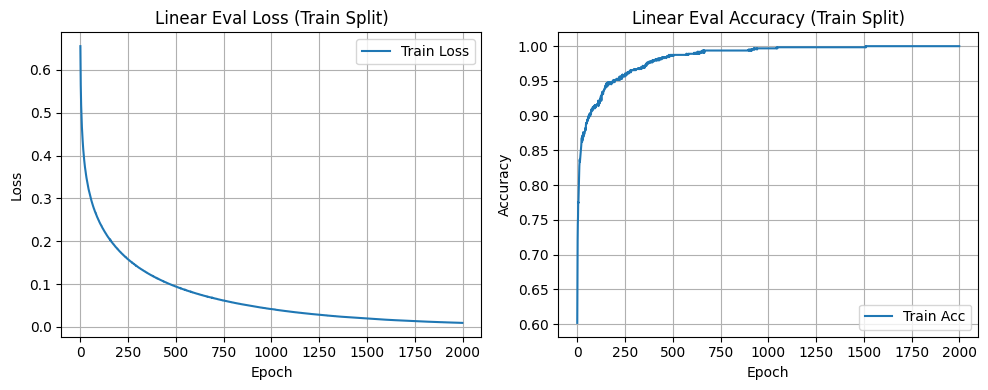

In [15]:
# Cell 15: Linear Eval Curves (Train Split Only)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.title('Linear Eval Loss (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.title('Linear Eval Accuracy (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [16]:
# Cell 16: Testing on 80% Test Split

classifier.eval()
test_labels_all, test_probs_all, test_preds_all = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all  = np.concatenate(test_preds_all)

print("\nTest (80%) Classification Report:")
print(classification_report(test_labels_all, test_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test (80%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.88      0.92      0.90      1142
   Others_augmented       0.93      0.89      0.91      1412

           accuracy                           0.91      2554
          macro avg       0.90      0.91      0.91      2554
       weighted avg       0.91      0.91      0.91      2554



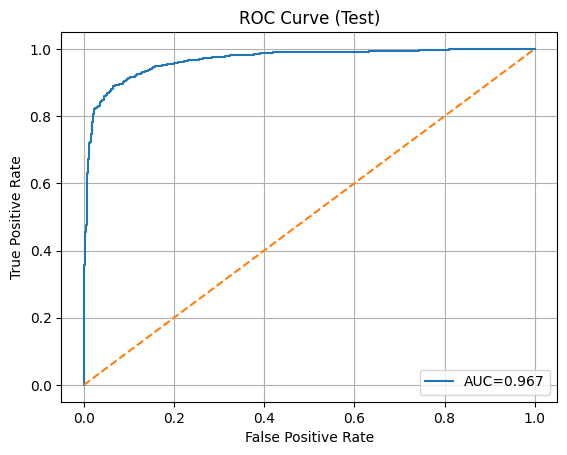

In [17]:
# Cell 17: ROC Curves (Multi-class or Binary)

if NUM_CLASSES == 2:
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
    auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.grid(True); plt.legend(); plt.show()
else:
    # One-vs-Rest ROC
    y_bin = label_binarize(test_labels_all, classes=list(range(NUM_CLASSES)))
    aucs = []
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], test_probs_all[:,i])
        auc_i = roc_auc_score(y_bin[:,i], test_probs_all[:,i])
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{IDX_TO_CLASS[i]} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (OvR) - Test")
    plt.grid(True); plt.legend(); plt.show()
    print("Per-class AUCs:", {IDX_TO_CLASS[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})


Computing t-SNE on TEST features...


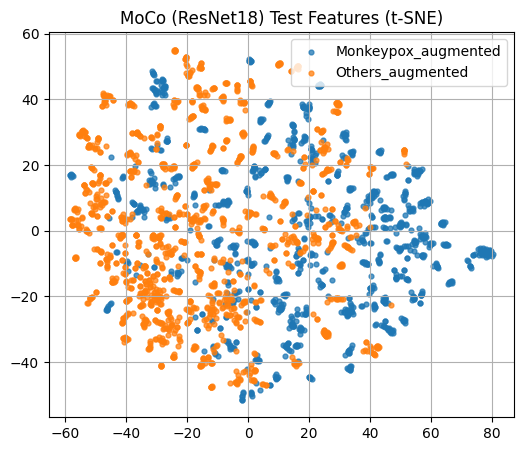

In [18]:
# Cell 18: t-SNE on TEST Features (Separability Check)

print("Computing t-SNE on TEST features...")
# Reuse the same frozen encoder (encoder_linear) for features
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("MoCo (ResNet18) Test Features (t-SNE)"); plt.grid(True); plt.show()
